# Exploratory data analysis and statistical visualizations with `seaborn`

In a previous lab you learned about using `matplotlib` to create and modify plots in Python. 

Today we're going to look at [Seaborn](https://seaborn.pydata.org/index.html), a plotting library built *on top of* `matplotlib`, designed for making **statistical visualizations**

Seaborn helps you explore and understand your data. Its plotting functions operate on dataframes and arrays containing whole datasets and internally perform the necessary semantic mapping and statistical aggregation to produce informative plots. Its dataset-oriented, declarative API lets you **focus on what the different elements of your plots mean**, rather than on the details of how to draw them.

At the same time you can always take what you've learned about customizing a figure in `matplotlib` and apply it to any plot generated by `seaborn`

The [**Seaborn website**](https://seaborn.pydata.org/index.html) has some excellent additional tutorials, gallery, and additional resources that you can reference

## Getting started

Below we import `seaborn` and `polars` for manipulating data:

In [1]:
import seaborn as sns # convention
import polars as pl
from polars import col

Seaborn includes a few datasets we can play with to get oriented to core plotting functions.  
Let's start with the famous [Anscombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet):  
4 datasets with 2 variables each that have the *same* means and correlations, but very *different* distributions:  

<img src="./figs/quartet.png" width="50%" alt="Figure 1">

We can use the `sns.load_dataset` function to load these datasets into a DataFrame:

In [2]:
scatter_data = sns.load_dataset('anscombe')

type(scatter_data)

pandas.core.frame.DataFrame

**Note** The [`load_dataset`]() function returns `pandas` DataFrames, but we've been using **Polars** DataFrames in this course.


Fortunately it's easy to convert between the two and `seaborn` works with both

To convert a Pandas DataFrame to a polars, we just to pass it to `pl.DataFrame` as an argument and save the result:

In [3]:
# Pandas -> polars
scatter_data = pl.DataFrame(scatter_data)

type(scatter_data)

polars.dataframe.frame.DataFrame

And now we can perform familiar operations we learned last week:

In [4]:
scatter_data.head()

shape: (5, 3)
┌─────────┬──────┬──────┐
│ dataset ┆ x    ┆ y    │
│ ---     ┆ ---  ┆ ---  │
│ str     ┆ f64  ┆ f64  │
╞═════════╪══════╪══════╡
│ I       ┆ 10.0 ┆ 8.04 │
│ I       ┆ 8.0  ┆ 6.95 │
│ I       ┆ 13.0 ┆ 7.58 │
│ I       ┆ 9.0  ┆ 8.81 │
│ I       ┆ 11.0 ┆ 8.33 │
└─────────┴──────┴──────┘

If you ever need to convert your Polars DataFrame *back* to a Pandas DataFrame, you can use the `.to_pandas()` method.

This will come in handy if you ever use another Python library that *only* works with Pandas DataFrames.


In [5]:
type(scatter_data.to_pandas())

pandas.core.frame.DataFrame

Ok let's take a look at these data and summarize them. We'll use a `.group_by` **context** to **summarize** the mean and standard deviation of `x` and `y` separately per *dataset*.

In [6]:
scatter_data.group_by('dataset', maintain_order=True).agg(
    x_mean = col('x').mean(),
    x_std = col('x').std(),
    y_mean = col('y').mean(),
    y_std = col('y').std(),
)

shape: (4, 5)
┌─────────┬────────┬──────────┬──────────┬──────────┐
│ dataset ┆ x_mean ┆ x_std    ┆ y_mean   ┆ y_std    │
│ ---     ┆ ---    ┆ ---      ┆ ---      ┆ ---      │
│ str     ┆ f64    ┆ f64      ┆ f64      ┆ f64      │
╞═════════╪════════╪══════════╪══════════╪══════════╡
│ I       ┆ 9.0    ┆ 3.316625 ┆ 7.500909 ┆ 2.031568 │
│ II      ┆ 9.0    ┆ 3.316625 ┆ 7.500909 ┆ 2.031657 │
│ III     ┆ 9.0    ┆ 3.316625 ┆ 7.5      ┆ 2.030424 │
│ IV      ┆ 9.0    ┆ 3.316625 ┆ 7.500909 ┆ 2.030579 │
└─────────┴────────┴──────────┴──────────┴──────────┘

We can see that each dataset has the *same* mean and standard deviation.   
What's famous about these data is that each dataset also has the same *correlation* between `x` and`y`.

Let's extend our expression to add a column to calculate this. We can use the `pl.corr()` function to do so:

In [7]:
scatter_data.group_by('dataset').agg(
    x_mean = col('x').mean(),
    x_std = col('x').std(),
    y_mean = col('y').mean(),
    y_std = col('y').std(),
    xy_corr = pl.corr('x','y') # correlation between columns x and y
)

shape: (4, 6)
┌─────────┬────────┬──────────┬──────────┬──────────┬──────────┐
│ dataset ┆ x_mean ┆ x_std    ┆ y_mean   ┆ y_std    ┆ xy_corr  │
│ ---     ┆ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str     ┆ f64    ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════╪════════╪══════════╪══════════╪══════════╪══════════╡
│ IV      ┆ 9.0    ┆ 3.316625 ┆ 7.500909 ┆ 2.030579 ┆ 0.816521 │
│ II      ┆ 9.0    ┆ 3.316625 ┆ 7.500909 ┆ 2.031657 ┆ 0.816237 │
│ I       ┆ 9.0    ┆ 3.316625 ┆ 7.500909 ┆ 2.031568 ┆ 0.816421 │
│ III     ┆ 9.0    ┆ 3.316625 ┆ 7.5      ┆ 2.030424 ┆ 0.816287 │
└─────────┴────────┴──────────┴──────────┴──────────┴──────────┘

## Simple plots 

Let's take a look at how to explore these data visually with `seaborn`.

Seaborn includes a number of functions that understand the *names* of columns in a dataframe.  
These include functions for visualizing:

- **Relationships** between *numeric* columns
- **Distributions** of *numeric* columns
- **Categorical** summaries and relationships by *non-numerical* columns

The smaller boxes in this diagram are various **axis-level functions** that `seaborn` provides to quickly create *simple plots*.  
As the name implies, each function returns a matplotib Axis, just like you previously made with `plt.plot()` and `plt.subplots()`.

<img src="./figs/seaborn.png" width="45%" alt="Figure 1">

**Relationships**  
- `scatterplot`  
- `lineplot`

**Distributions**  
- `histplot`  
- `kdeplot`  
- `ecdfplot`  
- `rugplot`  

**Categorical**  
- `stripplot`  
- `swarmplot`  
- `boxplot`  
- `violinplot`  
- `pointplot`  
- `barplot`  



Let's take a look at [`sns.scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

In [ ]:
sns.scatterplot?

After setting the `data` argument to our DataFrame, we specify which **column names** to map to the `x` and `y` axes:

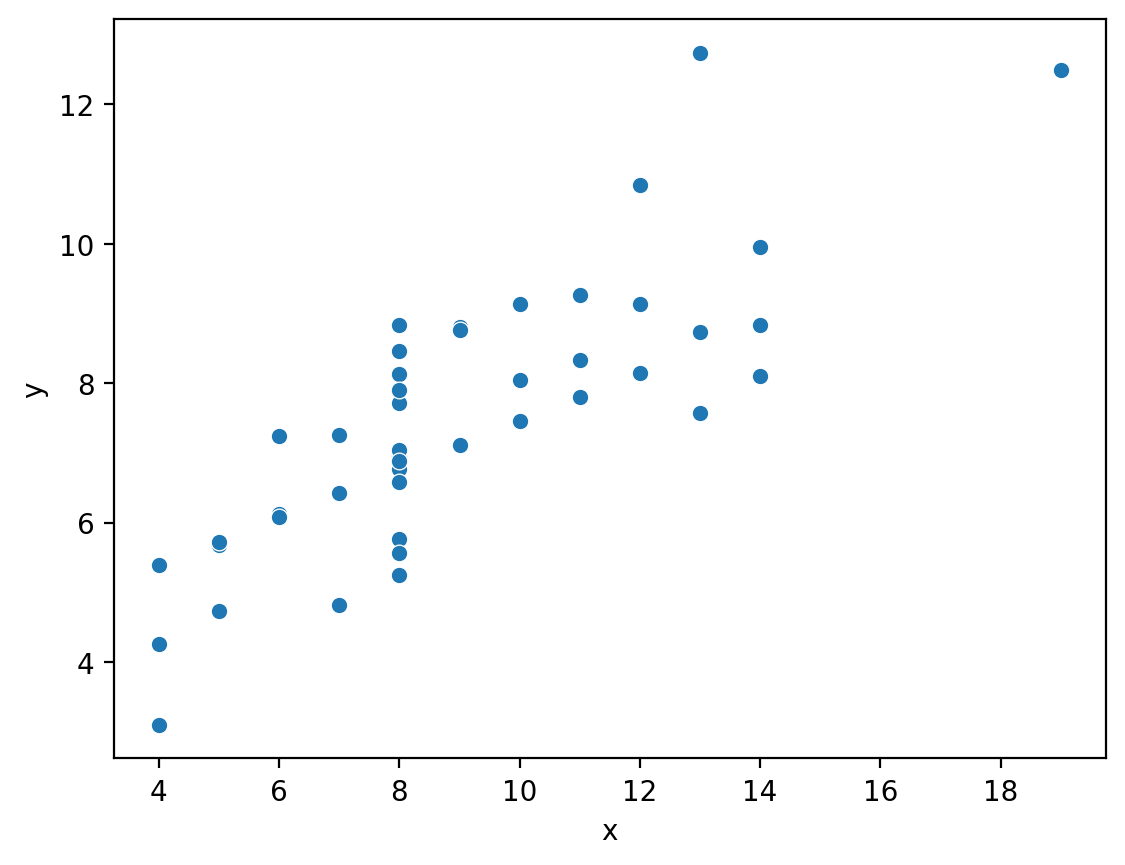

In [8]:
axis = sns.scatterplot(
    data=scatter_data,
    x="x",
    y="y",
)

And we can even map the "dataset" column to the `hue` of each point:

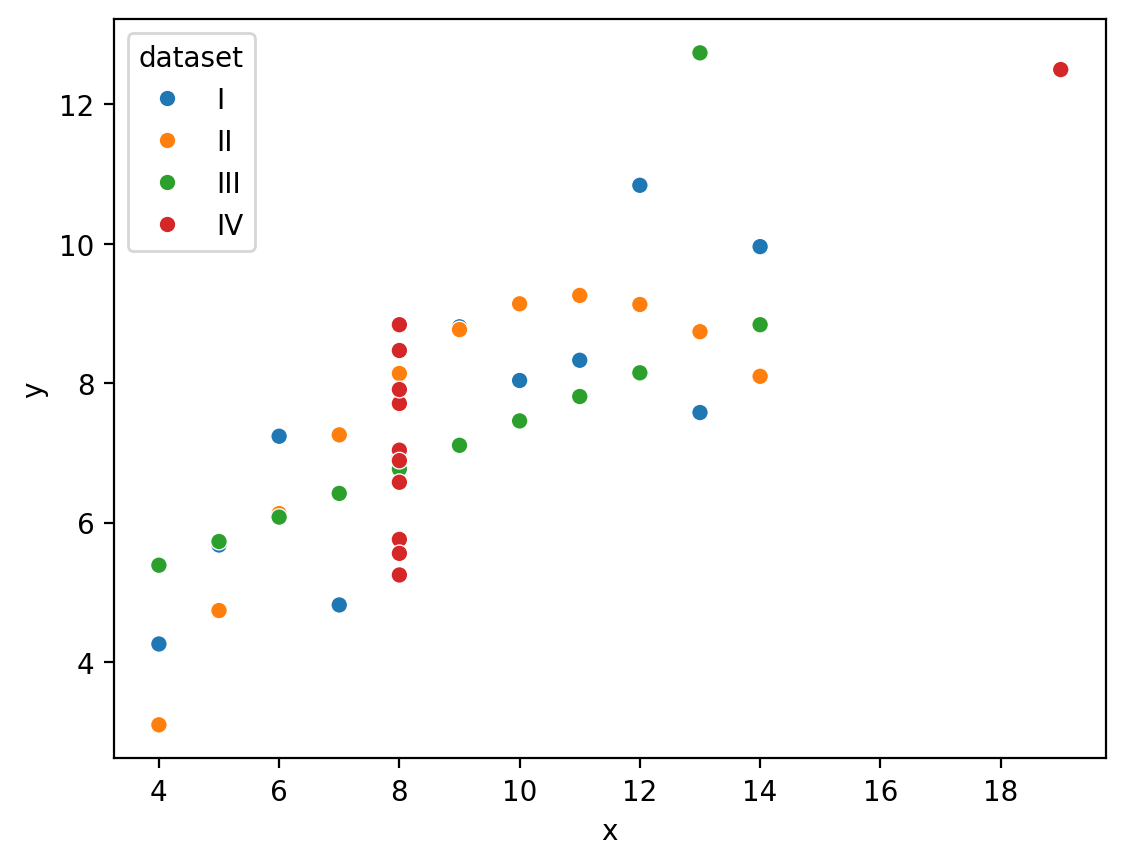

In [9]:
axis = sns.scatterplot(
    data=scatter_data,
    x="x",
    y="y",
    hue="dataset"
)

And because this returns a matplotlib Axis, you can customize it using familiar commands:

In [10]:
type(axis)

matplotlib.axes._axes.Axes

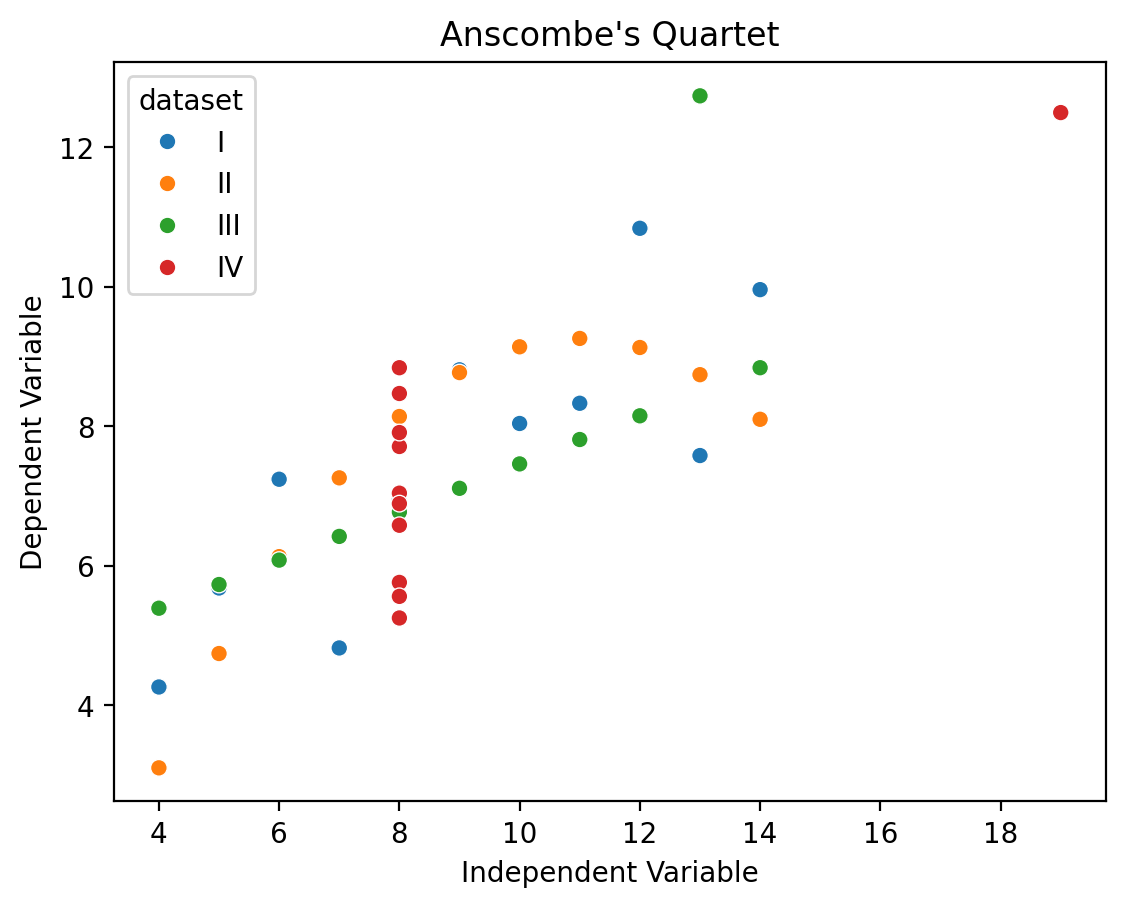

In [11]:
import matplotlib.pyplot as plt

axis = sns.scatterplot(
    data=scatter_data,
    x="x",
    y="y",
    hue="dataset"
)

# You learned about these commands in a previous lab!
plt.xlabel('Independent Variable');
plt.ylabel('Dependent Variable');
plt.title("Anscombe\'s Quartet");

## Better plots

So we can see how to map different columns to different parts of our figure, but in this case `hue` isn't really make it easier to see what's going on because all 4 datasets are being plotted on the same axes.

Instead it would be nice a separate plot for each dataset. We *could* do this manually using `plt.subplots()` but that's a lot of work.  
We'd have to use Polars to `.filter` by each dataset, create a new scatter plot for each one, then make sure all the subplots are aligned well.

Seaborn makes this much easier by letting us create a `FacetGrid` - a new kind of object that allows us to more easily manage and customize simple and complex plots and arrangements.  

Instead of using any of **axis-level functions** in the diagram below, we can instead use one of the **3 figure-level functions** to create a highly-customizable `FacetGrid`:  

- `sns.relplot` for relationships
- `sns.displot` for distributions
- `sns.catplot` for categorical data

<img src="./figs/seaborn.png" width="45%" alt="Figure 1">


Let's take a look at `sns.relplot`

In [ ]:
sns.relplot?

We can use it just like before by referring to our **column names** directly.  
But this time we also specify a `kind = 'scatter'` to tell seaborn to use a scatter plot.

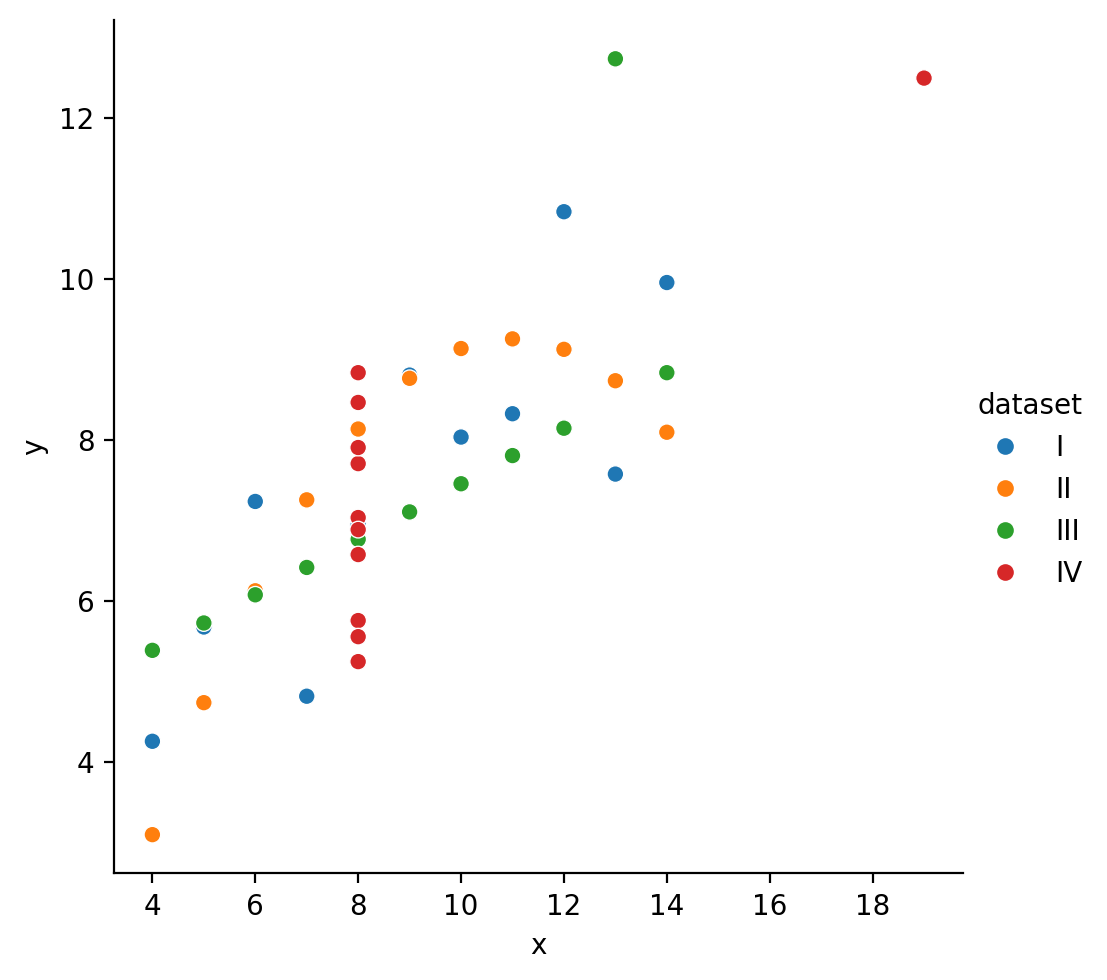

In [12]:
grid = sns.relplot(
    data=scatter_data,
    kind="scatter",
    x="x",
    y="y",
    hue="dataset"
)

We can see that this time seaborn returns a `FacetGrid` object, which has it's own *methods* for tweaking and customization (that we'll explore later in this notebook)

In [13]:
type(grid)

seaborn.axisgrid.FacetGrid

**figure-level functions** like `sns.relplot` accept all the same mappings between column names and aesthetics as the **axis-level functions** like `sns.scatterplot`. 

However, they also let us easily organize the data into subplots using the `col` and `row` mappings:

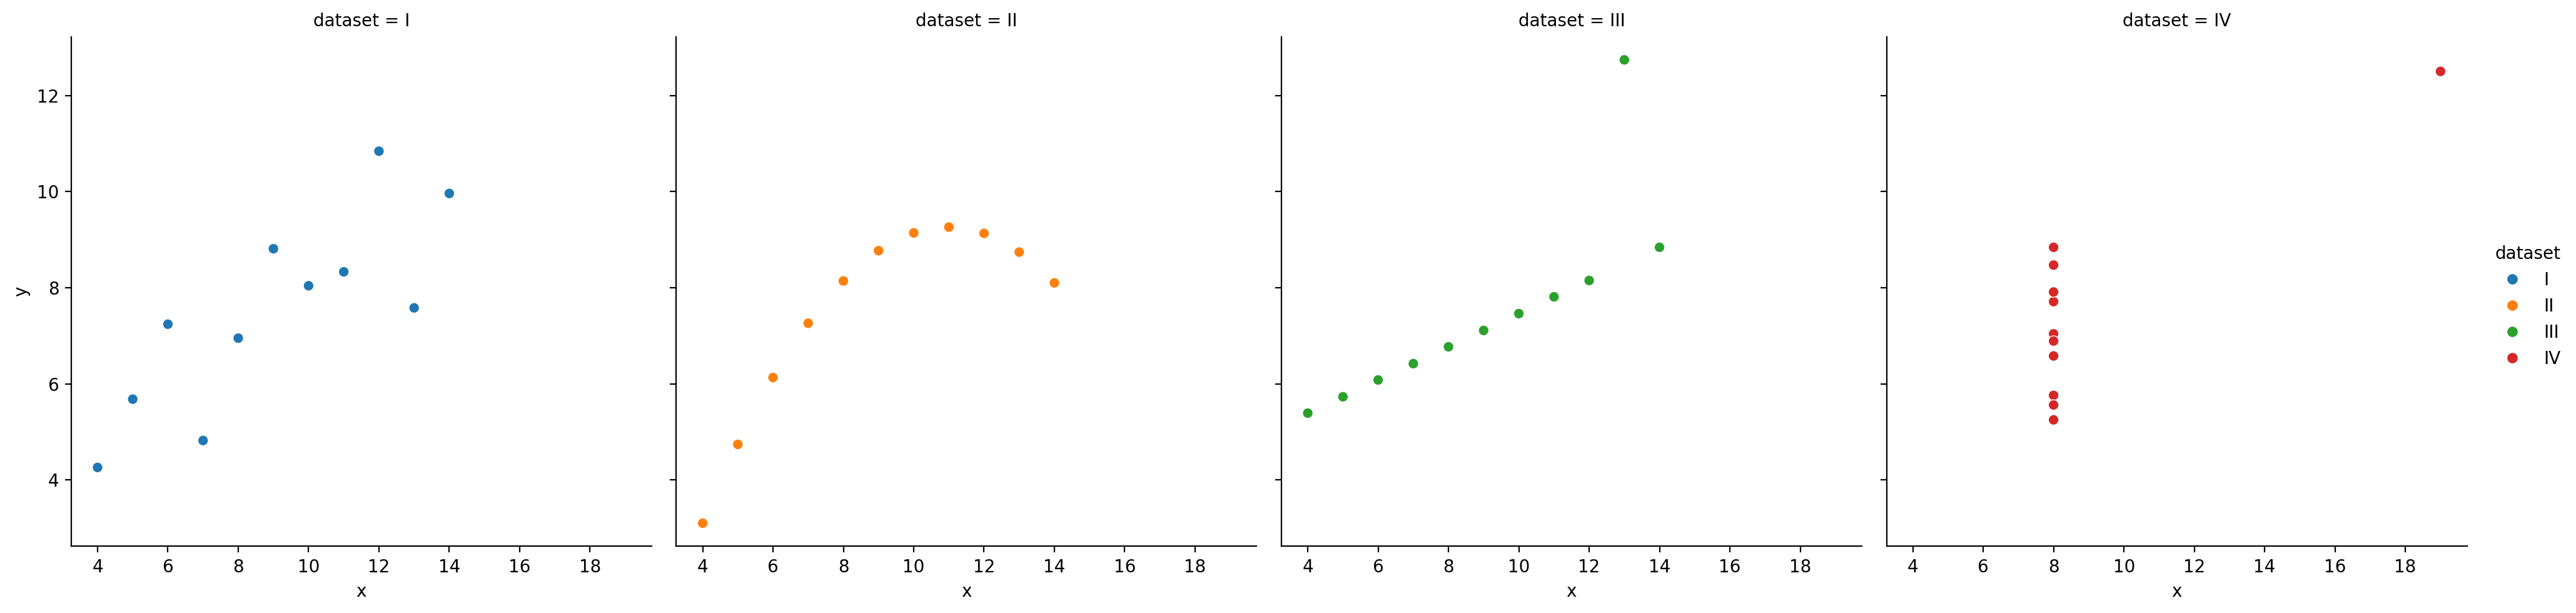

In [14]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset"
)

We can also easily control the overall size and aspect-ratio of each subplot using `height` and `aspect`, and the number of columns using `col_wrap`:

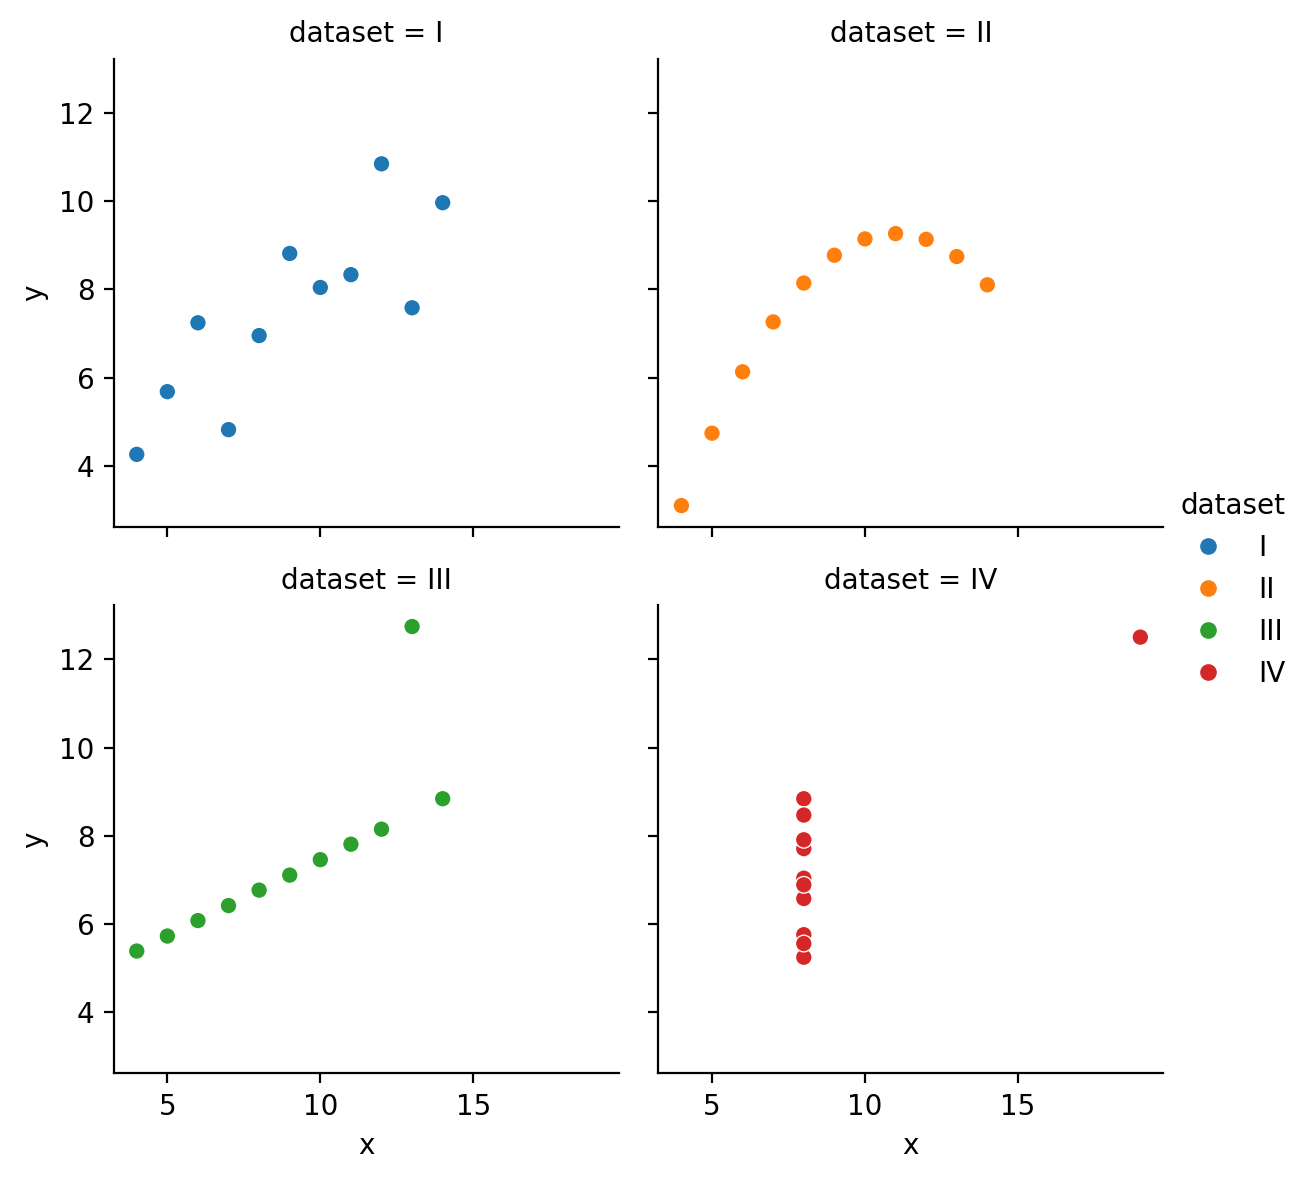

In [15]:
# Better layout
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

)

What if we want to add a regression line to the scatter plot? This is *super easy* by just swapping out `sns.relplot` for [`sns.lmplot`](https://seaborn.pydata.org/generated/seaborn.lmplot.html).  

This is another **figure-level function** that works the same way by creating a `FacetGrid` for us and giving us a few additional arguments to control the regression line.

Let's swap it out and remove the `kind='scatter'` argument, as we don't need it anymore:

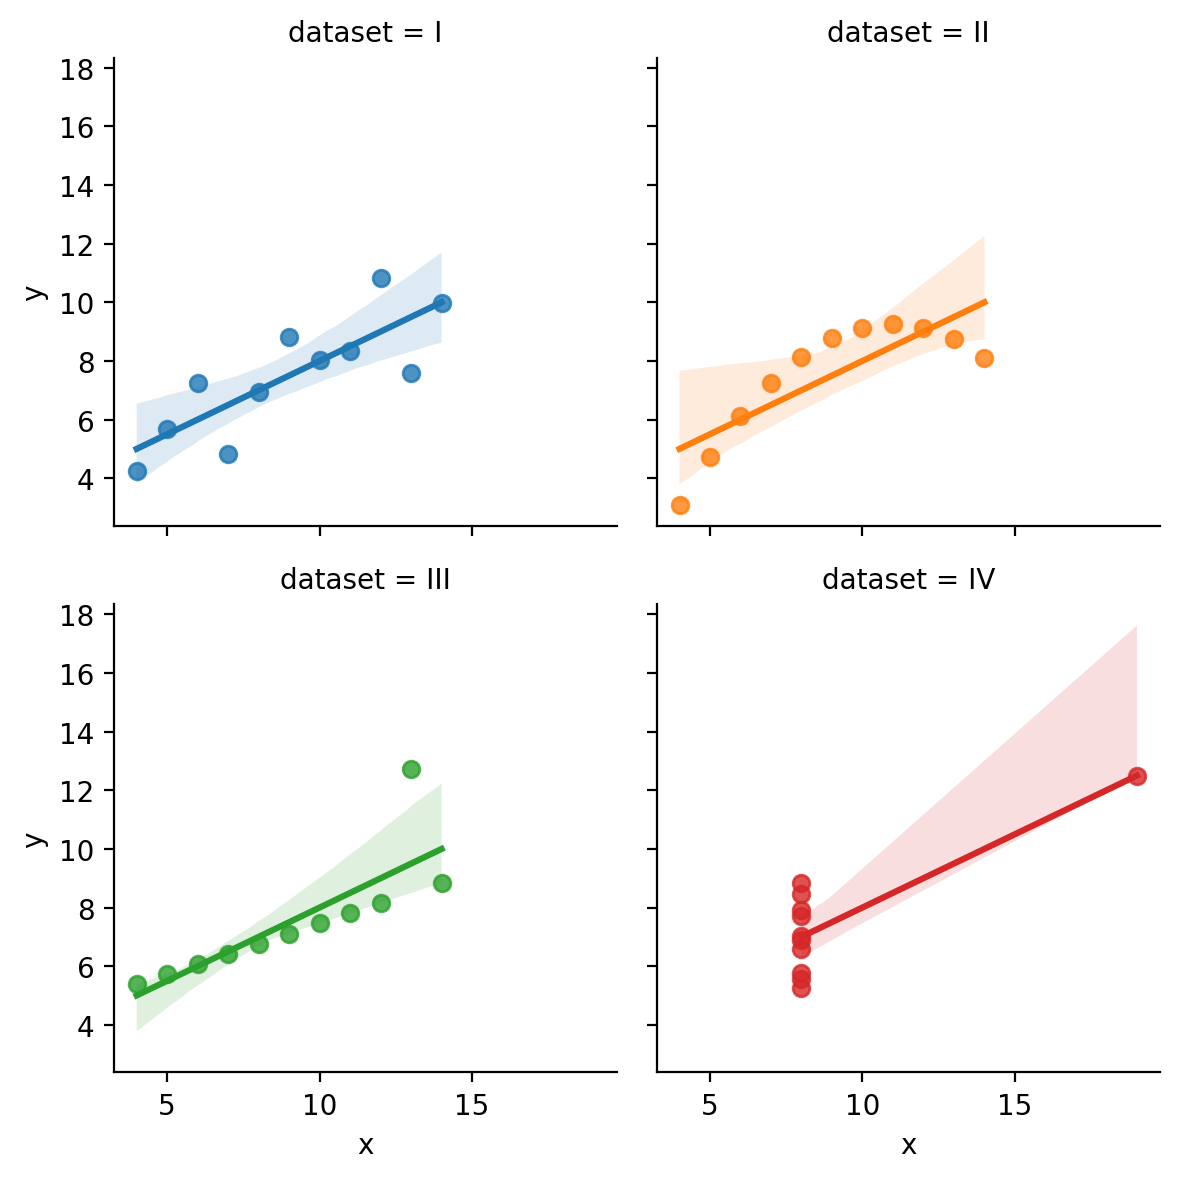

In [16]:
grid = sns.lmplot(
    data=scatter_data,
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);

For the rest of this notebook we'll be useing **figure level functions** like this example to demonstrate how you can perform some visual EDA on any data

## EDA - Visualizing Relationships

The power of `seaborn`'s **figure-level functions** is that we can easily do some exploratory data analysis (EDA) while writing *much* less code.

Why is this important? Let's take a look by exploring how seaborn allows us to **[visualize relationships](https://seaborn.pydata.org/tutorial/relational.html)**

Let's take a look at another classic example: the *penguins* dataset - penguin body measurements for different species, islands, and sexes.

We can load it up like before:

In [17]:
# Load and convert to polars DataFrame in a single line
penguins = pl.DataFrame(sns.load_dataset("penguins"))

penguins.head()

shape: (5, 7)
┌─────────┬───────────┬────────────────┬───────────────┬───────────────────┬─────────────┬────────┐
│ species ┆ island    ┆ bill_length_mm ┆ bill_depth_mm ┆ flipper_length_mm ┆ body_mass_g ┆ sex    │
│ ---     ┆ ---       ┆ ---            ┆ ---           ┆ ---               ┆ ---         ┆ ---    │
│ str     ┆ str       ┆ f64            ┆ f64           ┆ f64               ┆ f64         ┆ str    │
╞═════════╪═══════════╪════════════════╪═══════════════╪═══════════════════╪═════════════╪════════╡
│ Adelie  ┆ Torgersen ┆ 39.1           ┆ 18.7          ┆ 181.0             ┆ 3750.0      ┆ Male   │
│ Adelie  ┆ Torgersen ┆ 39.5           ┆ 17.4          ┆ 186.0             ┆ 3800.0      ┆ Female │
│ Adelie  ┆ Torgersen ┆ 40.3           ┆ 18.0          ┆ 195.0             ┆ 3250.0      ┆ Female │
│ Adelie  ┆ Torgersen ┆ null           ┆ null          ┆ null              ┆ null        ┆ null   │
│ Adelie  ┆ Torgersen ┆ 36.7           ┆ 19.3          ┆ 193.0             ┆ 3450.0      ┆ Female │
└─────────┴───────────┴────────────────┴───────────────┴───────────────────┴─────────────┴────────┘

Let's start by exploring the **overall** relationship between 2 variables using `sns.lmplot` like the previous example:
- `bill_length_mm`: the length of a penguin's bill in millimeters
- `bill_depth_mm`: the depth of a penguin's bill in millimeters

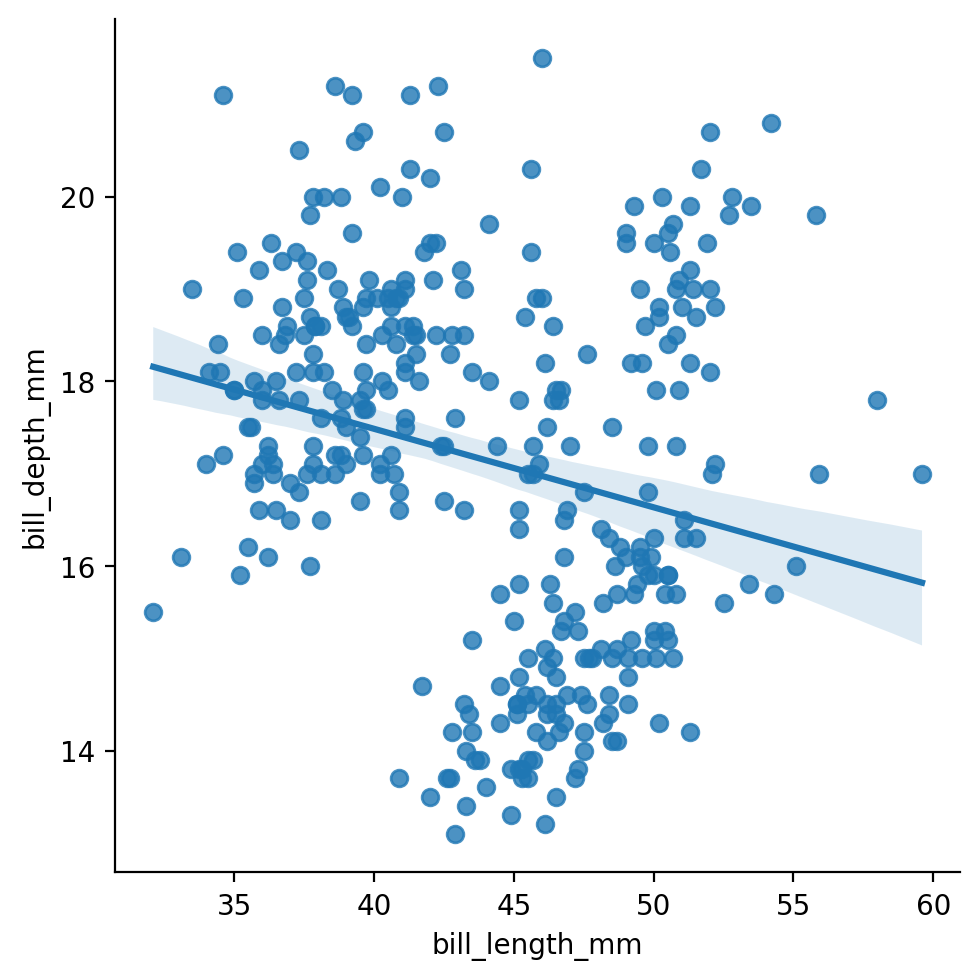

In [18]:
grid = sns.lmplot(
    data=penguins,
    x="bill_length_mm",
    y="bill_depth_mm",
)

Imagine we stopped our analysis here and concluded that this relationship was **negative**: the *longer* a penguin's bill, the *less* deep it is.

But is this true for every *species*? 

Let's take a look, by mapping `hue` to the species column.

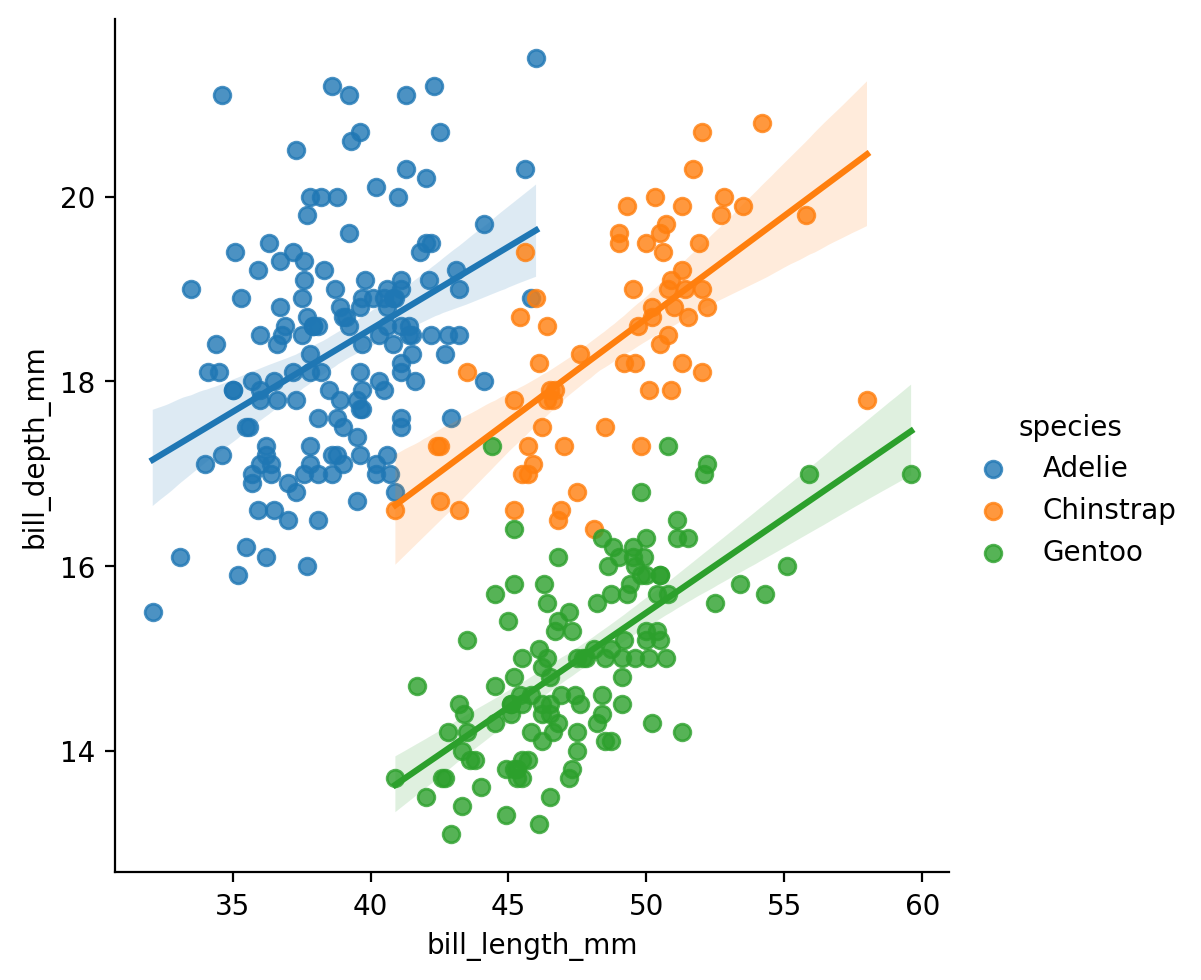

In [19]:
grid = sns.lmplot(
    data=penguins,
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="species",
)

This is totally different! The relationship *within* each species is **positive**. Had we ignored the fact that these measurements were taken for different species, we would have come to the wrong conclusion!

This is an example of a very famous statistical fallacy we'll revisit later in the course called [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox): 

when that trend that exists when we look *across* groups, is *reversed* when we look *within* group!



Seaborn makes it very easy to "slice-and-dice" your data in different ways to facilitate this kind of **exploratory-data-analysis (EDA)** 

Let's see how we can dive in further by splitting our data by the sex of each penguin. 

Since we're just exploring, lets switch back to `sns.relplot` and map `col` to the sex column in our data

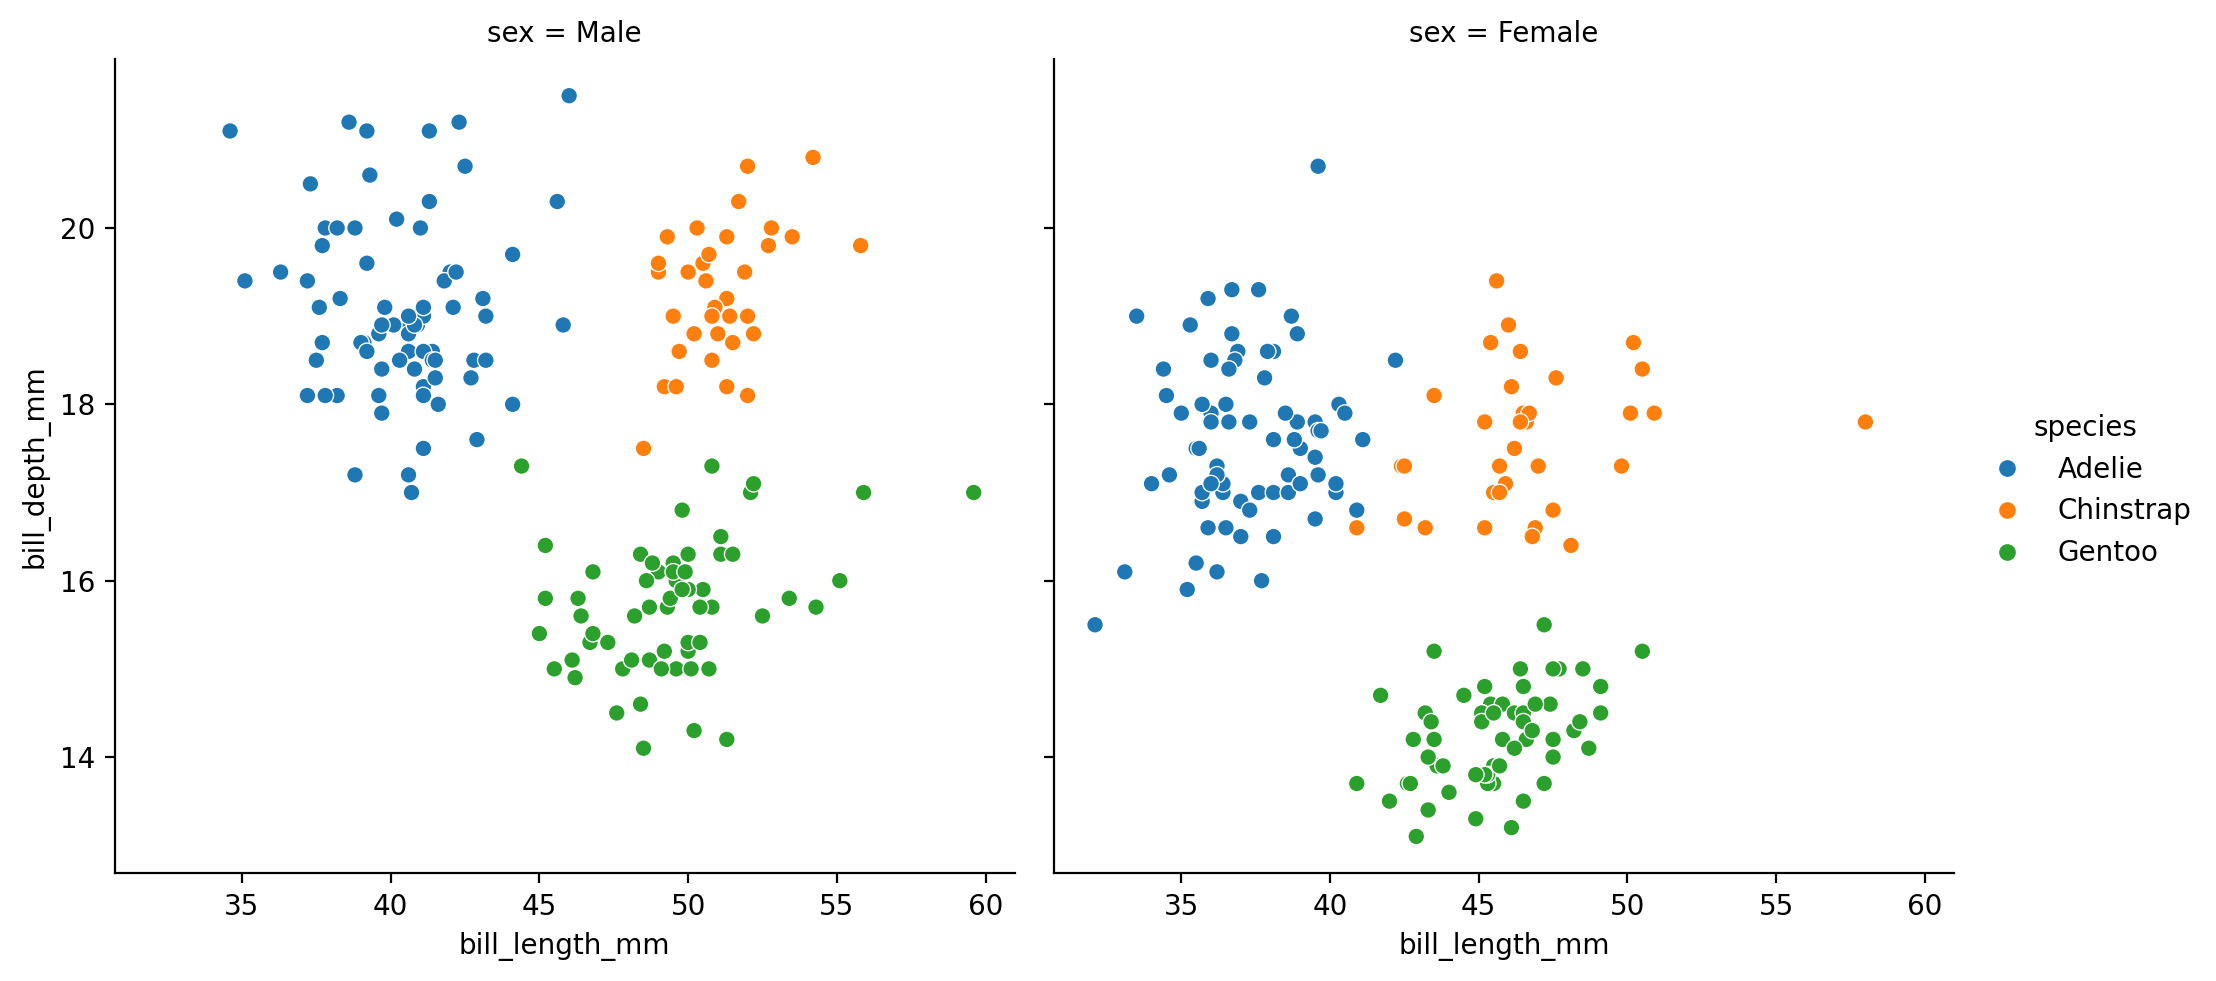

In [20]:
grid = sns.relplot(
    data=penguins,
    kind='scatter',
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="species",
    col="sex"
)

We can already see that for some species (e.g. Gentoos in green), most males seem to have a deeper bill than females. 

What if we dove in further by the island each animal was measure on?  

We'll use a `row` mapping to break the data down by island

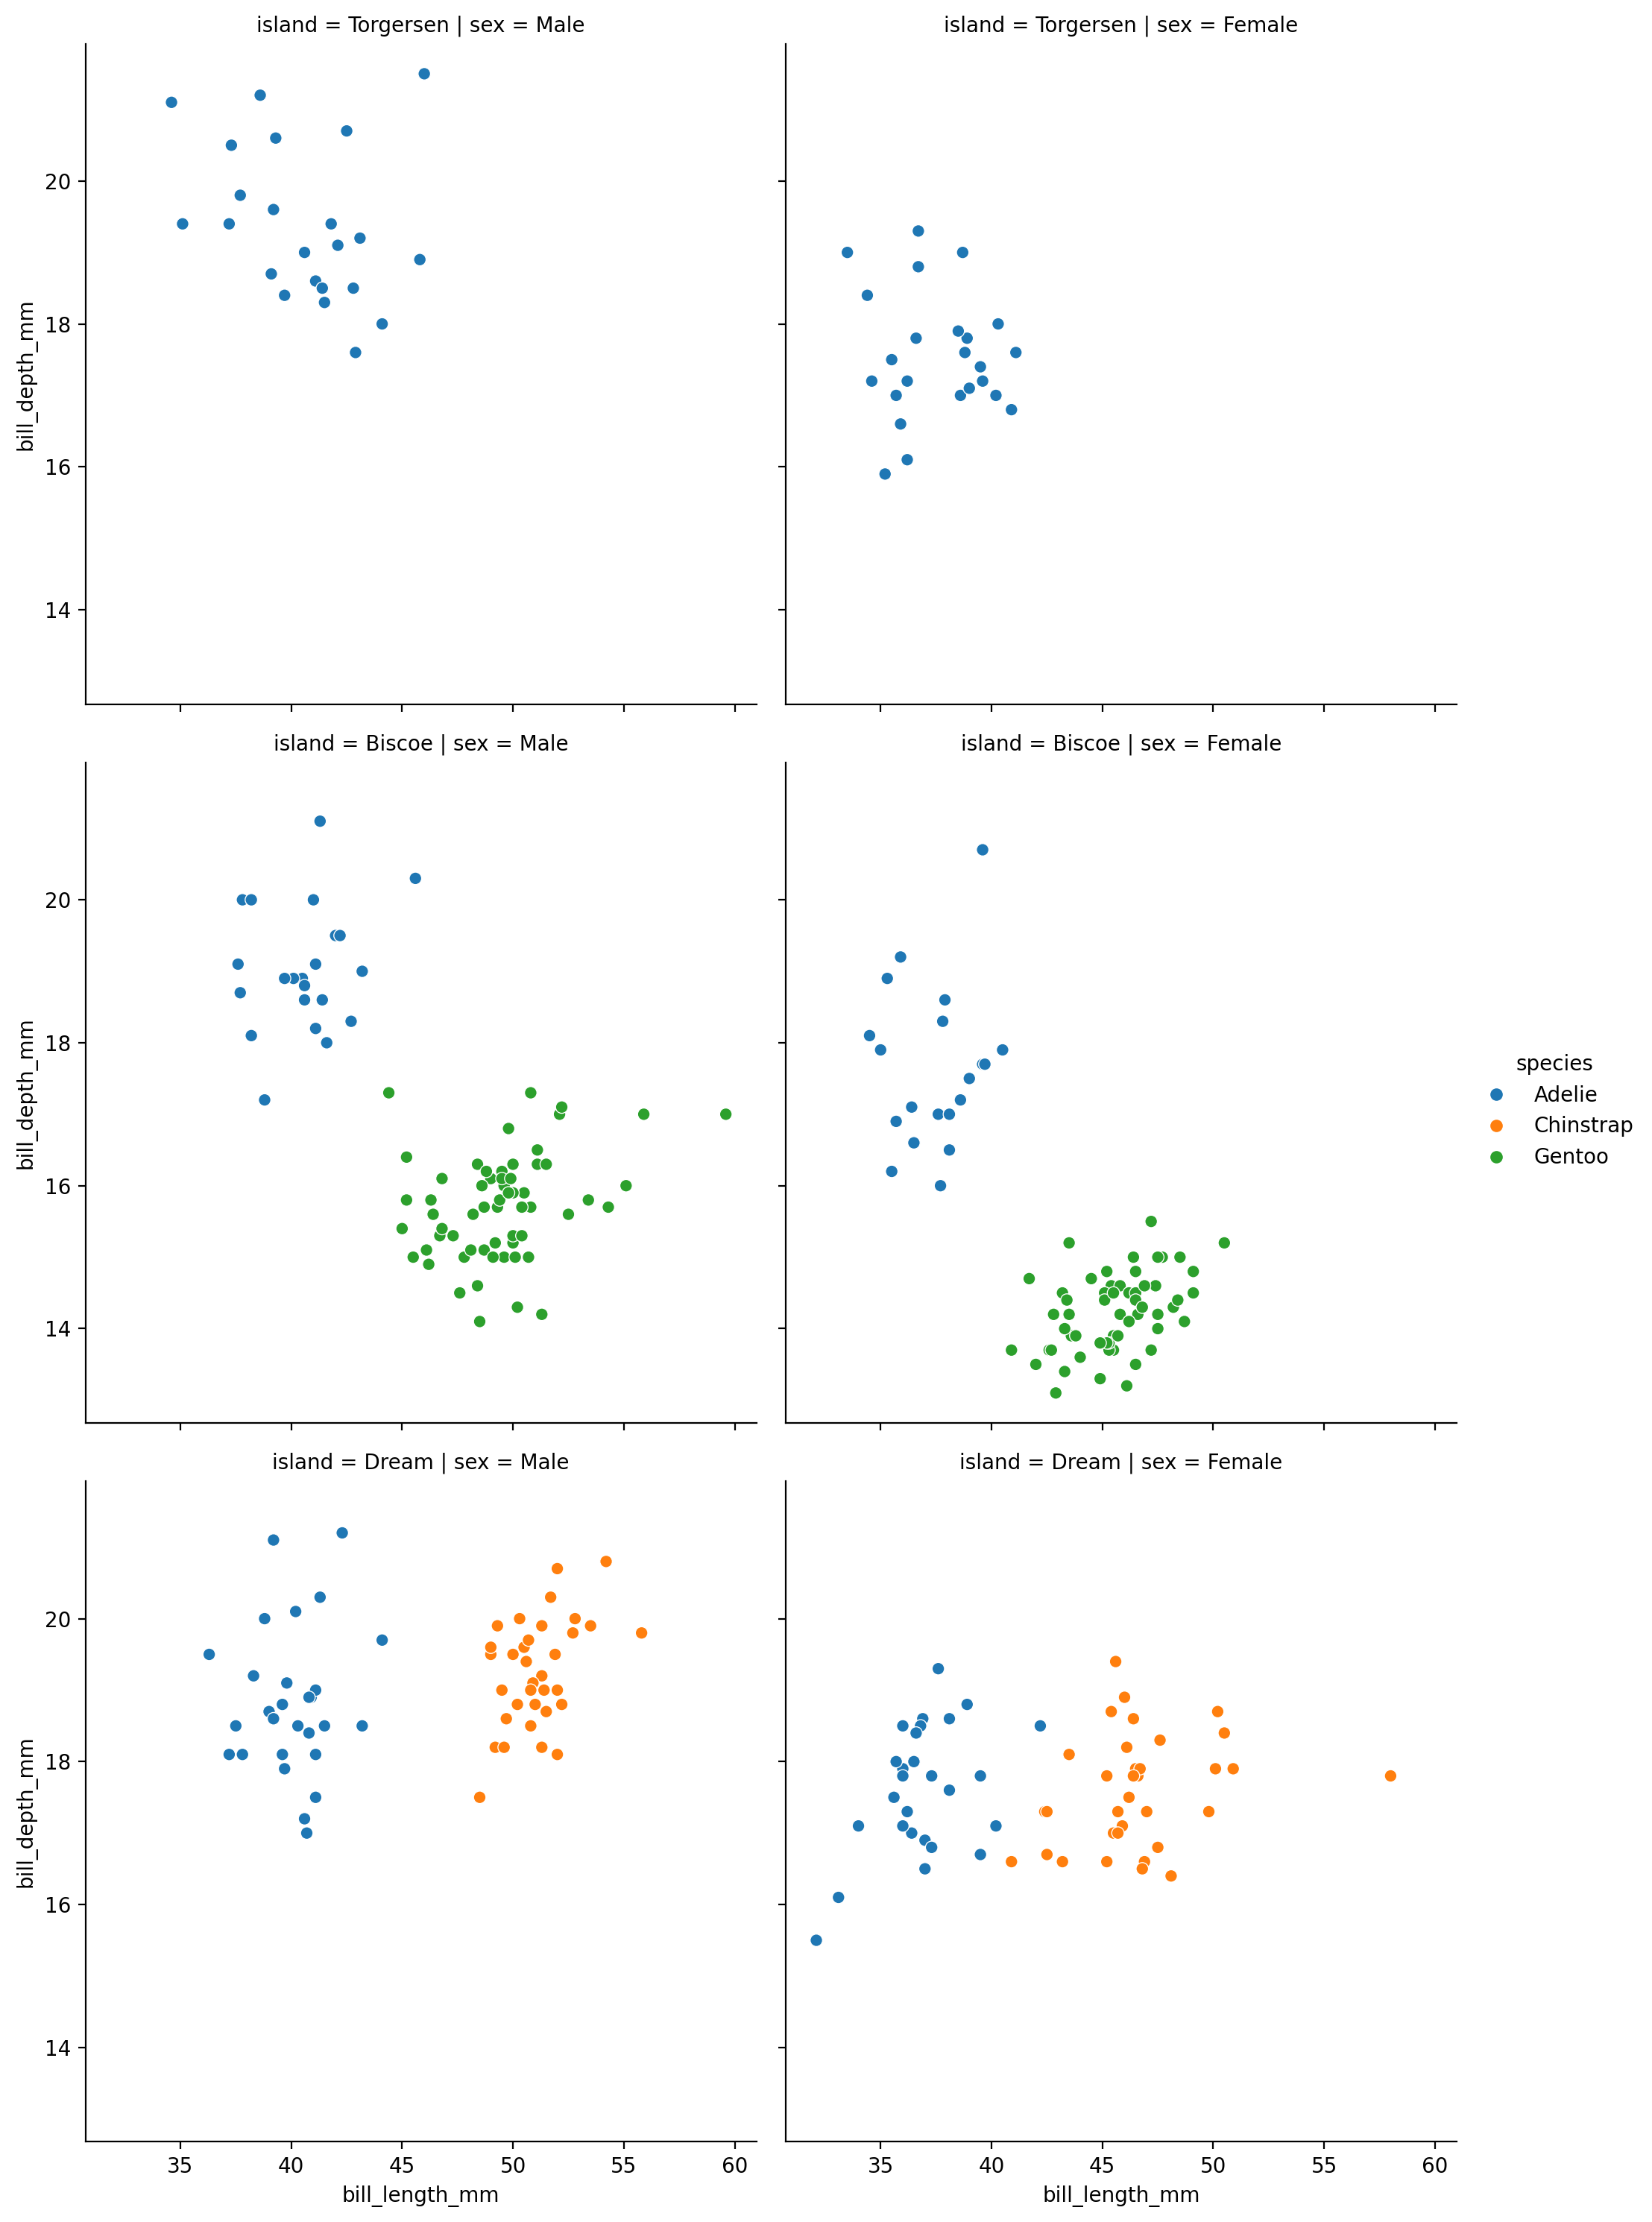

In [21]:
grid = sns.relplot(
    data=penguins,
    kind='scatter',
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="species",
    col="sex",
    row="island"
)

Hmm, something strange is going on because we're missing colors in some plots...

Let's switch up how we're mapping columns to figure aesthetics to try to understand what's going on.

We'll use `hue` for sex, `col` for species, `row` for island, and use `row_order` and `col_order` to tell seaborn to arrange the subplots *alphabetically*

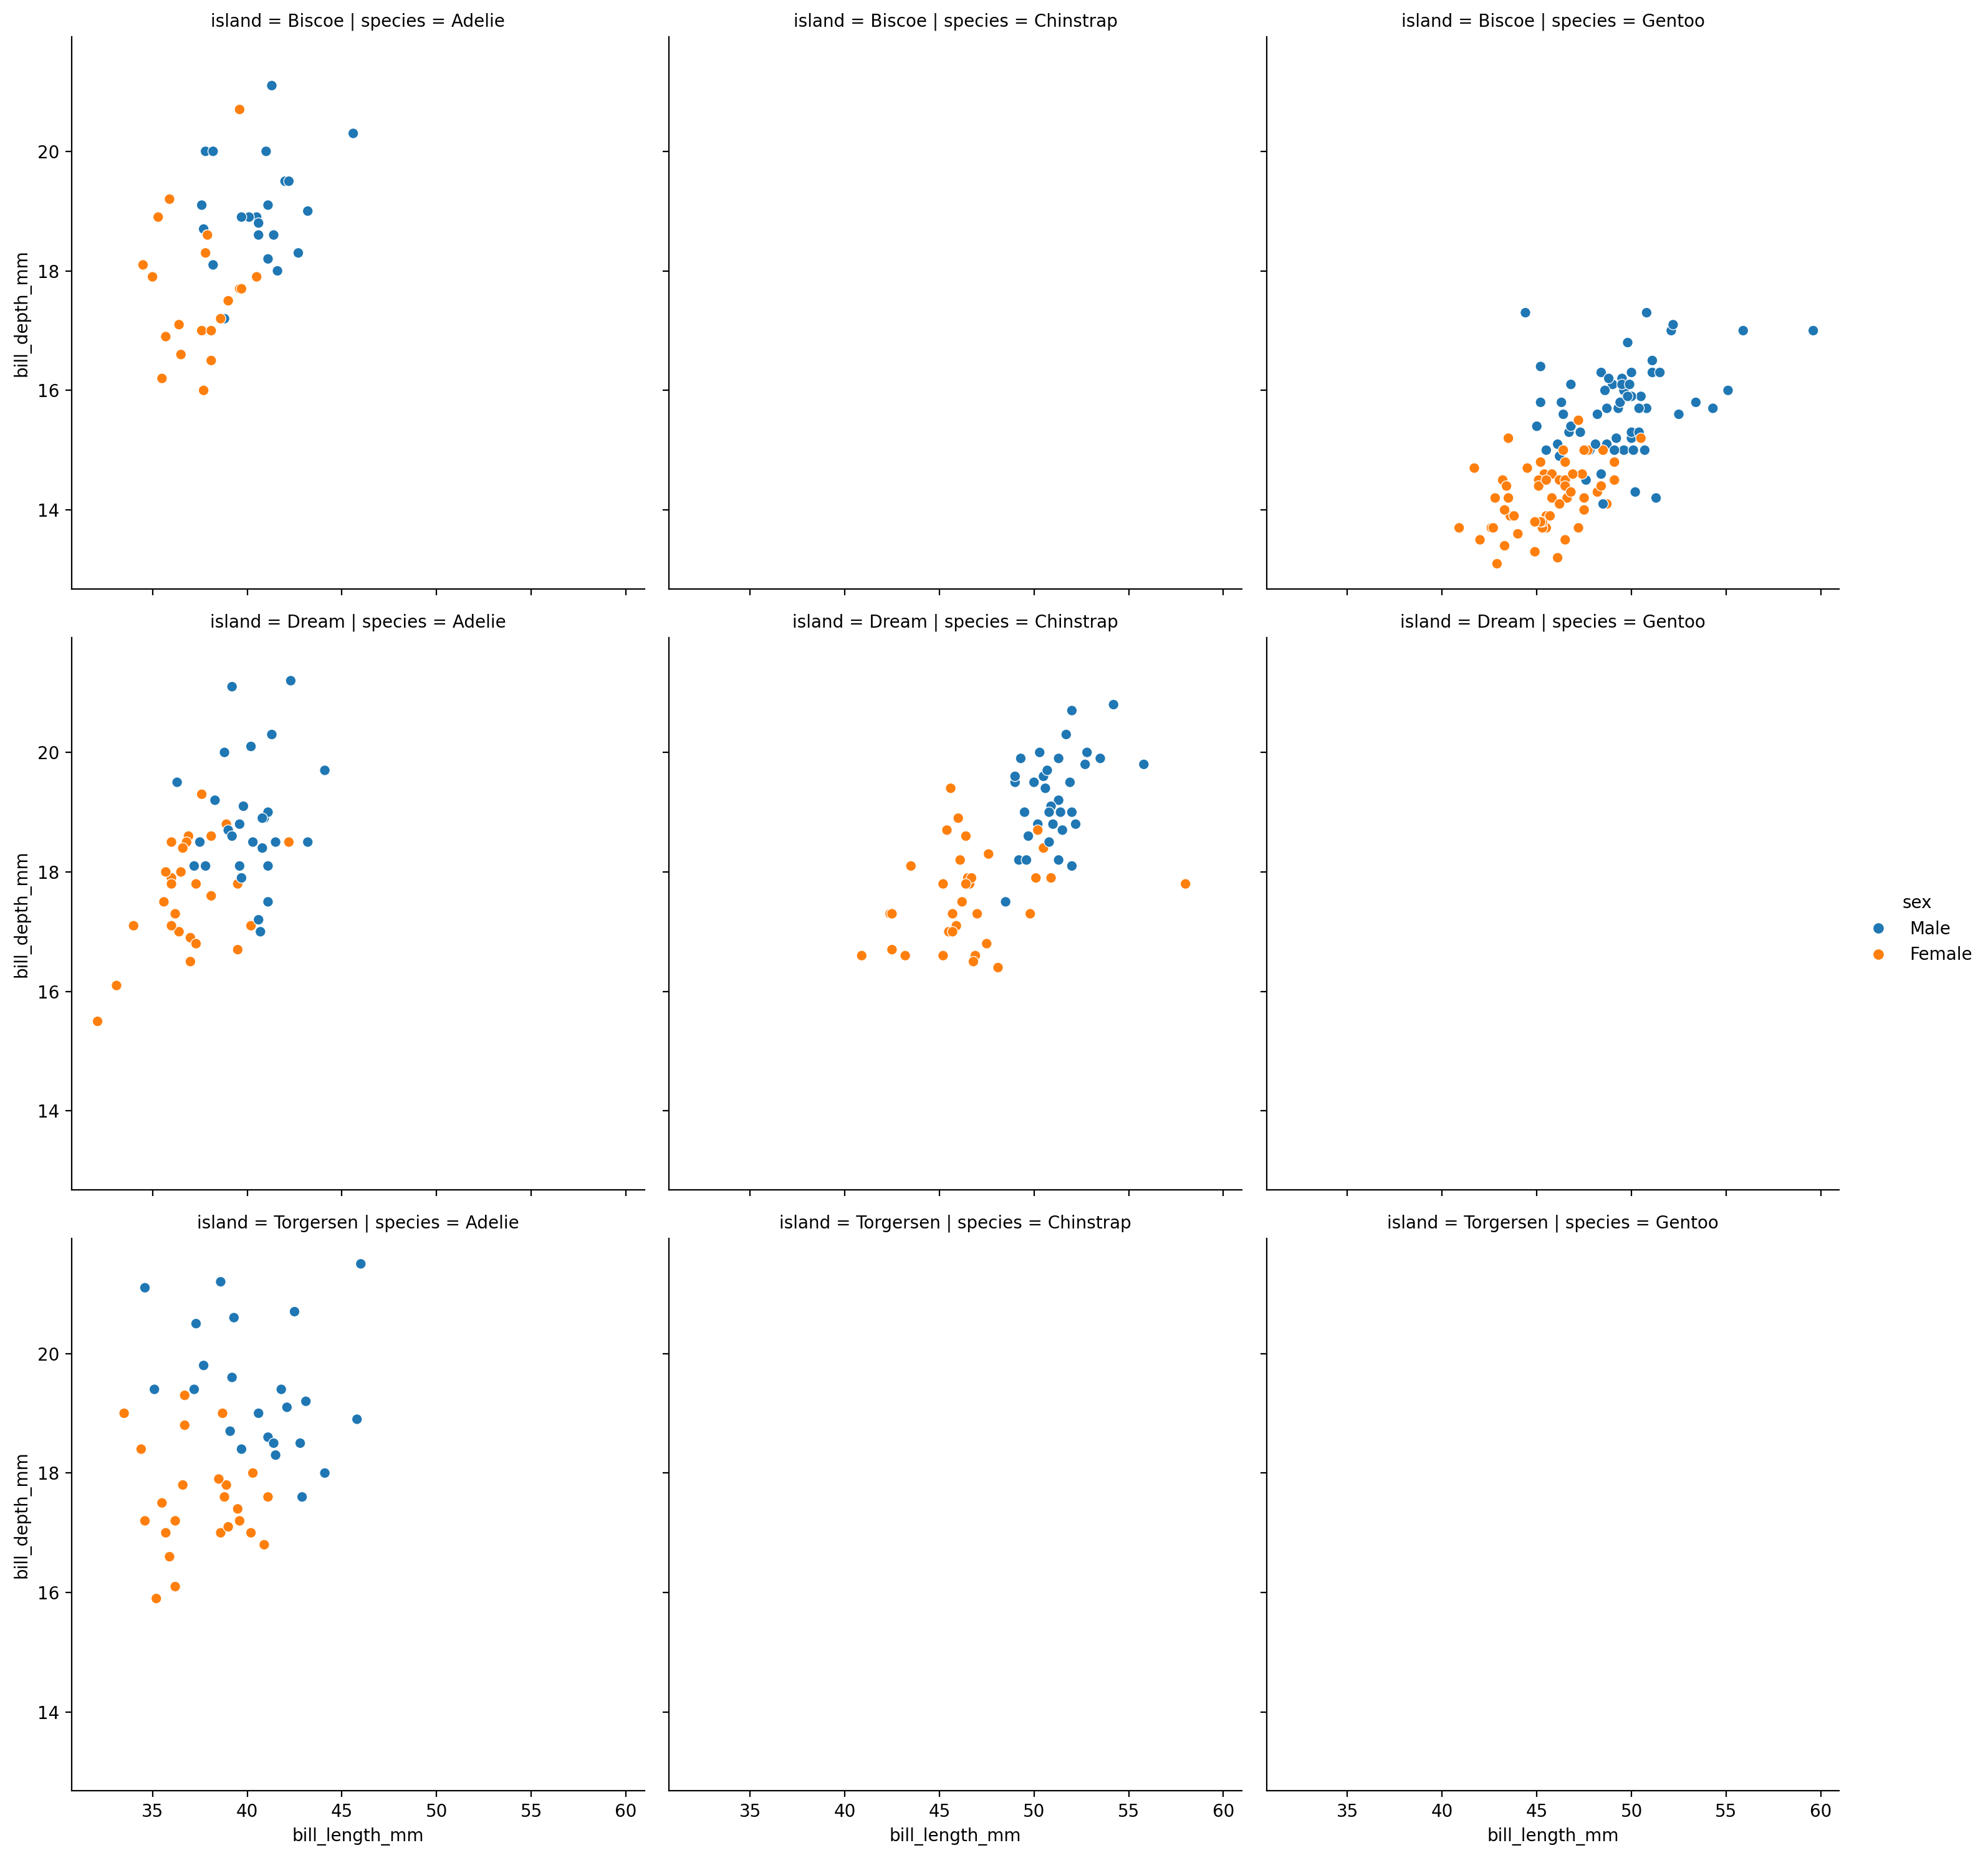

In [22]:
grid = sns.relplot(
    data=penguins,
    kind="scatter",
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="sex",
    col="species",
    row="island",
    # Sort rows and columns alphabetically
    row_order=penguins['island'].unique().sort(),
    col_order=penguins['species'].unique().sort()
)

Ah interesting - now it's immediately obvious that we don't have data for every unique combination of island and species!

For example, we don't seem to have any measurements for *Chinstrap* penguins from the *Biscoe* island.

Let's verify this using a `.filter` expression in polars:

In [23]:
penguins.filter(
    (col('species') == 'Chinstrap') & (col('island') == 'Biscoe')
)

shape: (0, 7)
┌─────────┬────────┬────────────────┬───────────────┬───────────────────┬─────────────┬─────┐
│ species ┆ island ┆ bill_length_mm ┆ bill_depth_mm ┆ flipper_length_mm ┆ body_mass_g ┆ sex │
│ ---     ┆ ---    ┆ ---            ┆ ---           ┆ ---               ┆ ---         ┆ --- │
│ str     ┆ str    ┆ f64            ┆ f64           ┆ f64               ┆ f64         ┆ str │
╞═════════╪════════╪════════════════╪═══════════════╪═══════════════════╪═════════════╪═════╡
└─────────┴────────┴────────────────┴───────────────┴───────────────────┴─────────────┴─────┘

While we didn't explore it here, it's good to know that  `sns.relplot` also supports `kind='line'` which is great when one of your numeric variables is a [time-series](https://seaborn.pydata.org/tutorial/relational.html#emphasizing-continuity-with-line-plots). 

## EDA - Visualizing Distributions

While `sns.relplot` allows to visualize *relationships* between numeric columns, we'll often start out any analysis by exploring our data by **[visualizing distributions](https://seaborn.pydata.org/tutorial/distributions.html)**.

We can do this with `sns.displot()`

Like before this also returns a `FacetGrid` and accepts a `kind` argument for any of the following options:

- `'hist'`: histogram of column
- `'kde'`: [kernel-density-estimate](https://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde) of column, i.e. a "smoothed" histogram
- `'ecdf'`: empirical-cumulative-distribution-function of column, i.e.  proportion or count of observations falling below each unique value in a column

Let's explore the distribution of flipper-lengths across penguins:

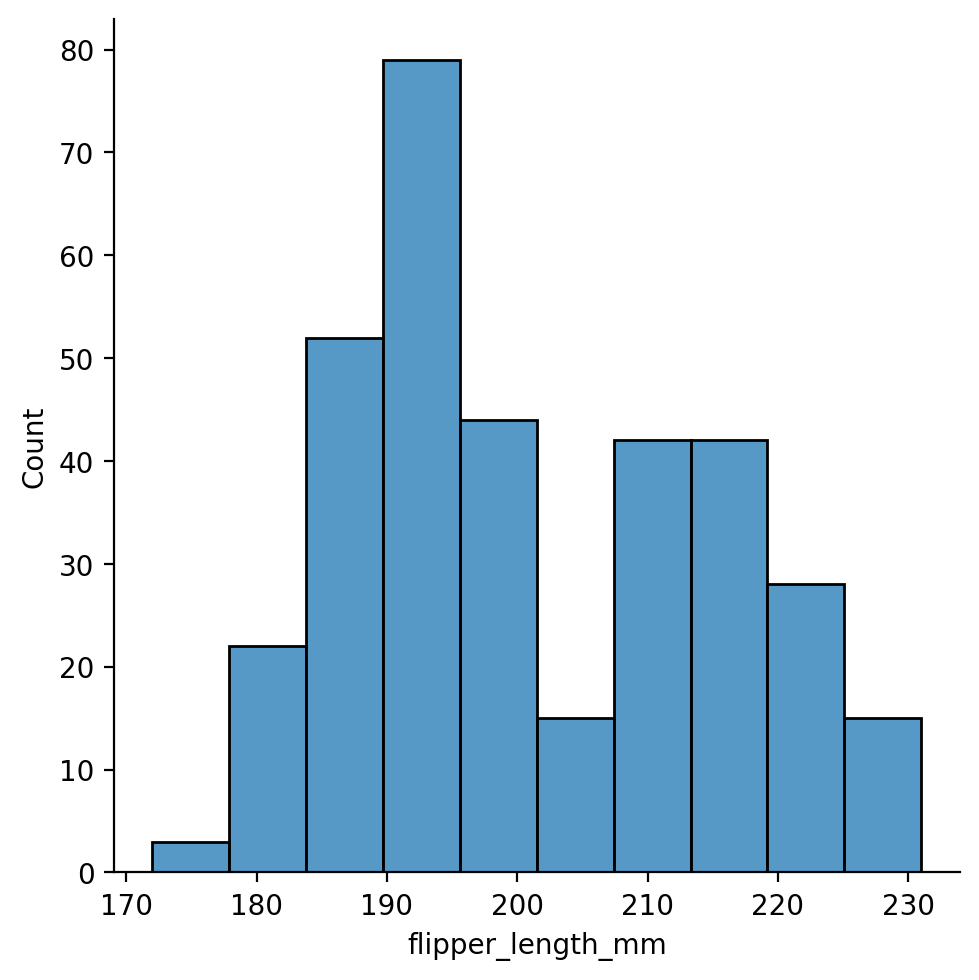

In [24]:
grid = sns.displot(
    data=penguins,
    kind='hist',
    x="flipper_length_mm",
)

This looks approximately *bi-modal* - there isn't a clear central peak in the distribution.

We can explore this further by increasing the amount of [binning the histogram uses](https://seaborn.pydata.org/tutorial/distributions.html#choosing-the-bin-size)

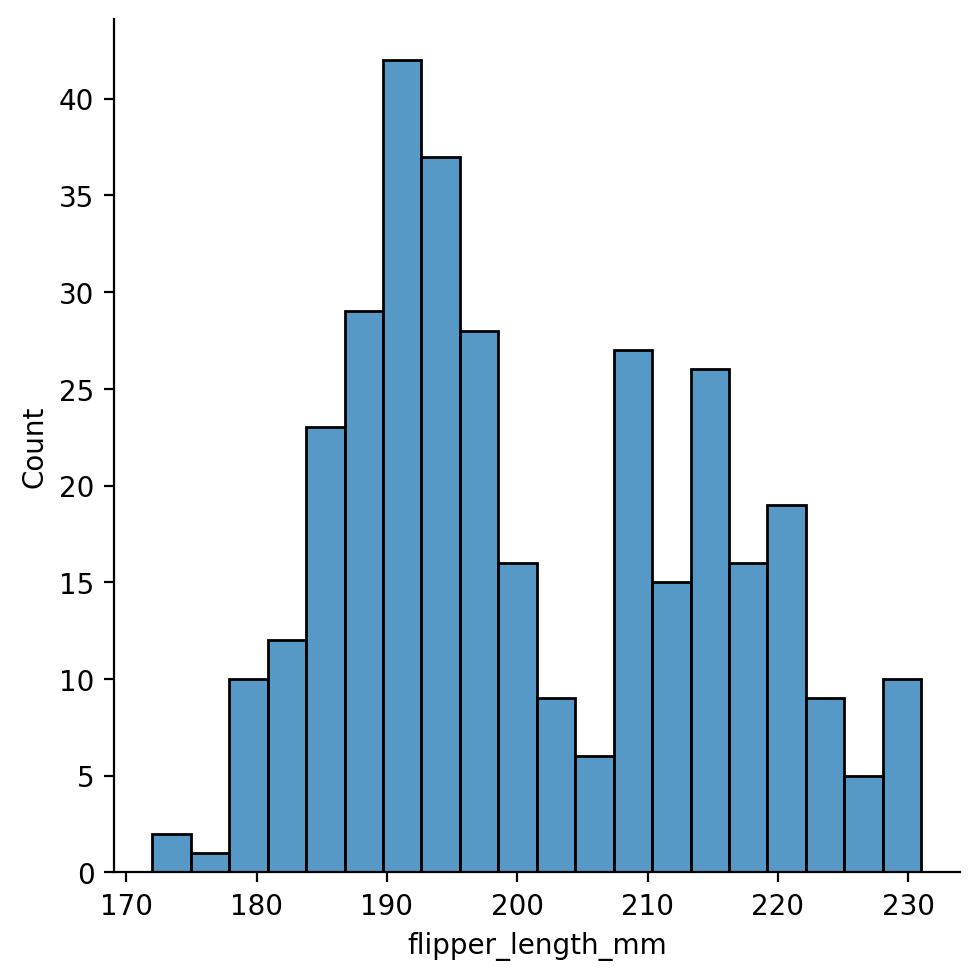

In [25]:
grid = sns.displot(
    data=penguins,
    kind='hist',
    x="flipper_length_mm",
    binwidth=3,
)

We can also switch to `kind="kde"` to try to better visualize the shape of the data using [kernel-density-estimation](https://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation).

KDE will make some assumptions about your data to "smooth" the histograms and make the "shape" of the distribution more visually apparent:  

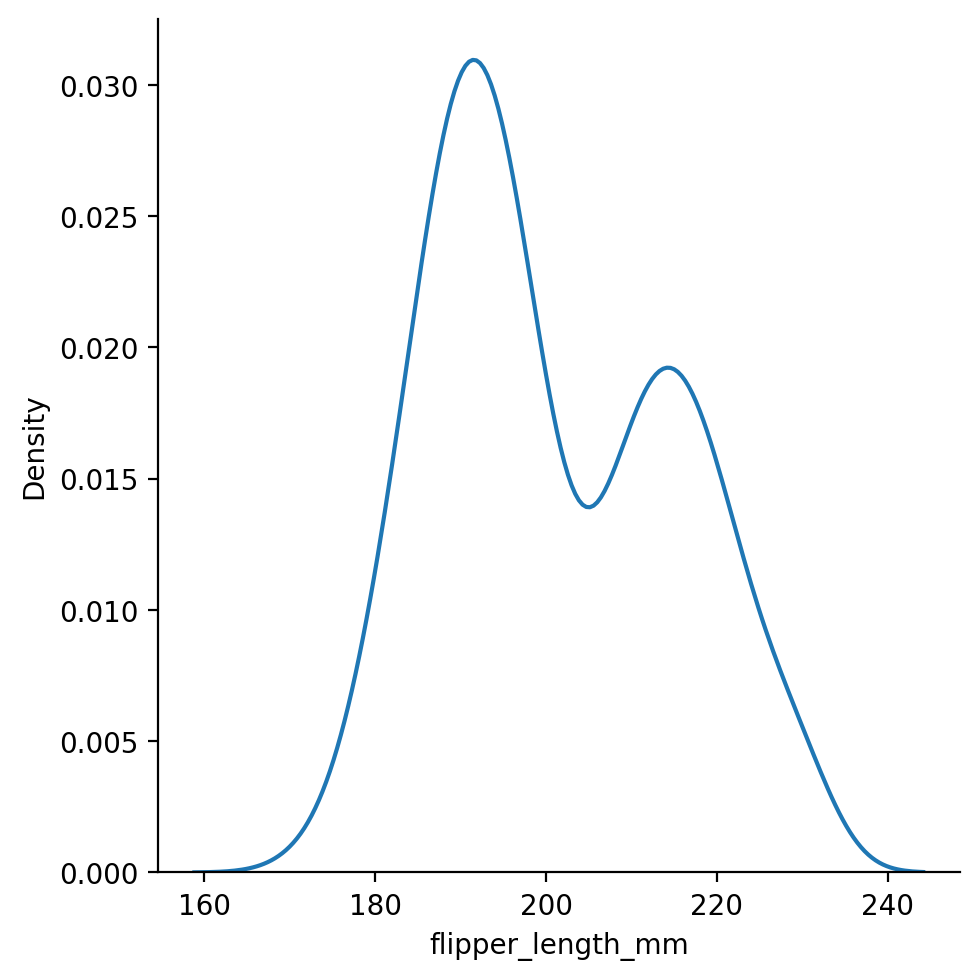

In [26]:
grid = sns.displot(
    data=penguins,
    kind='kde',
    x="flipper_length_mm",
)

It's important to play with the amount of smoothing to make sure you're not missing a true pattern in the data or artifically manufactoring a false one - heck out this [guide](https://seaborn.pydata.org/tutorial/distributions.html#choosing-the-smoothing-bandwidth) for more advice

We can control this using the `bw_adjust` argument in seaborn:

Too little and the plot is hard to read and we might as well use a histogram:

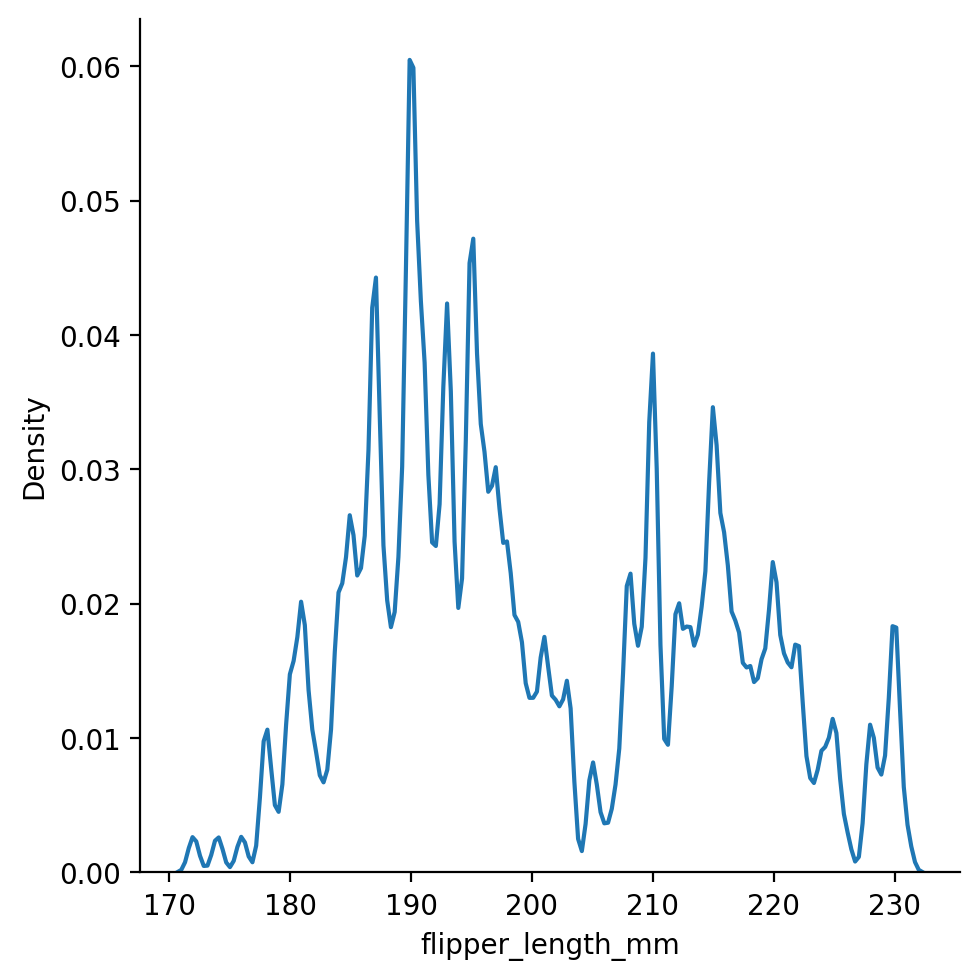

In [27]:
grid = sns.displot(
    data=penguins,
    kind='kde',
    x="flipper_length_mm",
    bw_adjust=.1
)

Too much and we'll miss the **bi-modal** distribution!

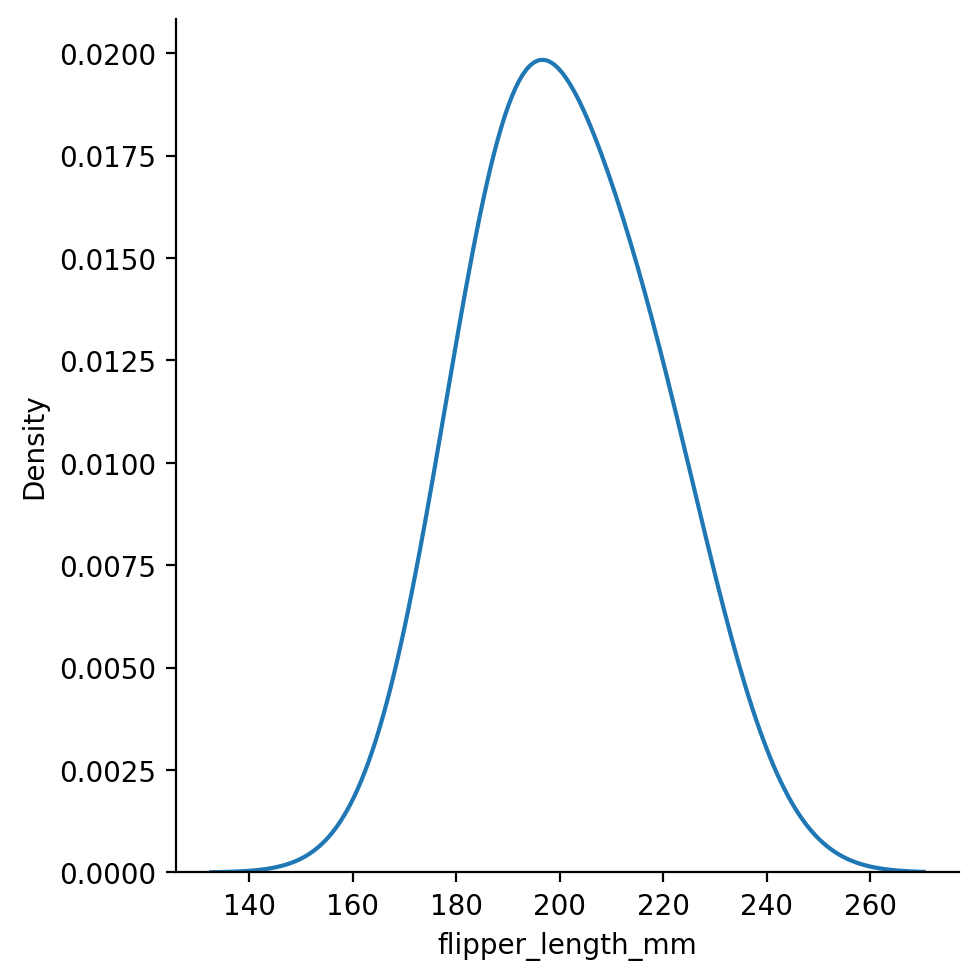

In [28]:
grid = sns.displot(
    data=penguins,
    kind='kde',
    x="flipper_length_mm",
    bw_adjust=3
)

Like with `sns.relplot`, we can split up the data to inspect how distributions differ by sex and species.

Let's create a histogram again, mapping `hue` to sex and `col` to species.

We can use `multiple='stack'` to make overlapping histogram values a bit easier to read:

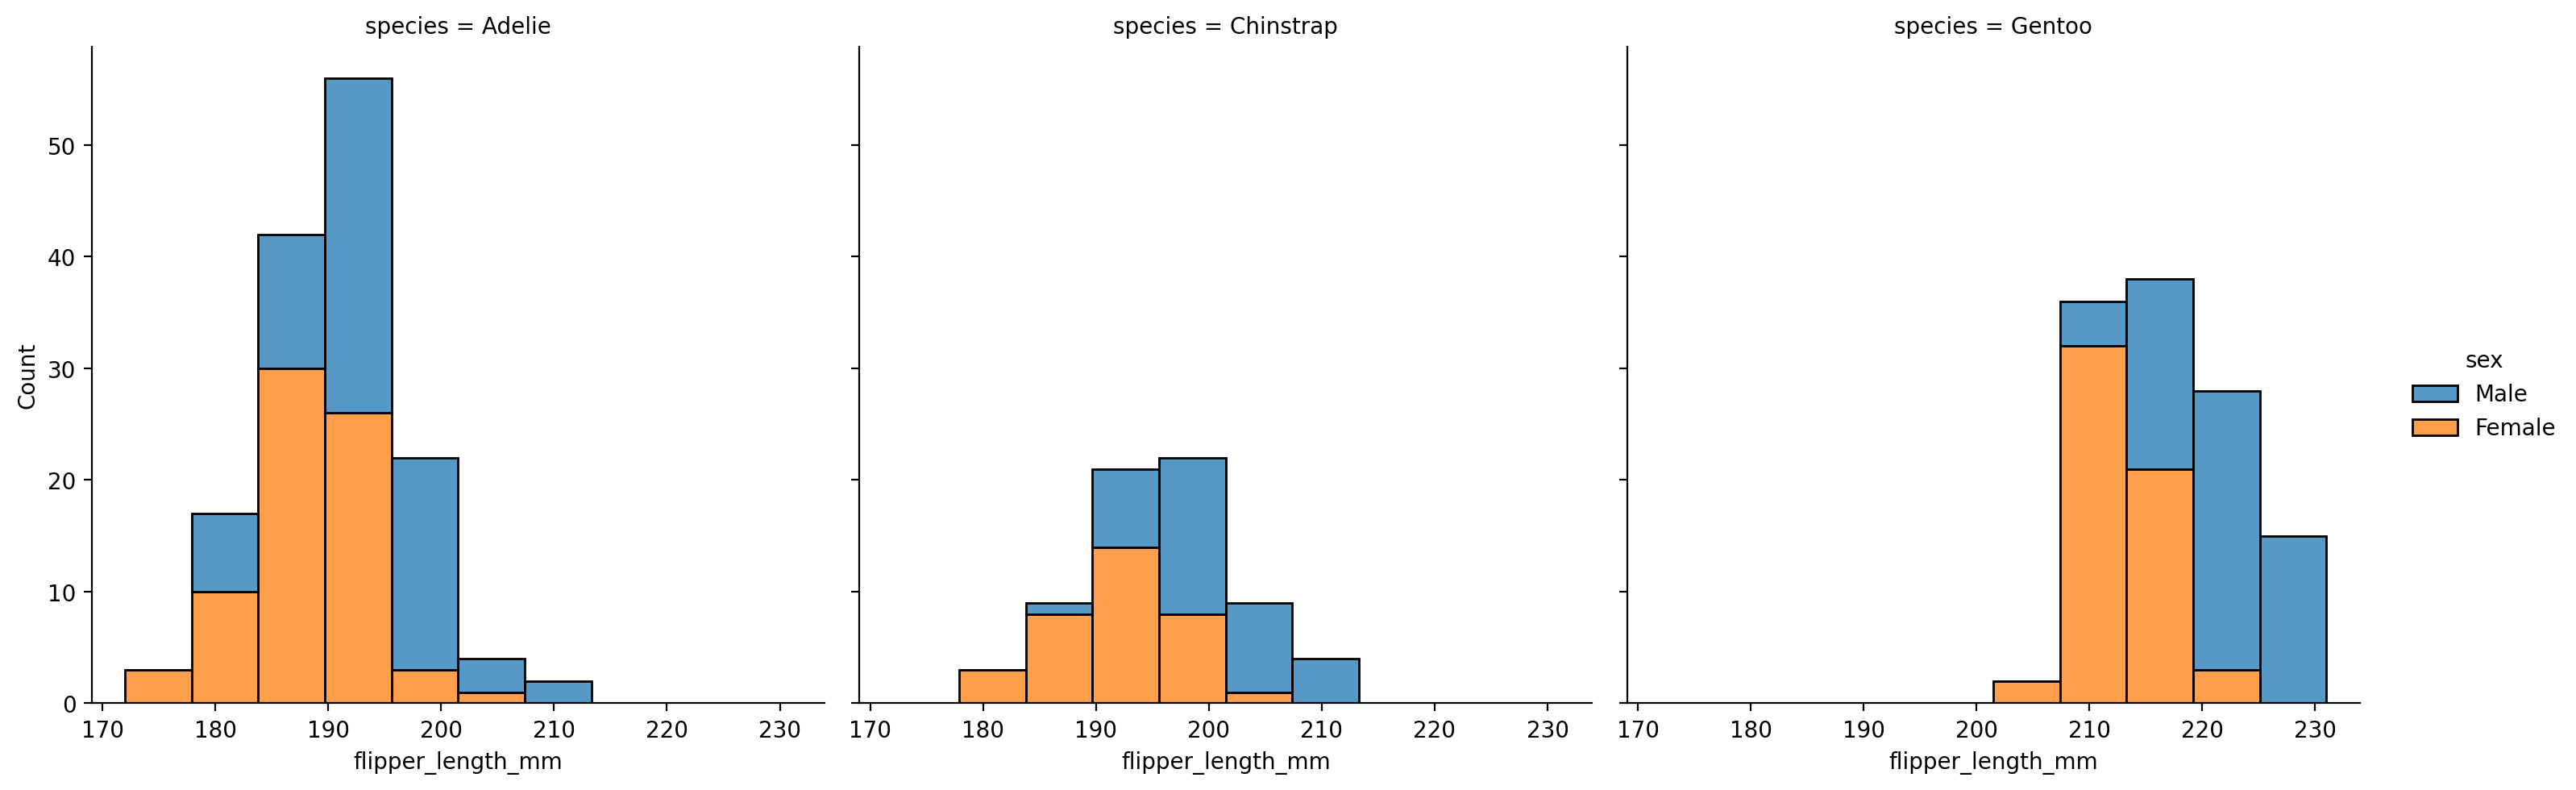

In [29]:
grid = sns.displot(
    data=penguins,
    kind='hist',
    multiple='stack',
    x="flipper_length_mm",
    hue="sex",
    col="species"
)

### Bi-variate distributions (two-variables)

`sns.displot` also has the neat ability to allow us to the distributions of **two variables** - which is kind of like a "3-dimensional histogram".

This can be a another great way to explore the distributions of different *numeric* variables overlap:

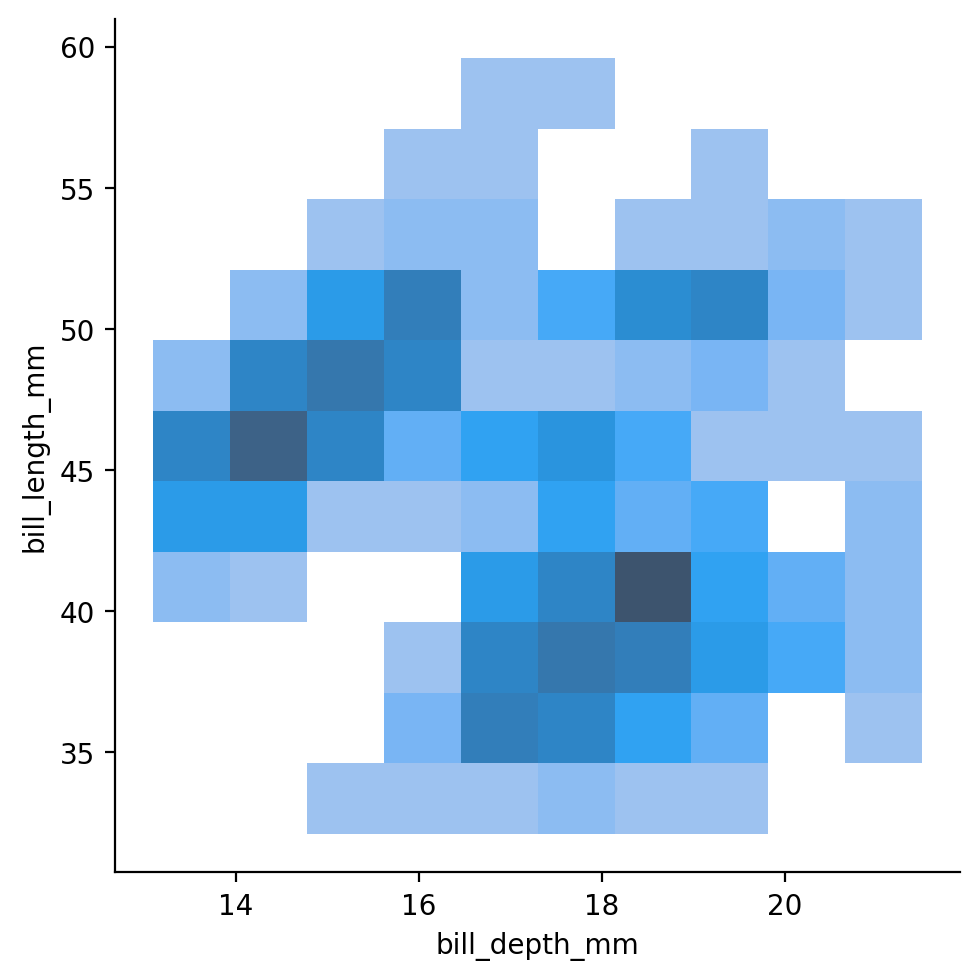

In [30]:
grid = sns.displot(
    data=penguins,
    kind='hist',
    x="bill_depth_mm",
    y="bill_length_mm",
)

And we can split this out by other non-numeric variables like before:

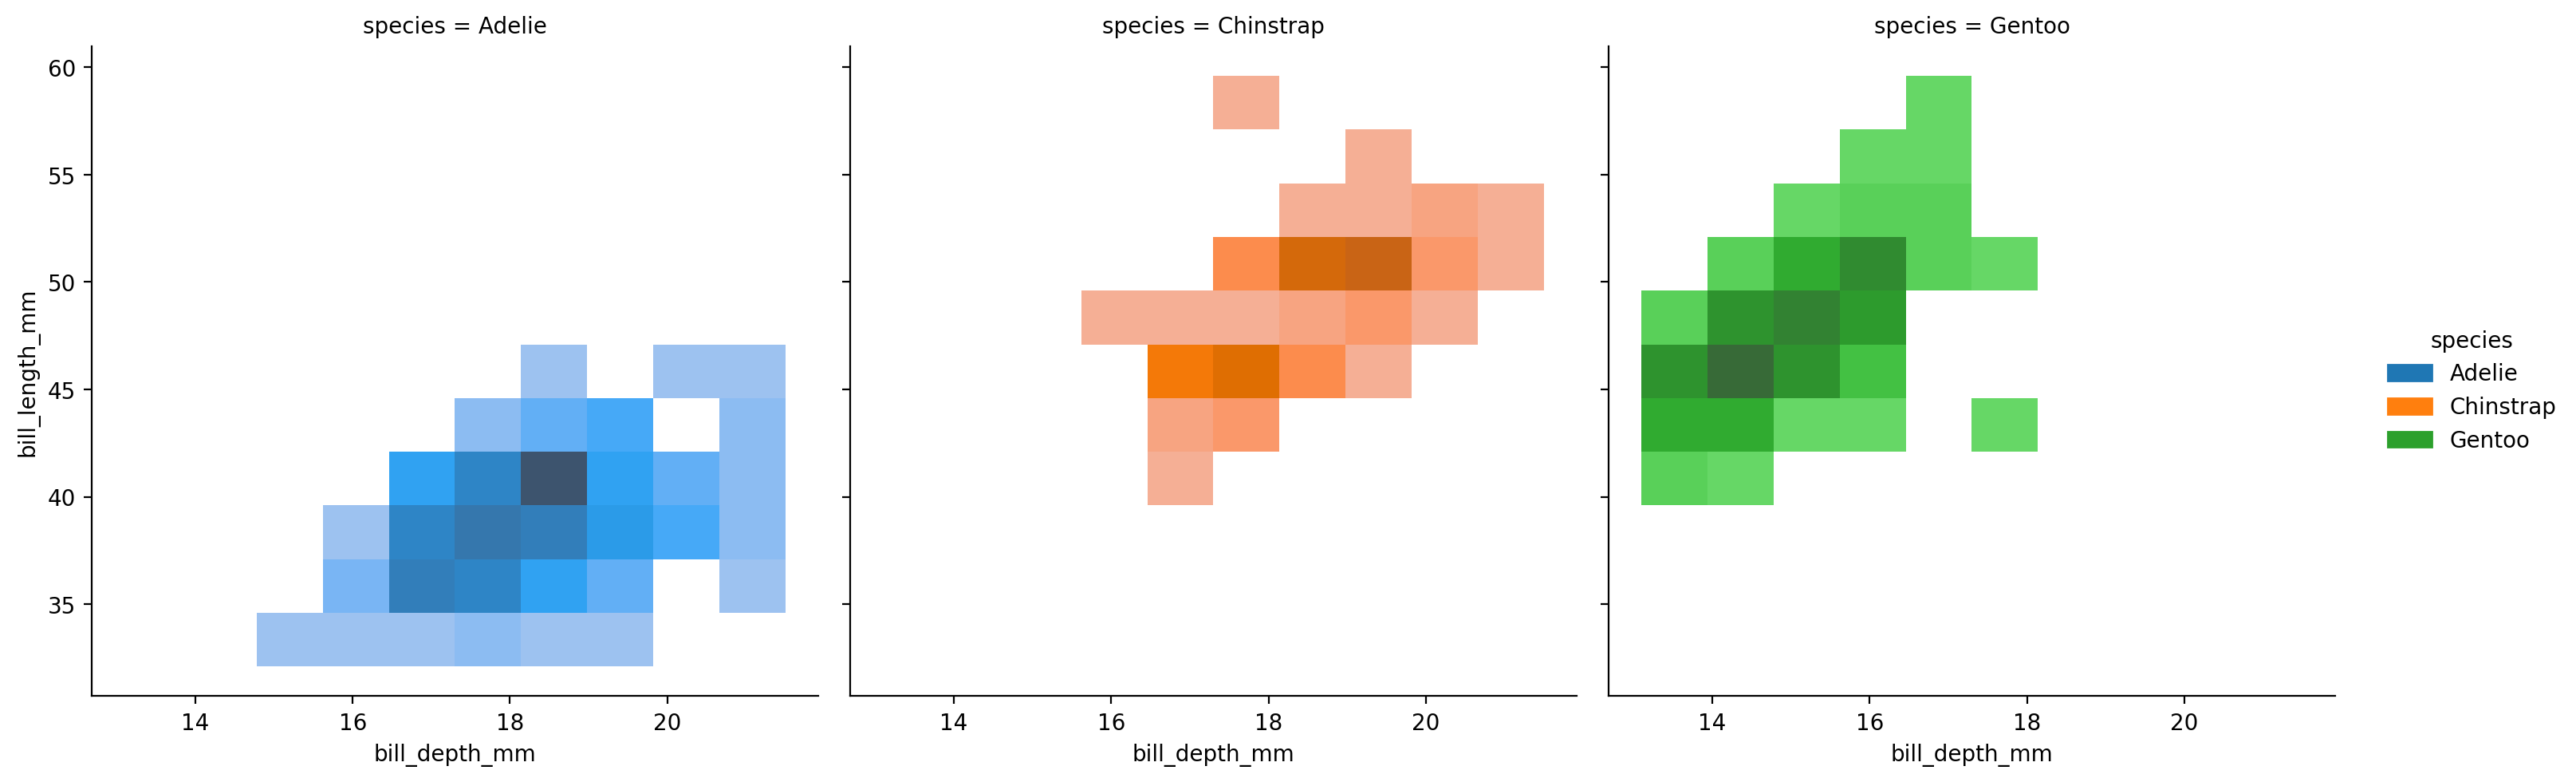

In [31]:
grid = sns.displot(
    data=penguins,
    kind='hist',
    x="bill_depth_mm",
    y="bill_length_mm",
    hue='species',
    col='species'
)

Using `kind="kde"` smooths out the bins of our bi-variate histograms, which can sometimes make it easier to see the overall "shape" of the bi-variate distributions


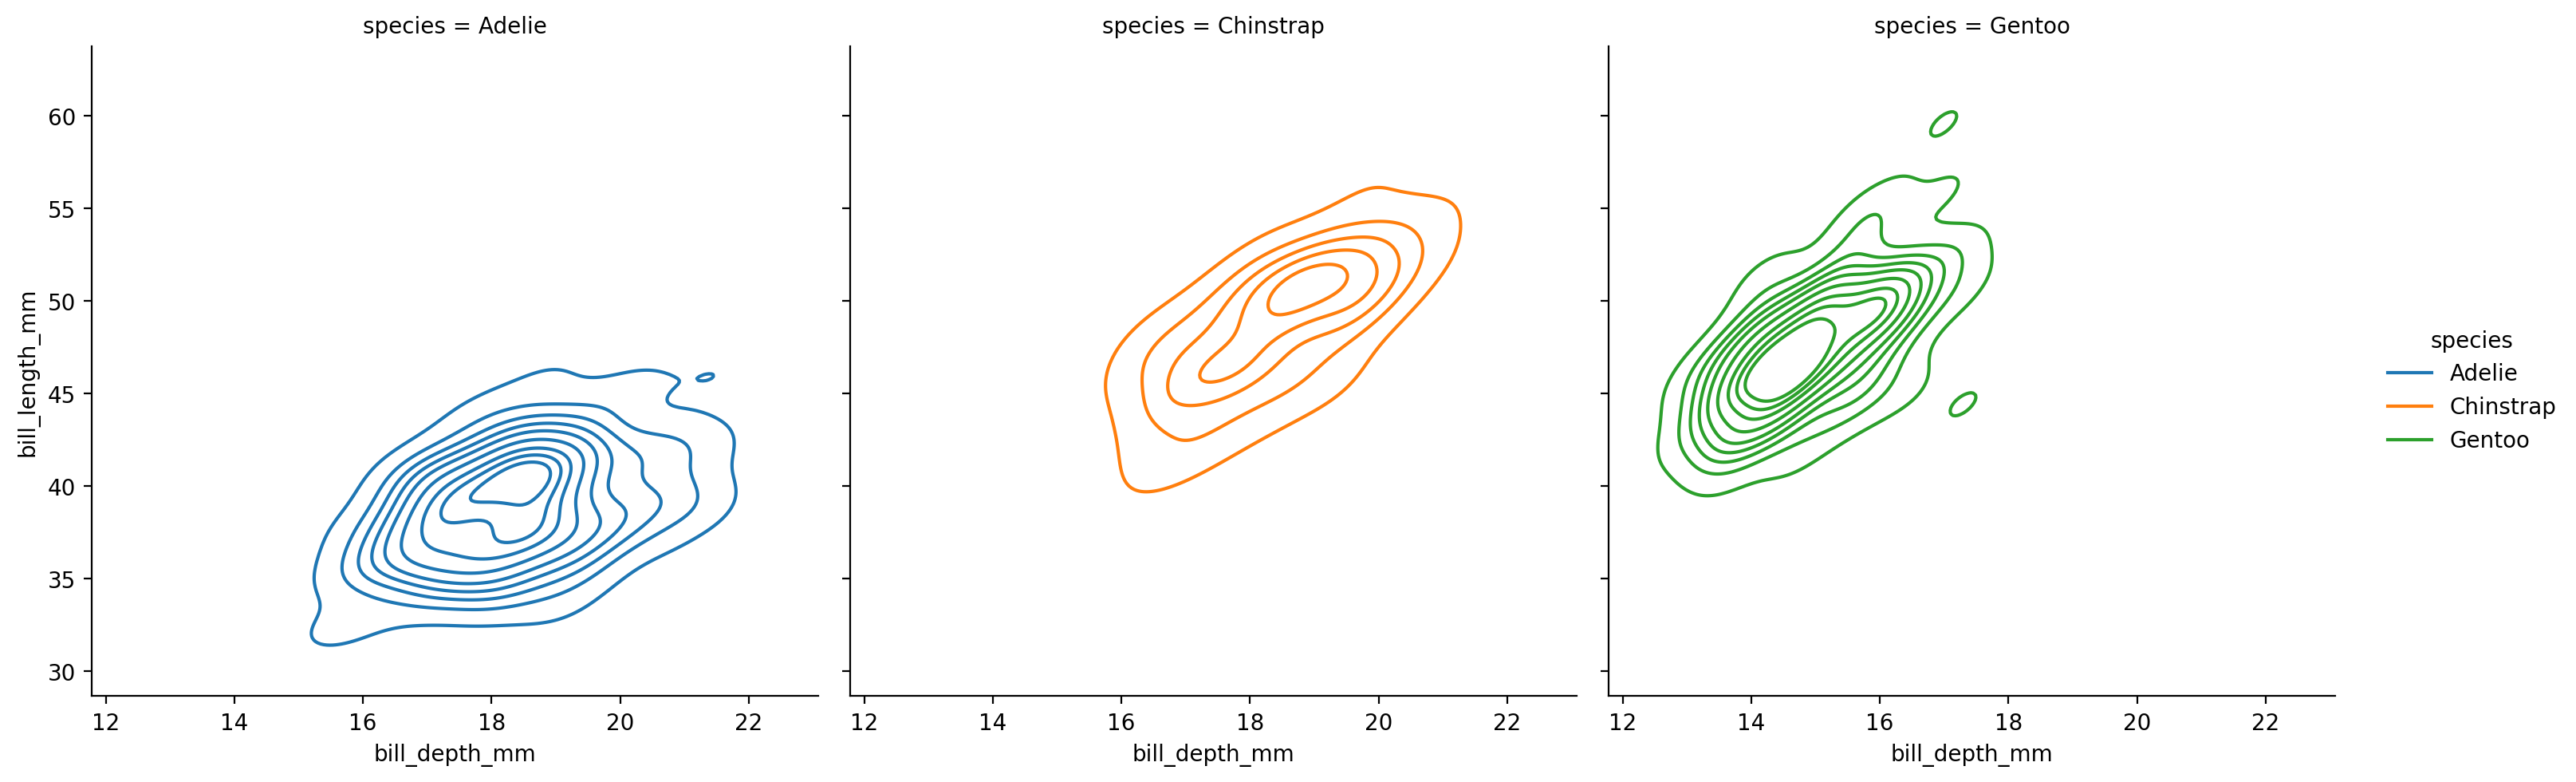

In [32]:
grid = sns.displot(
    data=penguins,
    kind='kde',
    x="bill_depth_mm",
    y="bill_length_mm",
    hue='species',
    col='species'
)

We'll get rid of `col` to keep things simpler and use `fill=True` to make the plots opaque:

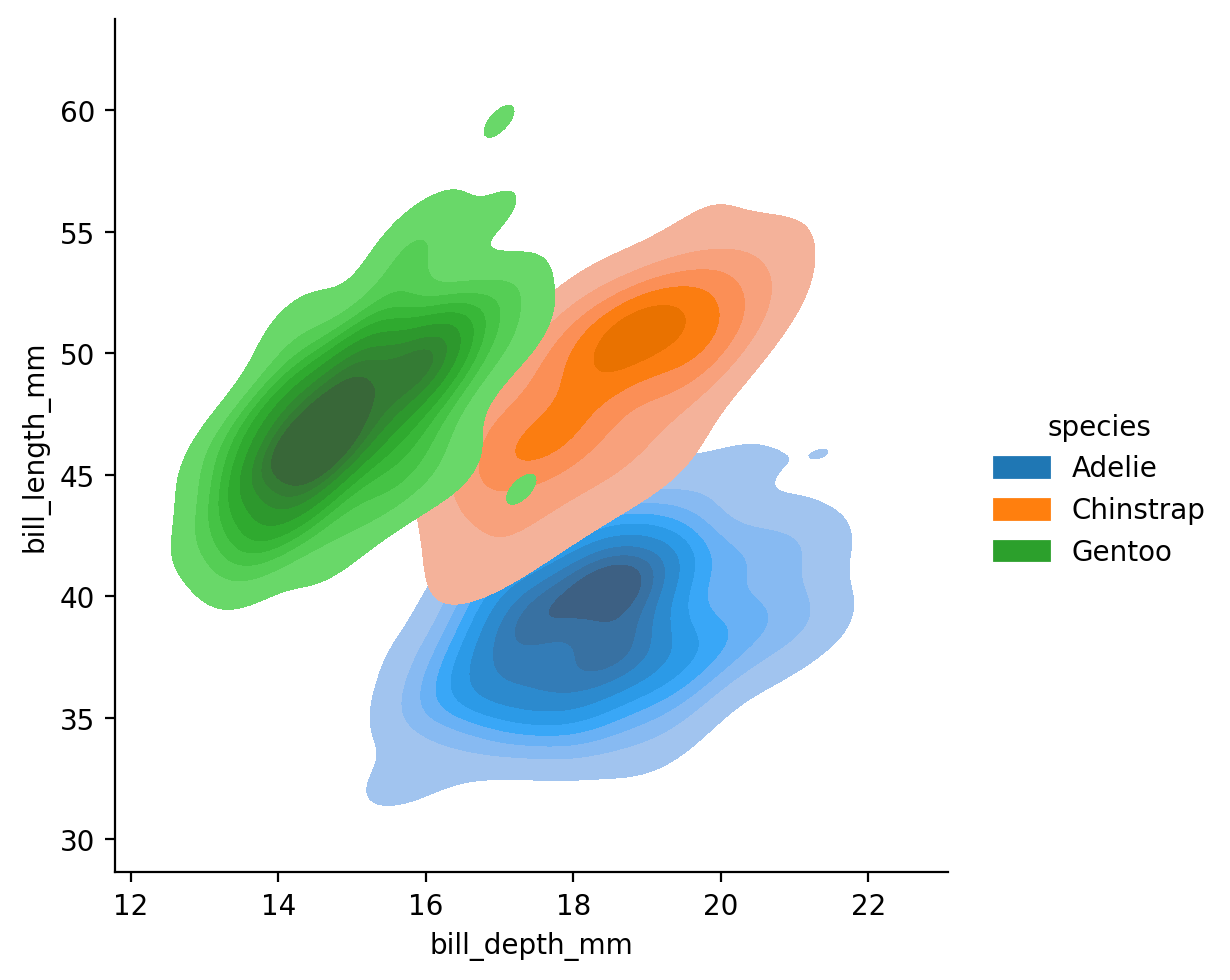

In [33]:
grid = sns.displot(
    data=penguins,
    kind='kde',
    x="bill_depth_mm",
    y="bill_length_mm",
    hue='species',
    fill=True
)

If we compare this to the scatterplot we looked before, we can see how the bi-variate distribution plot captures the **density** of our data - how many data points we observe for each value of x and y.

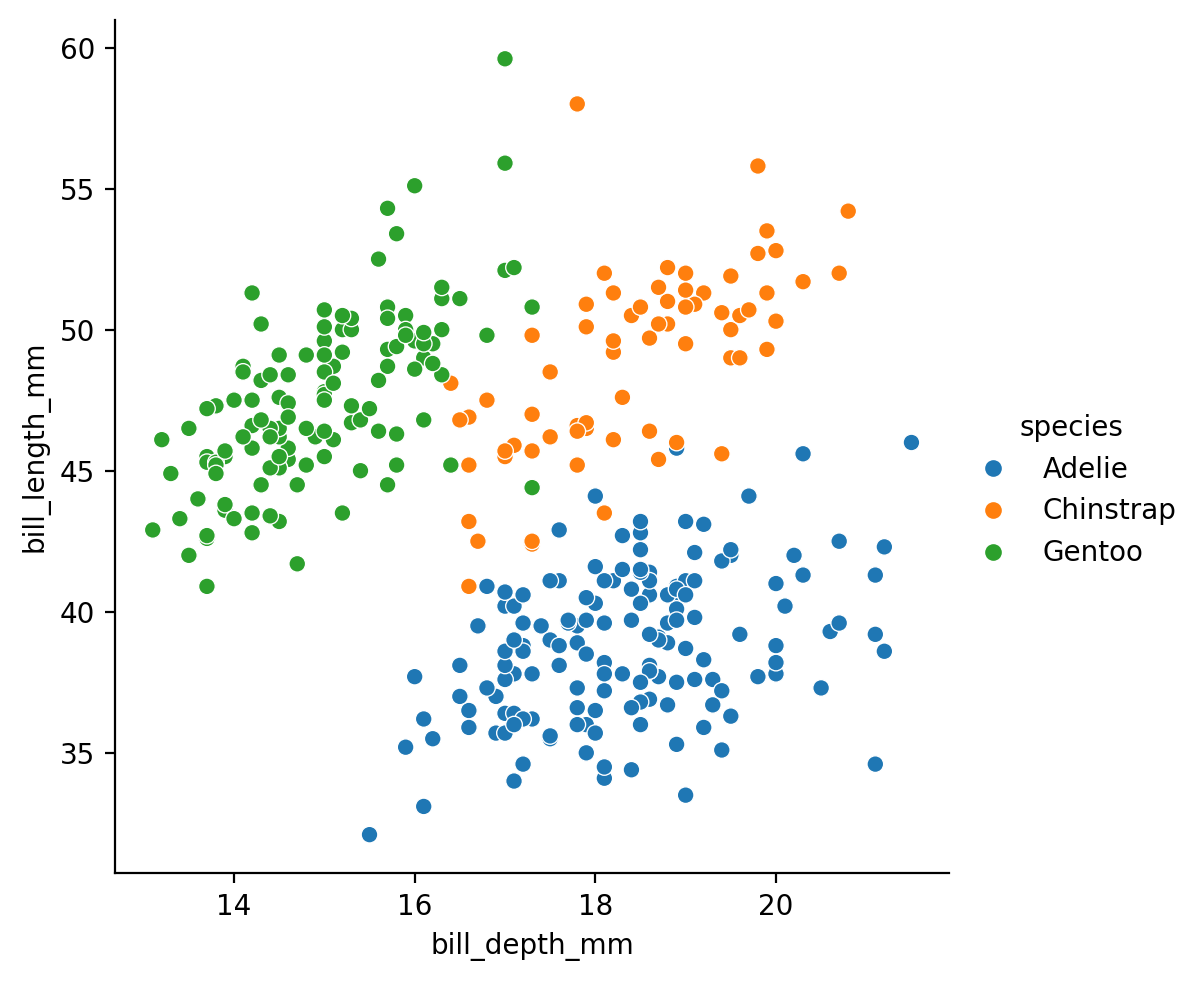

In [34]:
grid = sns.relplot(
    data=penguins,
    kind='scatter',
    x="bill_depth_mm",
    y="bill_length_mm",
    hue='species',
)

Seaborn can also make **[empirical cumulative distribution plots](https://seaborn.pydata.org/tutorial/distributions.html#empirical-cumulative-distributions)**:  
a monotonically-increasing curve through each datapoint such that the height of the curve reflects the proportion of observations with a smaller value.

ECDF plots take a bit of time to get used to interpretting but they have 1 key advantage over histograms and KDEs: no binning/smoothing.

This lets you see each datapoint's contribution to the distribution and shifts along the x-axis make it easier to see how different distributions compare:


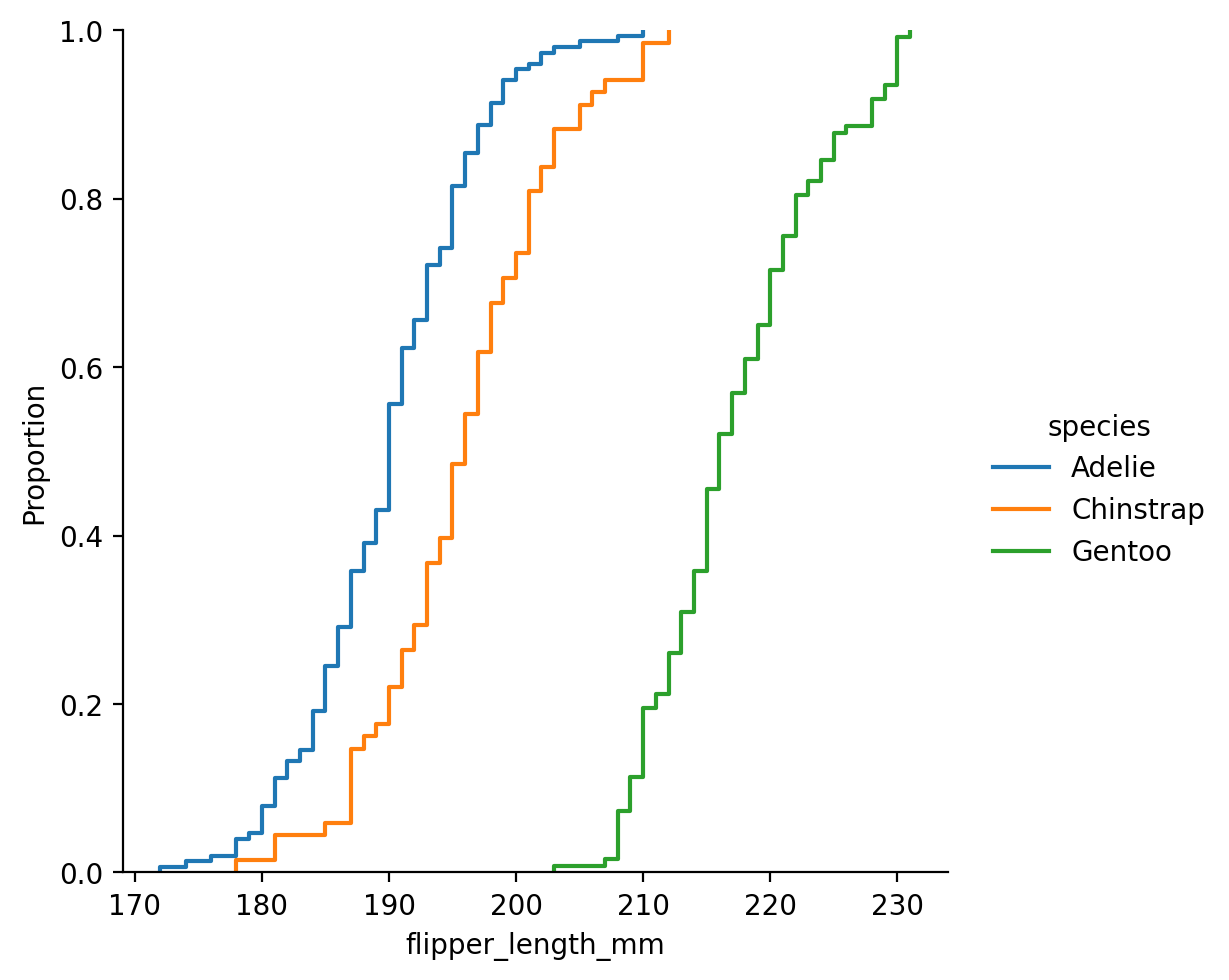

In [35]:
grid = sns.displot(
    data=penguins,
    kind='ecdf',
    x='flipper_length_mm',
    hue='species',
)

ECDFs can make it a bit easier to see things that are more obscured in a histogram:

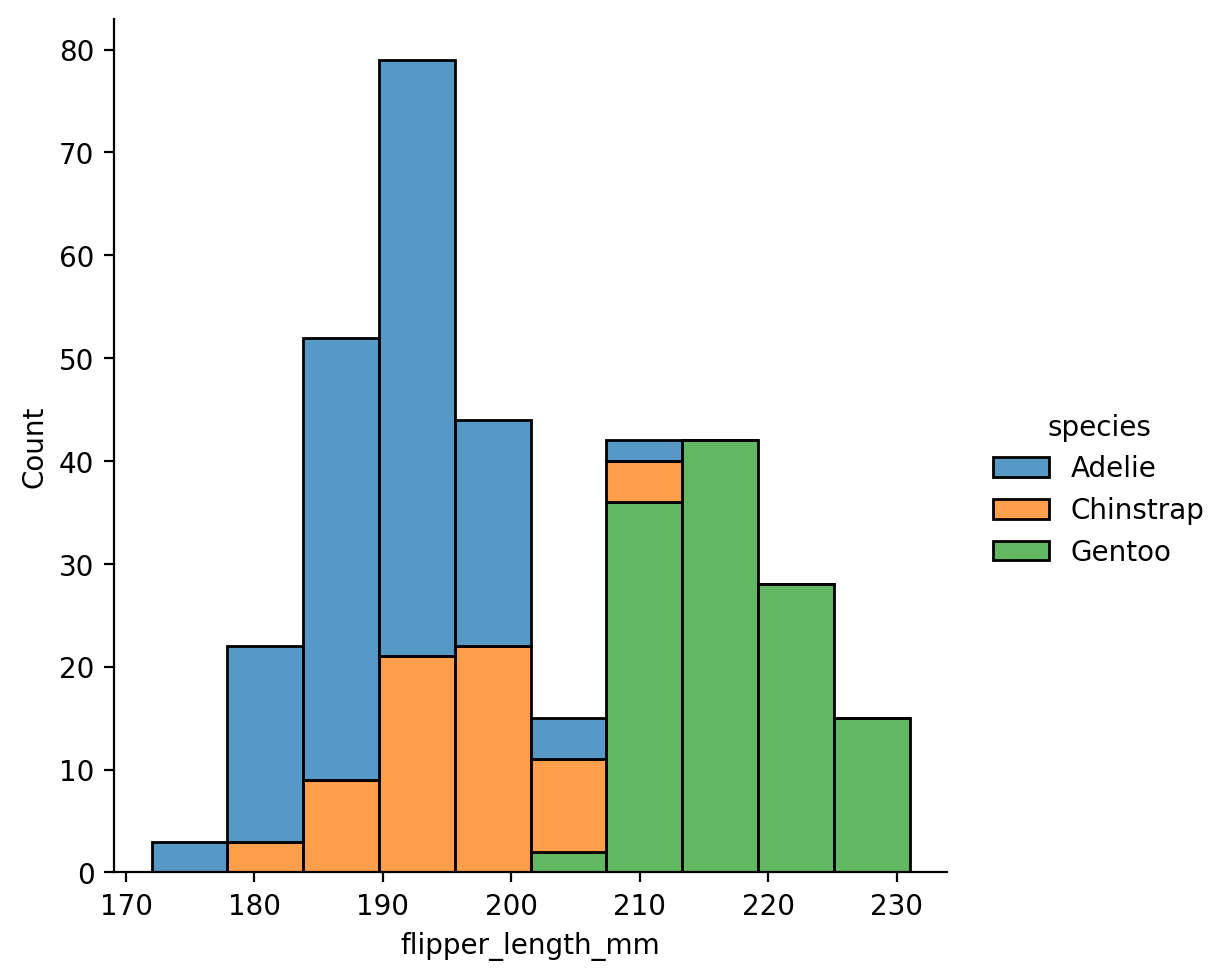

In [36]:
grid = sns.displot(
    data=penguins,
    kind='hist',
    multiple='stack',
    x='flipper_length_mm',
    hue='species',
)

## EDA - Visualizing & Summarizing Categories

So far we've seen how `sns.relplot` allows to visualize *relationships* between numeric columns and `sns.displot` allows you visualize the *distributions* of one or two variables.

In psychology research we often employ experimental designs with different "levels" of a categorical variable, e.g. conditions in an experiment. In situations like this, we're often *primarily* interested in **[visualizing or summarizing by category level](https://seaborn.pydata.org/tutorial/categorical.html)**. 

In other words, we're interested in the relationship between 2 variables, where one is *numeric* and the other is *non-numeric* (categorical). In these situations we can use `sns.catplot`  

Like before this also returns a `FacetGrid` and accepts a `kind` argument for any of the following options:

- `'strip'`: individual data points lined up by category
- `'swarm'`: same as `'strip'`, but easier to see if points are overlapping
- `'box'`: boxplots
- `'violin'`: violin plots - like boxplots, but with an estimate of the *density* of the data
- `'point'`: summary statistics by category represented as points
- `'bar'`: summary statistics by category represented as bars
- `'count'`: the number of observations in each category

Let's look at "swarmplot" of the bill lengths of penguins by species - which will allow us to see individual data points broken out by species.

 We'll map species to the `x` axis and `hue` and bill lengths to the `y` axis:

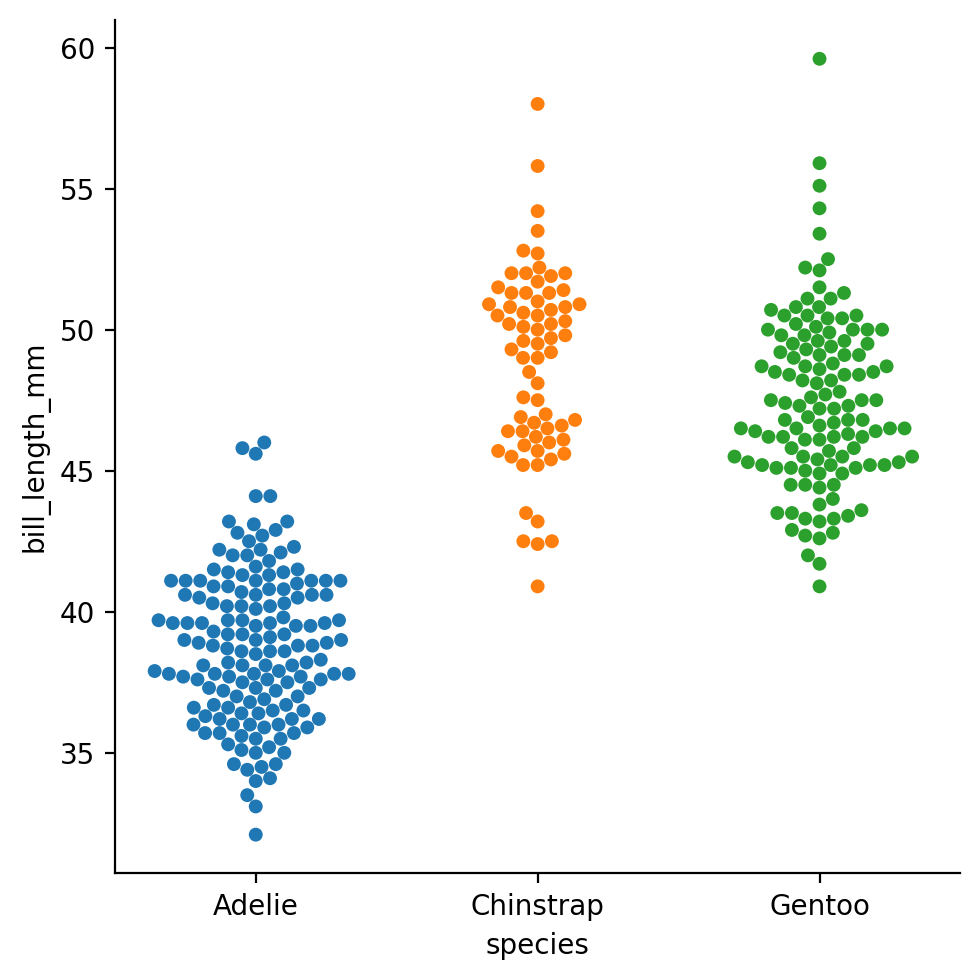

In [37]:
grid = sns.catplot(
    data=penguins,
    kind='swarm',
    x='species',
    hue='species',
    y='bill_length_mm'
)

Unlike a scatterplot, the x-axis now reflects the "levels" of our categorical variable instead of a *numeric* quantity; specifically each unique *species* of penguin

And we can further split this out by other category levels, like we did before with sex:

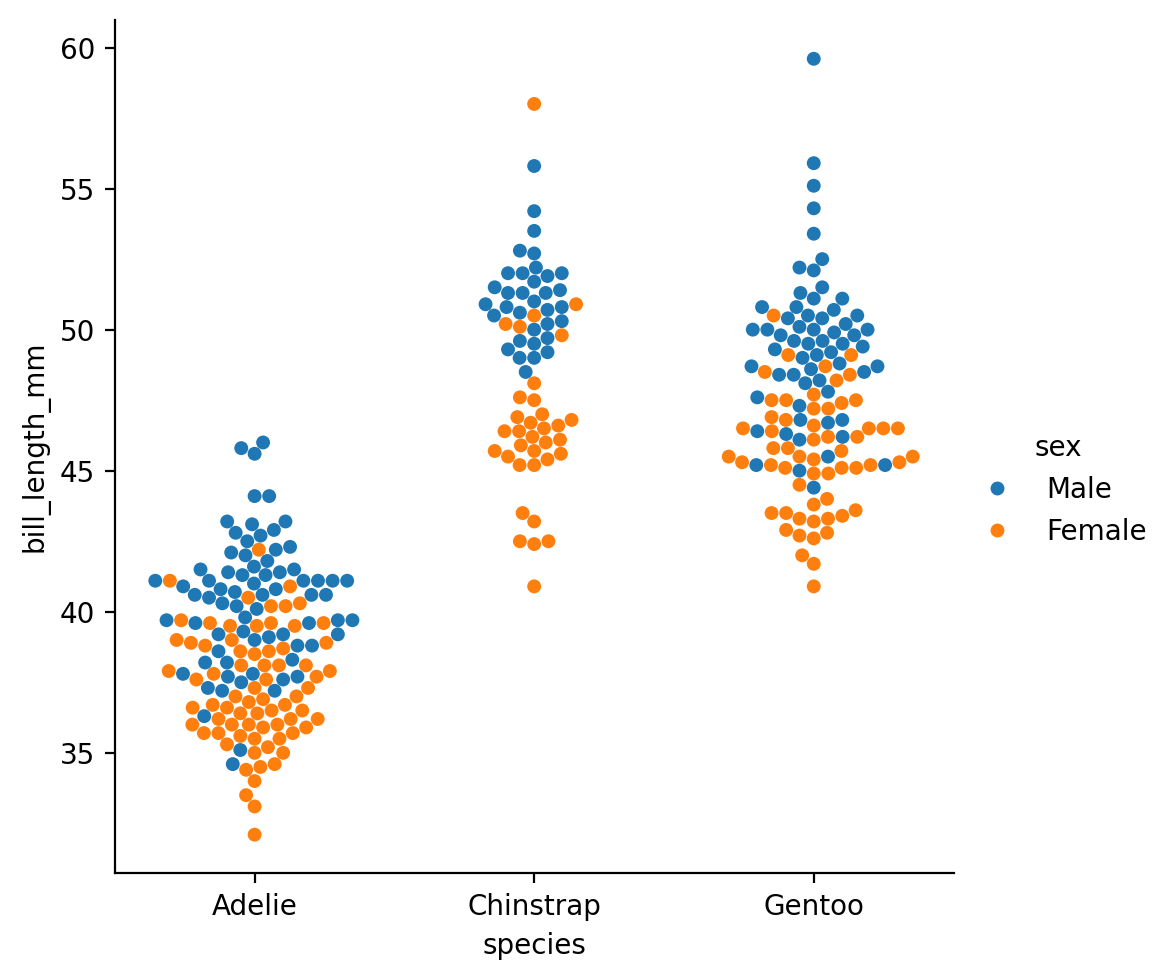

In [38]:
grid = sns.catplot(
    data=penguins,
    kind='swarm',
    x='species',
    hue='sex',
    y='bill_length_mm',
)

Or map sex across `col` instead:

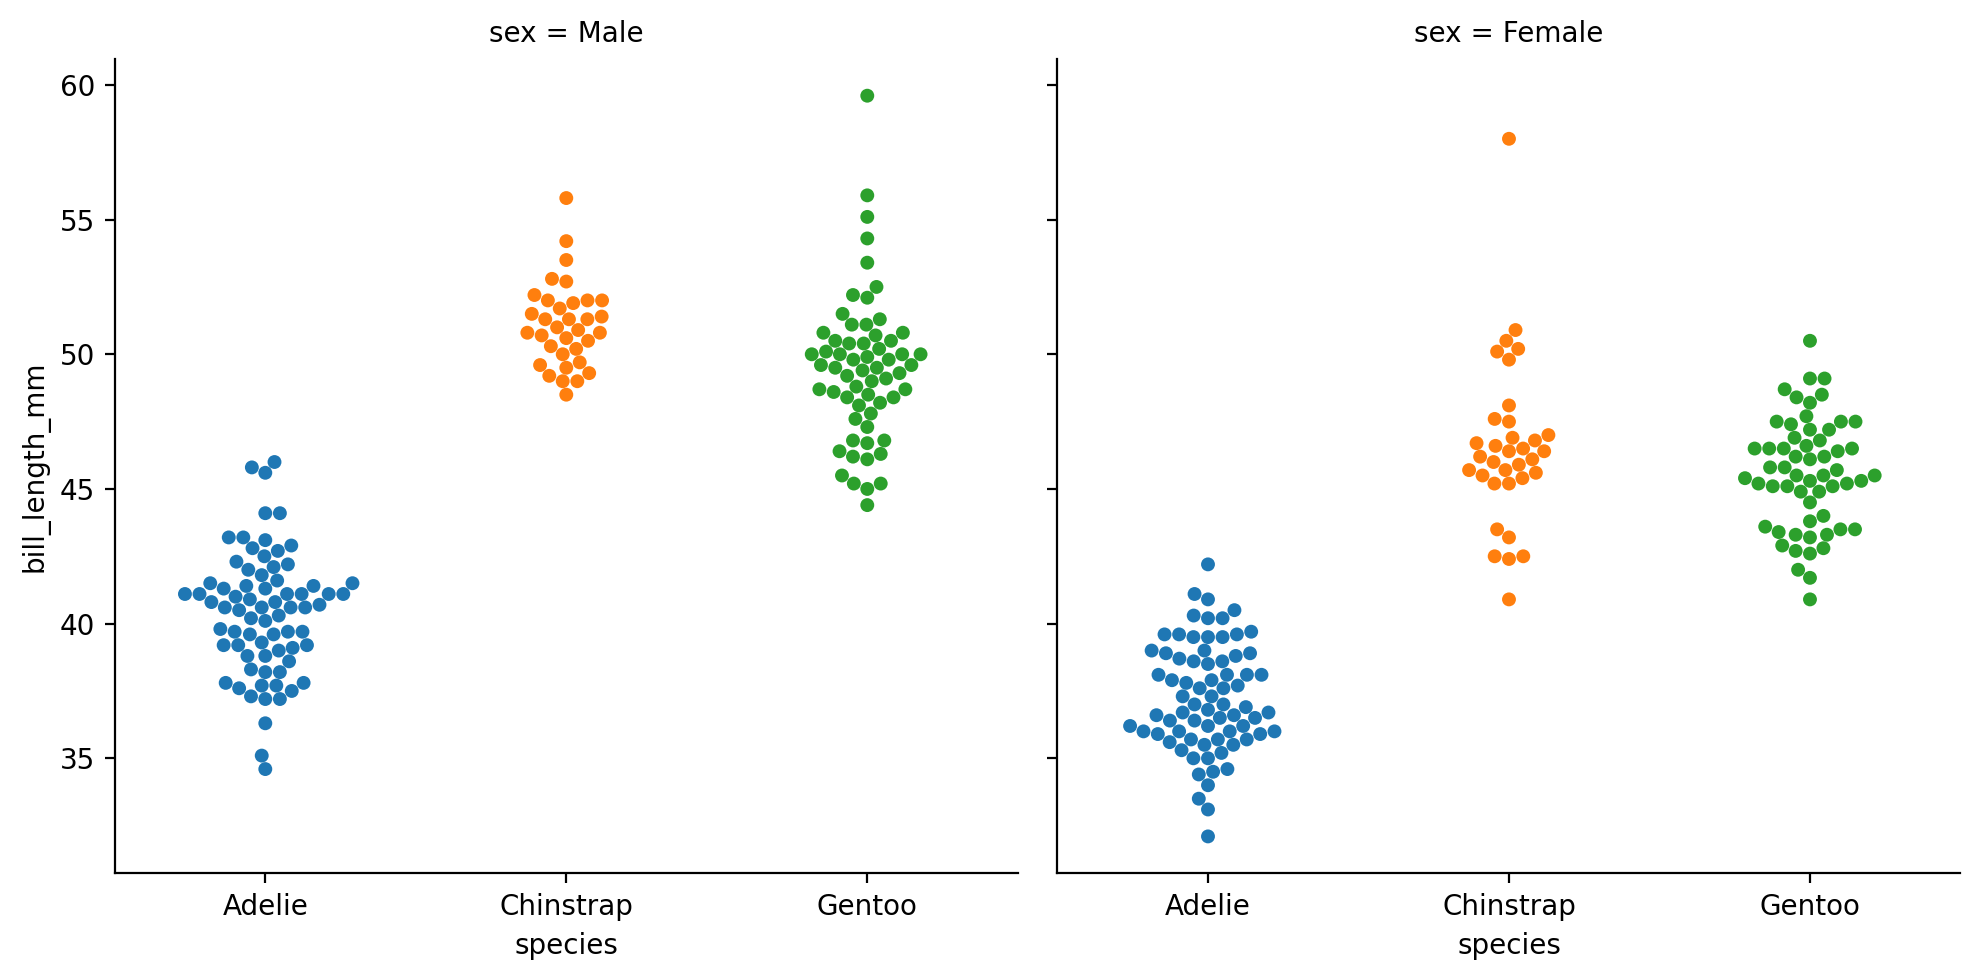

In [39]:
grid = sns.catplot(
    data=penguins,
    kind='swarm',
    x='species',
    hue='species',
    y='bill_length_mm',
    col='sex'
)

This kind of **categorical plot** makes it a bit easier to see what we noticed from our `sns.replot` earlier: that male Gentoos (green) seem to have longer bills on average than females

We can calculate **summaries** by category by swapping out to a `'barplot'`. This also gives a new `errorbar` argument that we can use to show standard deviation, standard error, or even boostrapped 95% confidence intervals that seaborn with *automatically* calculate for us!

For reference, here's [Seaborn's own guide to tweaking how errorbars are controlled](https://seaborn.pydata.org/tutorial/error_bars.html).

Let's also rearrange the mappings of our columns to make it easier to compare sexes by mean bill length *within* each species:

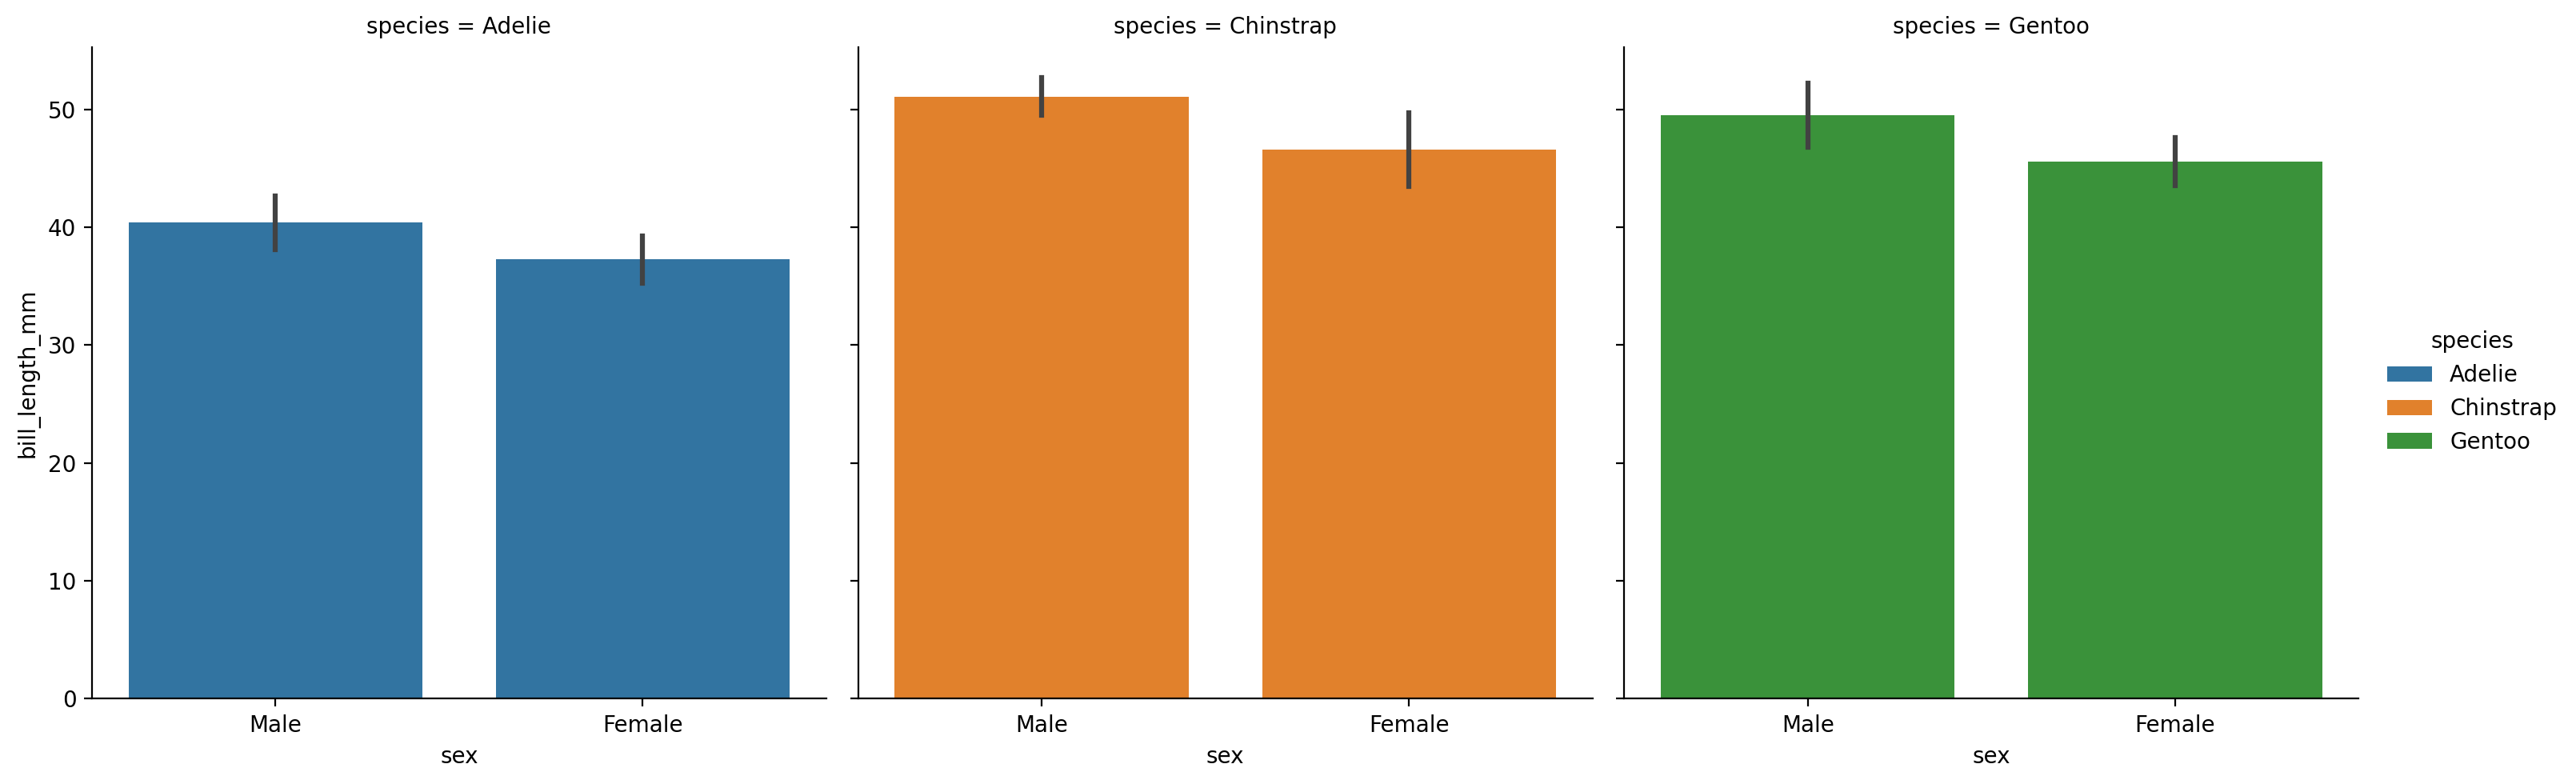

In [40]:
grid = sns.catplot(
    data=penguins,
    kind='bar',
    errorbar='sd', # standard deviation
    x='sex',
    y='bill_length_mm',
    hue='species',
    col='species'
)

For any `sns.catplot` that summarizes data, we can control what how the summary happens using the `estimator` argument, which takes a function that calculates a summary statistic. 

For example, we could visualize the median instead by setting the estimator to `np.median` function from NumPy.

Let's try that now and swap out the barplot for a pointplot with standard-error bars around the median:

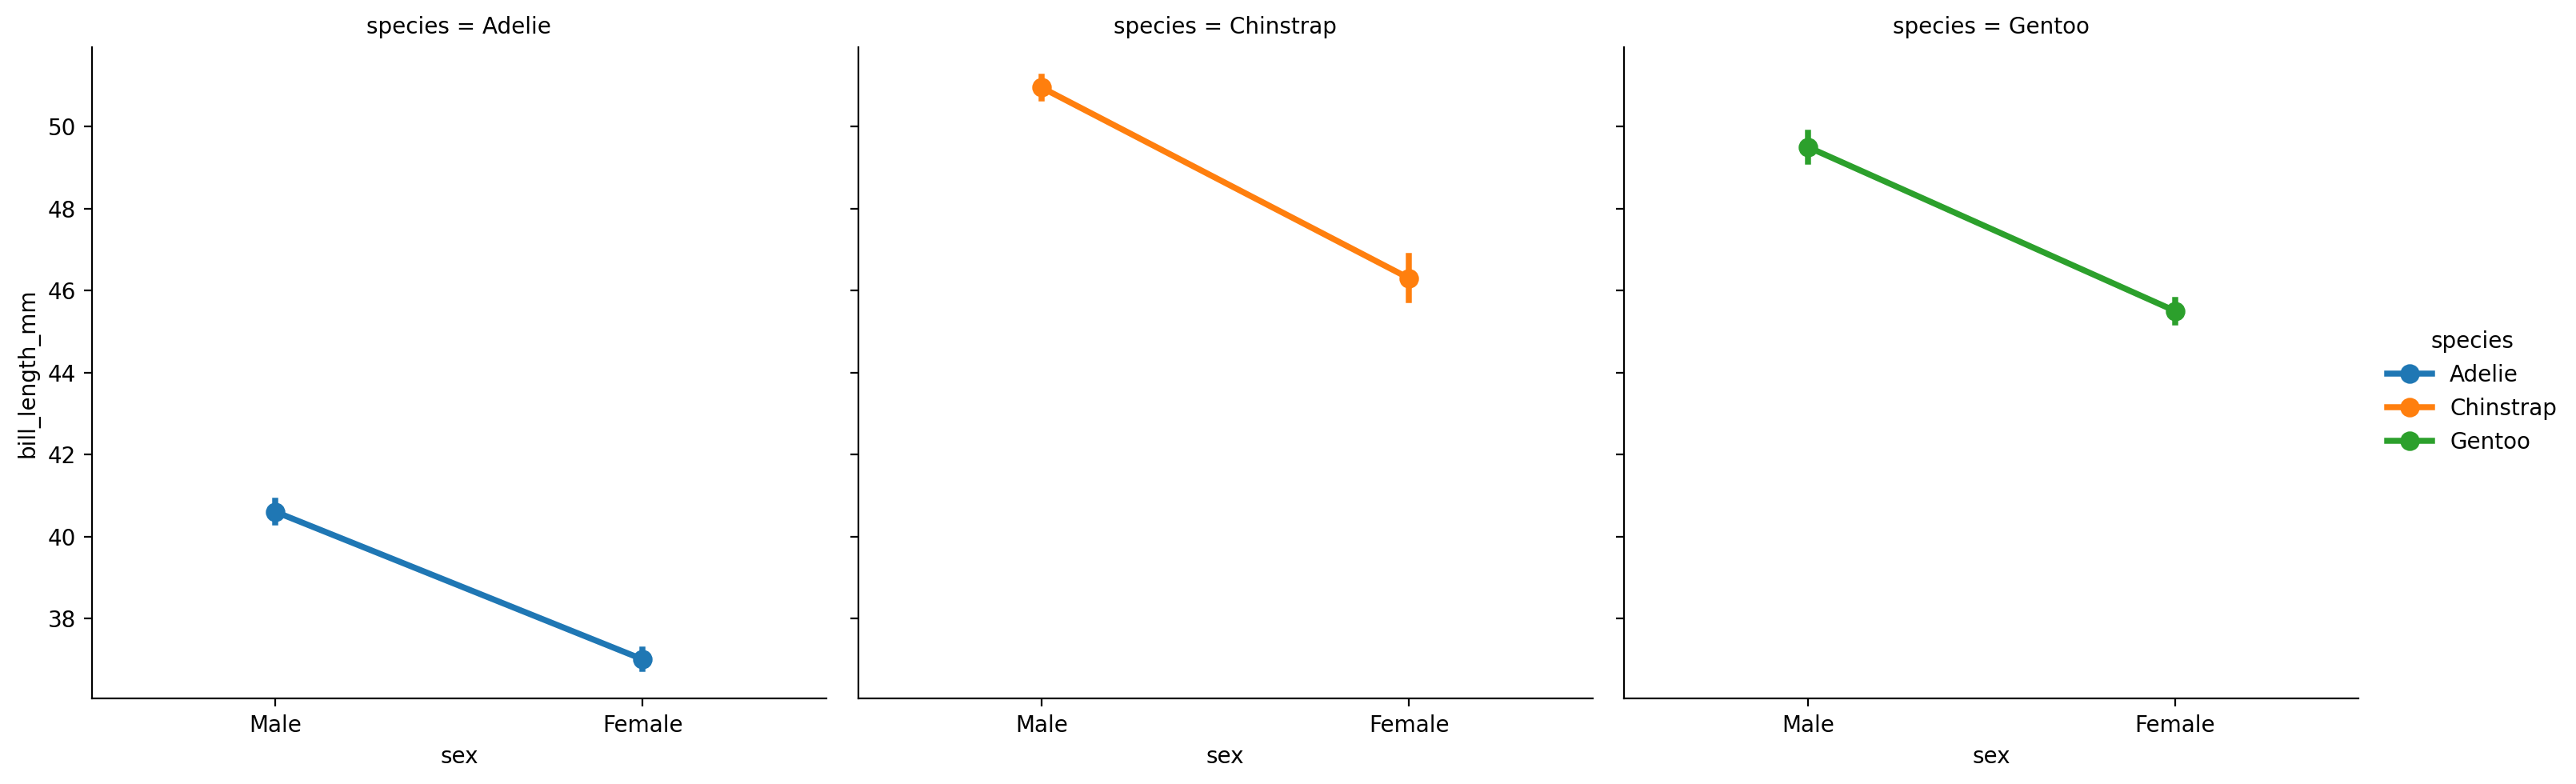

In [41]:
import numpy as np # import numpy

grid = sns.catplot(
    data=penguins,
    kind='point',  # point-plot
    errorbar='se', # standard-error
    x='sex',
    y='bill_length_mm',
    hue='species',
    col='species',
    estimator= np.median # use median as the summary statistic
)

Barplots and pointplots are great for summarizing data quickly, but they obscure the distribution of the data. Boxplots are often a good compromise between the two:

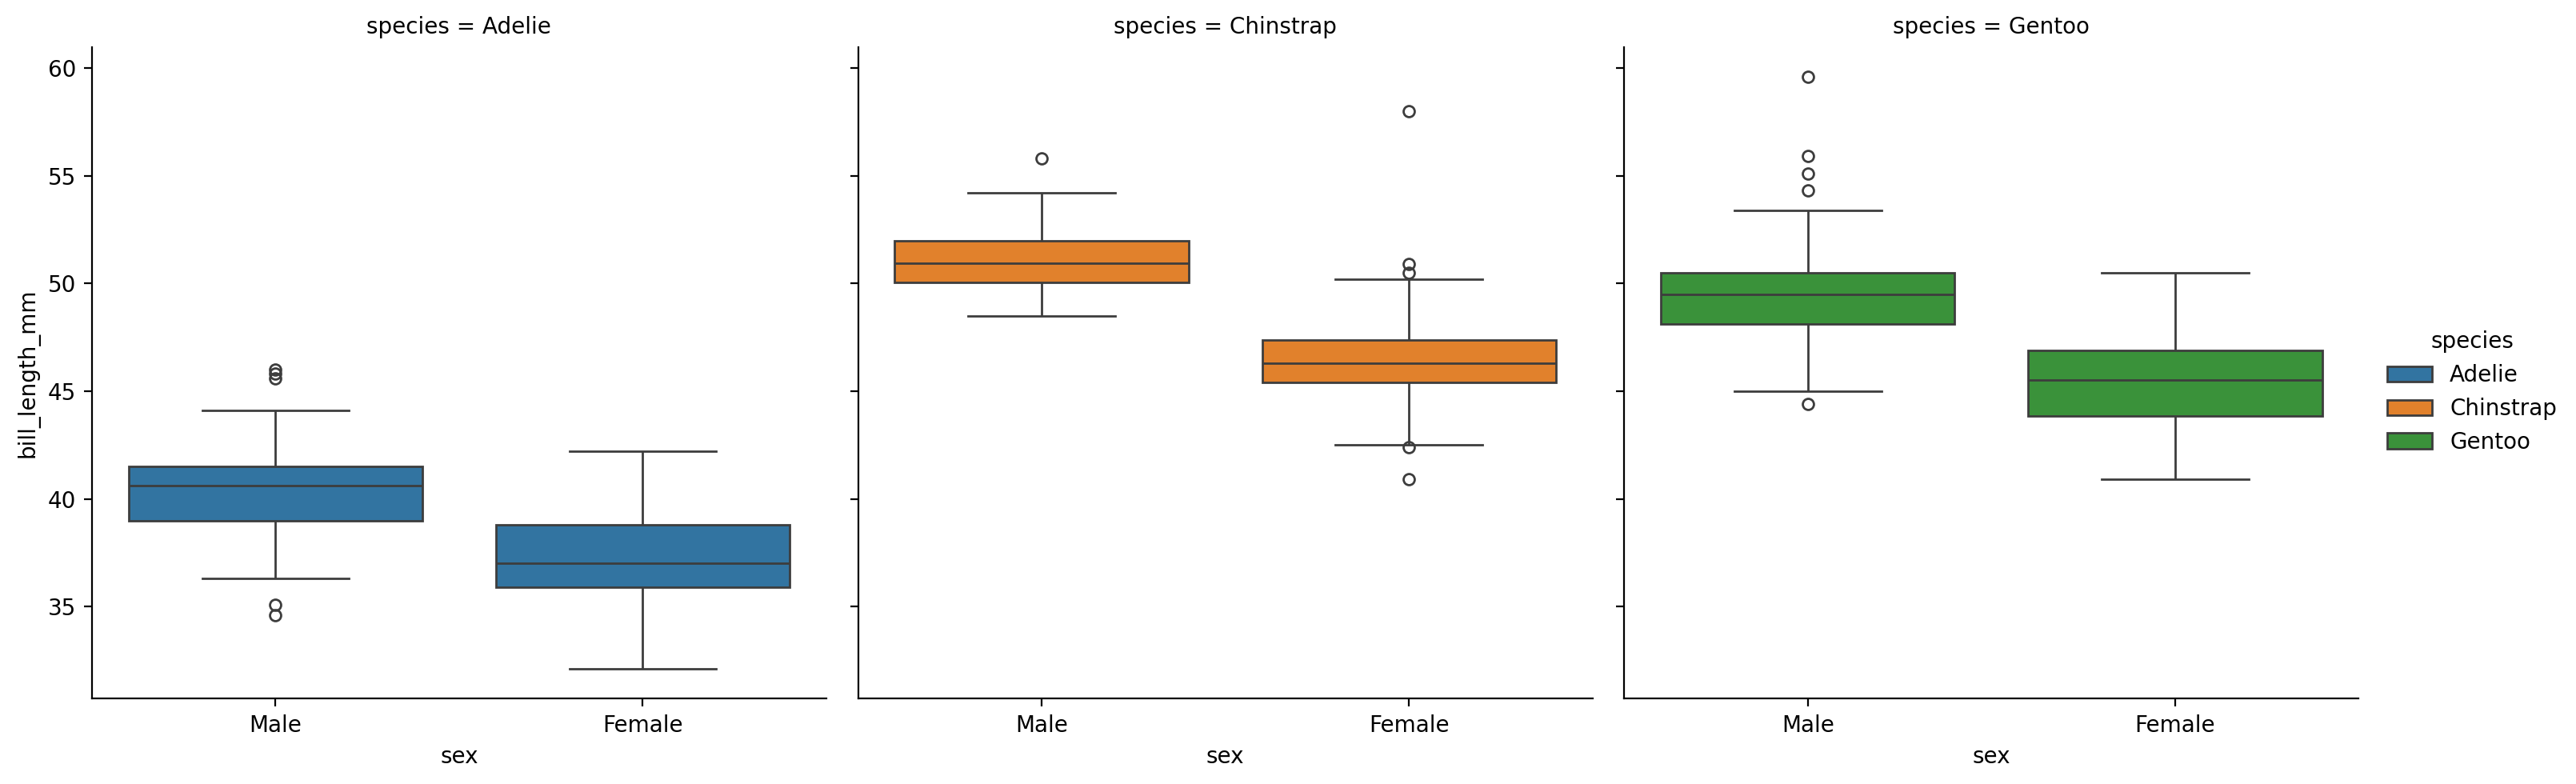

In [42]:
grid = sns.catplot(
    data=penguins,
    kind='box',
    x='sex',
    y='bill_length_mm',
    hue='species',
    col='species'
)

## Multivariate views on complex datasets

Seaborn has 2 other functions that don't neatly fit into the categories we've discussed but can also be very helpful for EDA: `sns.jointplot()` and `sns.pairplot()`. 

[`sns.jointplot()`](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot), focuses on a single relationship. It plots the joint distribution between two variables along with each variable's marginal distribution:

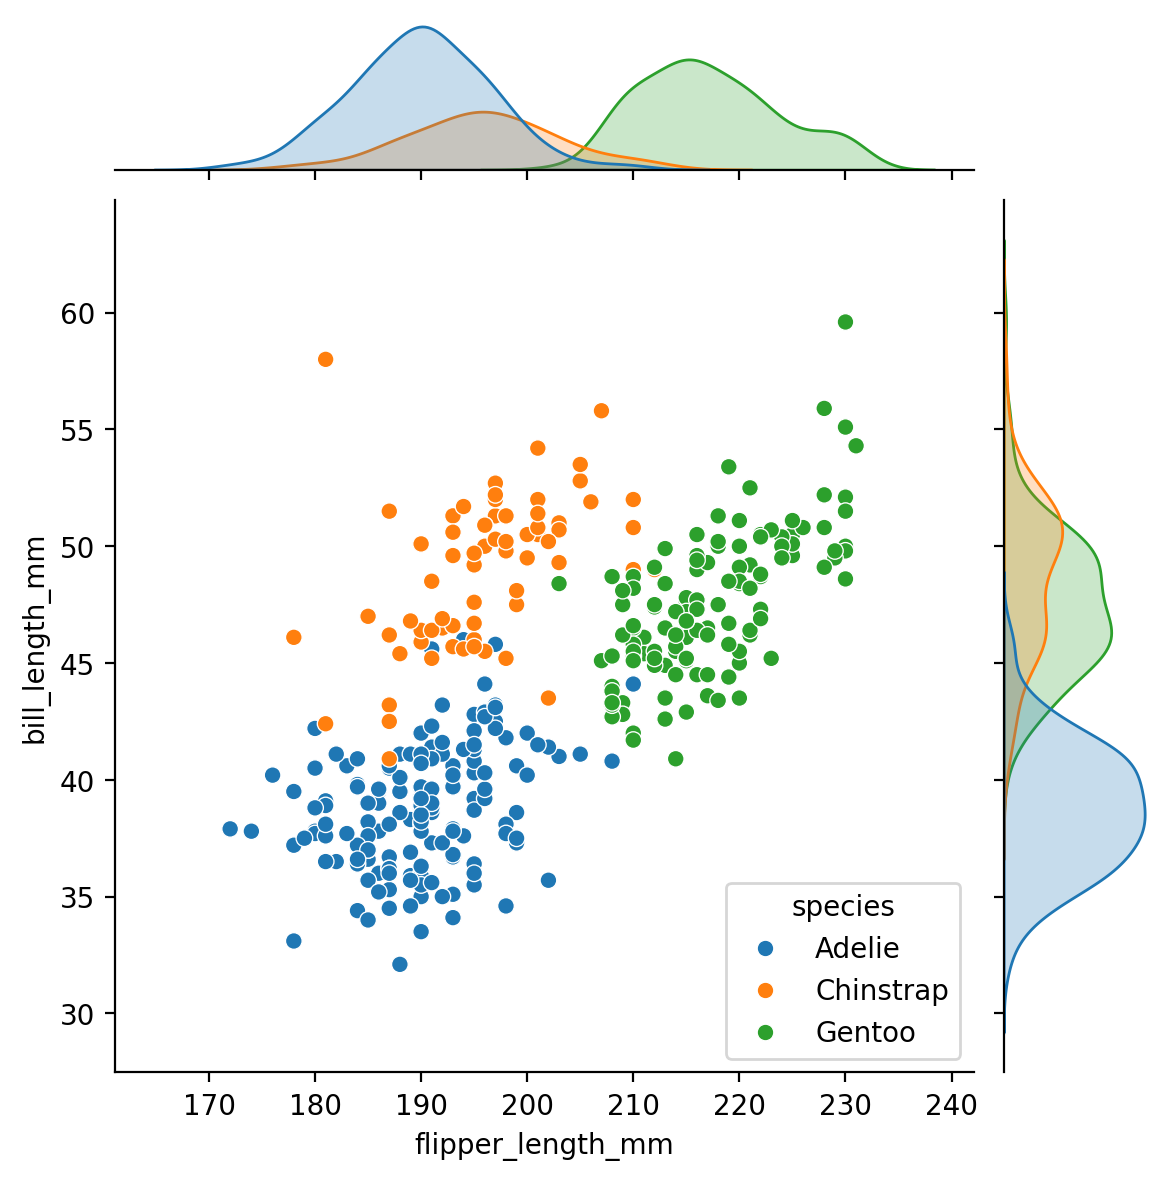

In [43]:
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")

The other, [`sns.pairplot()`](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot), takes a broader view: it shows joint and marginal distributions for all pairwise relationships and for each variable, respectively.

**Note** `sns.pairplot` is an example of a function that doesn't play nicely with Polars DataFrames. So we use `.to_pandas()` method to convert it to a Pandas DataFrame

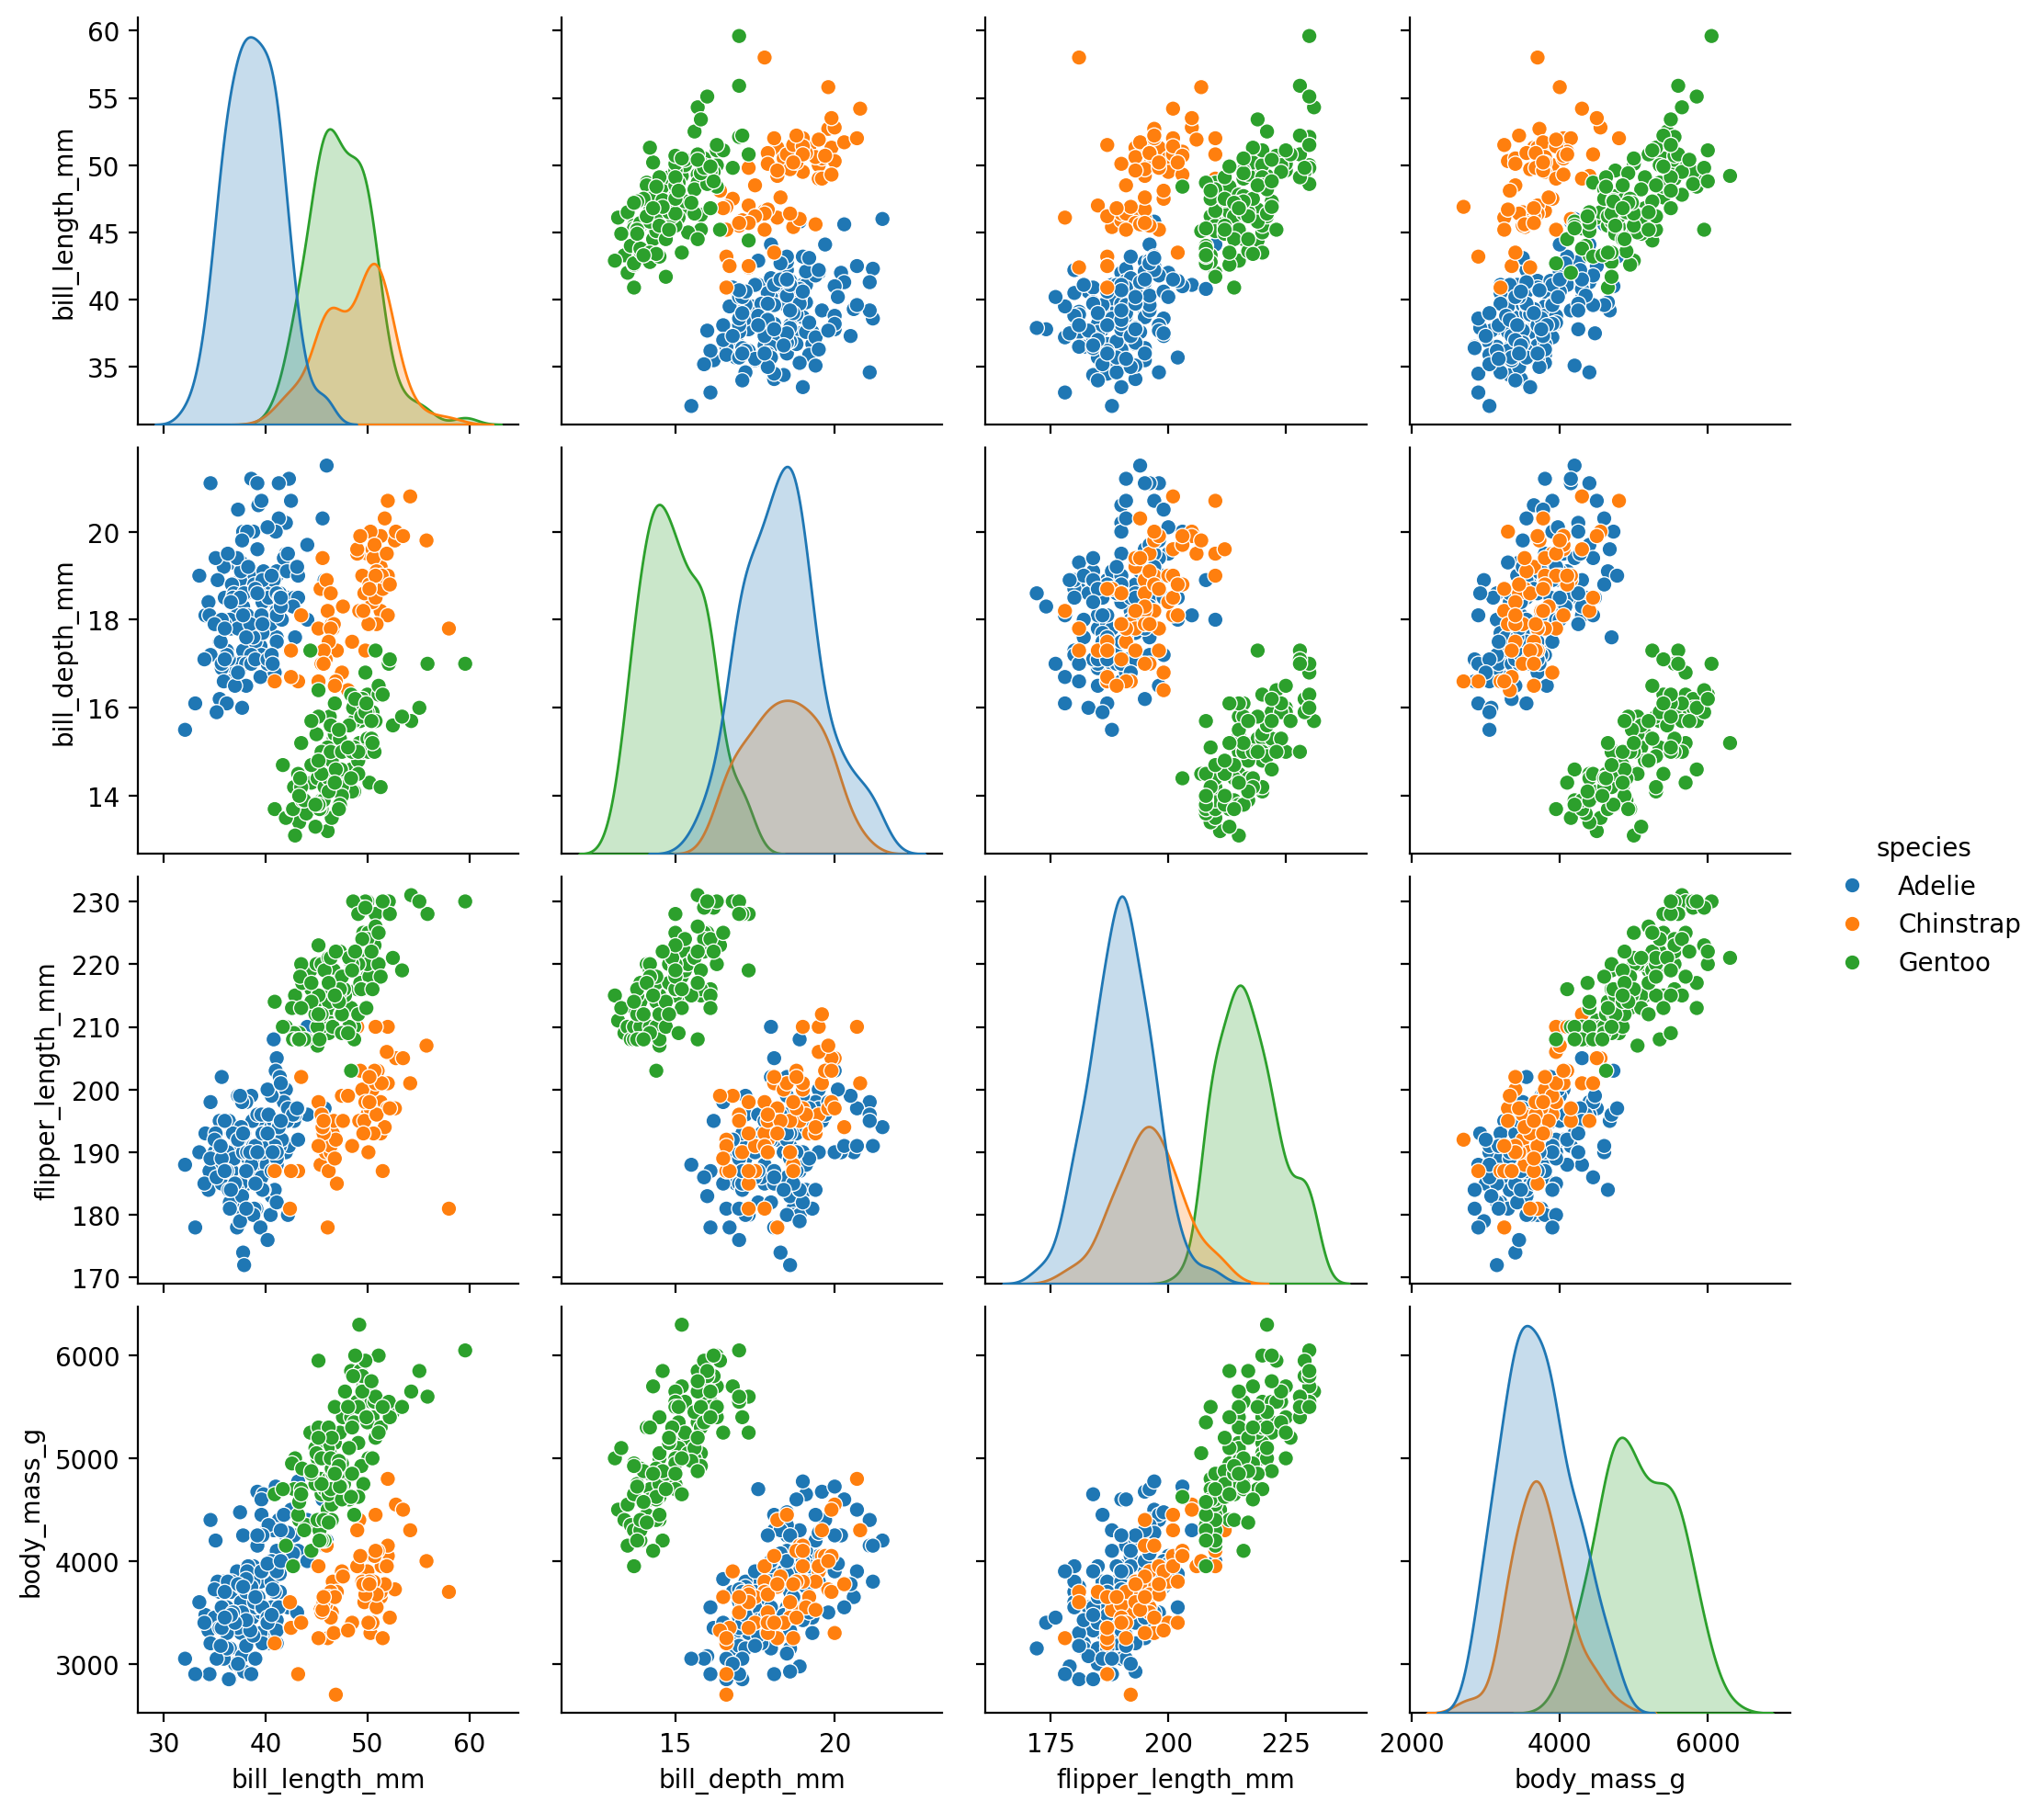

In [44]:
# Will produce "TypeError: 'data' must be a pandas DataFrame object"
# sns.pairplot(data=penguins, hue="species")

# But we can convert it easily
sns.pairplot(data=penguins.to_pandas(), hue="species")

## Customizing plots

At the beginning of this notebook you saw how to customize **simple plots**, e.g. `sns.scatter` - because these seaborn functions return matplotlib Axis, you can use matplotib to customize them directly, e.g. `plt.xlabel('my label)`

In this section we'll learn how to customize `FacetGrid` plots you'll make with `sns.relplot`, `sns.lmplot`, `sns.catplot`, and `sns.displot`

### Pre-configured [figure aesthetics](https://seaborn.pydata.org/tutorial/aesthetics.html#controlling-figure-aesthetics)

Seaborn includes several built-in configurations to change 3 properies of your figures easily: **themes**, **font scales**, and **color palettes** 

**Themes** include: `darkgrid`, `whitegrid`, `dark`, `white`, and `ticks`  
**Font-scales** from smallest-to-largest: `notebook`, `paper`, `talk`, `poster`  
[**Color palettes**](https://seaborn.pydata.org/tutorial/color_palettes.html) include many to choose from

You can control these in several different ways:
1. [`sns.set_theme()`](https://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme) to change all 3 at once for all *future* plots you create 
2. [`sns.set_style()`](https://seaborn.pydata.org/generated/seaborn.set_style.html#seaborn.set_style) or `with sns.axes_style()` to change the **theme** only
3. [`sns.set_context()`](https://seaborn.pydata.org/generated/seaborn.set_context.html#seaborn.set_context) or `with sns.plotting_context()` to change the **font scales** only
4. Provide [`sns.color_palette()`](https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette) to the `palette` argument of a seaborn function to change **color palettes** only


Let's explore these by returning to Anscombe's quartet. 

`sns.set_theme()` takes `style`, `context`, and `palette` arguments which will change the look of all **future plots** you create after you call it:

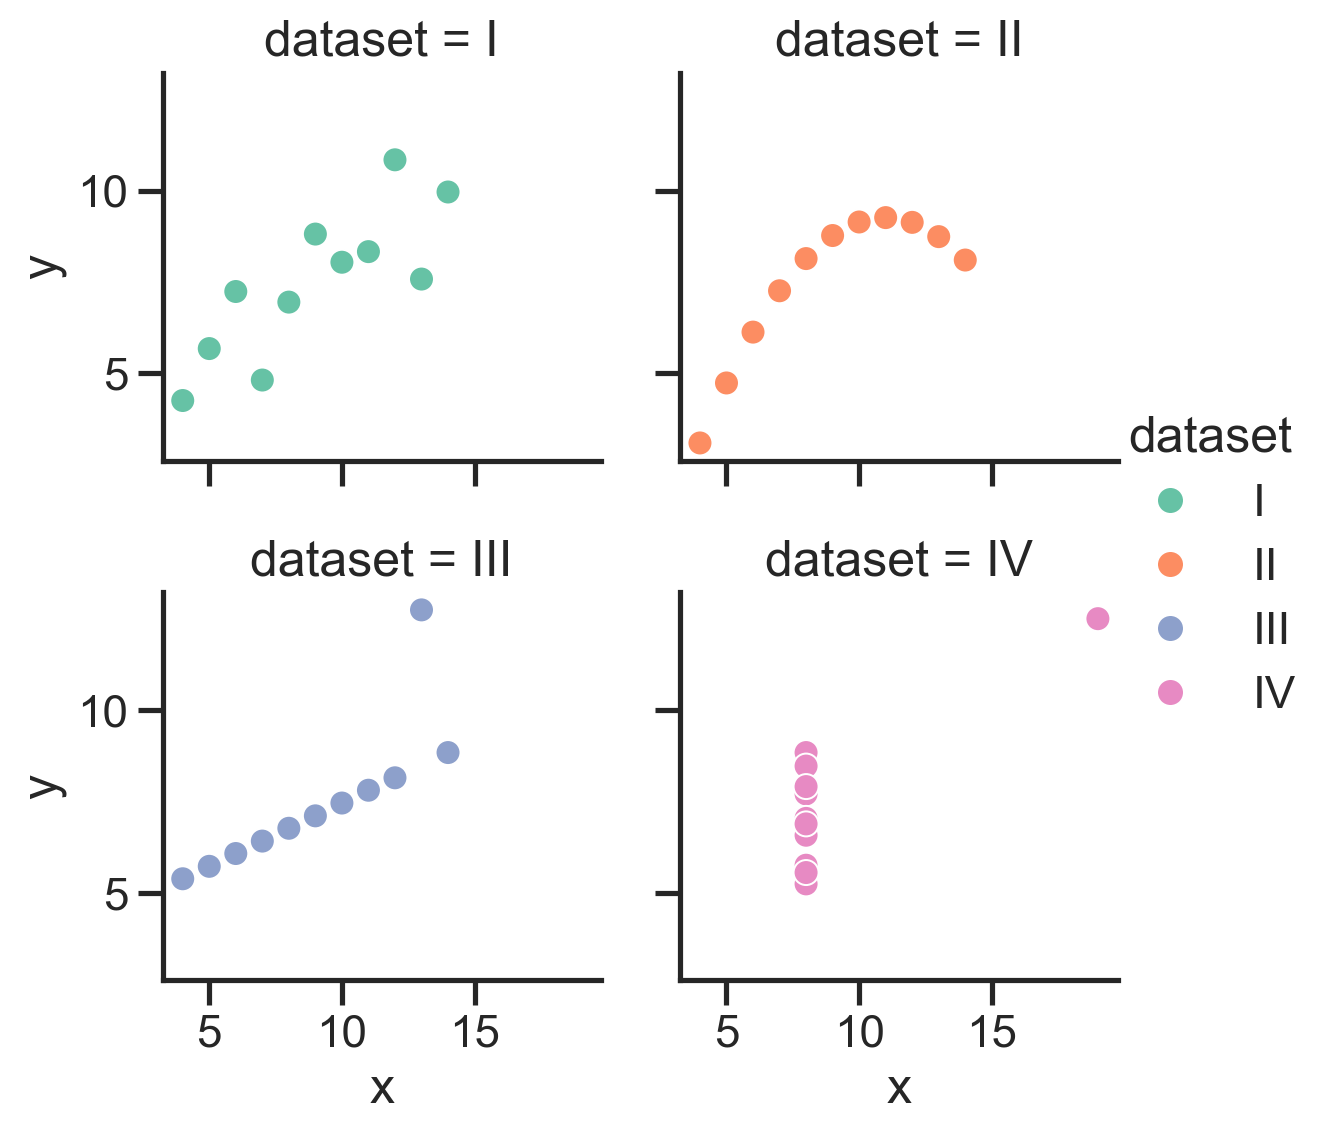

In [45]:
sns.set_theme(style='ticks', context='talk', palette='Set2')

grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,
)

Notice how the customizations are preserved when we create a new plot in another cell:

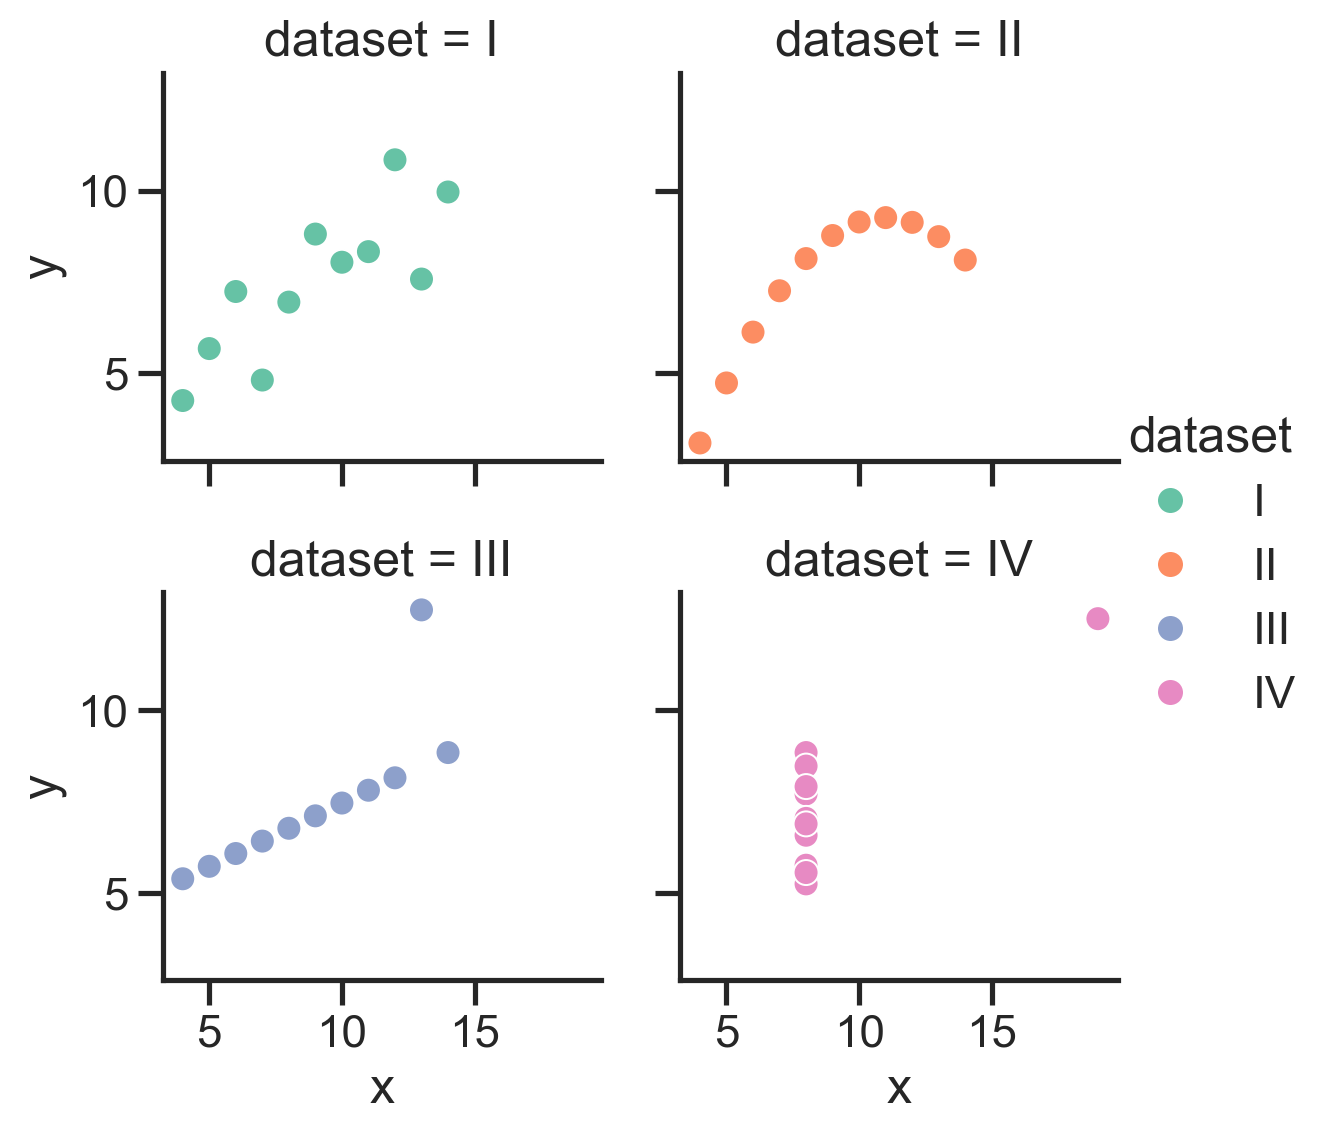

In [46]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,
)

And we can reset it to what we had before:

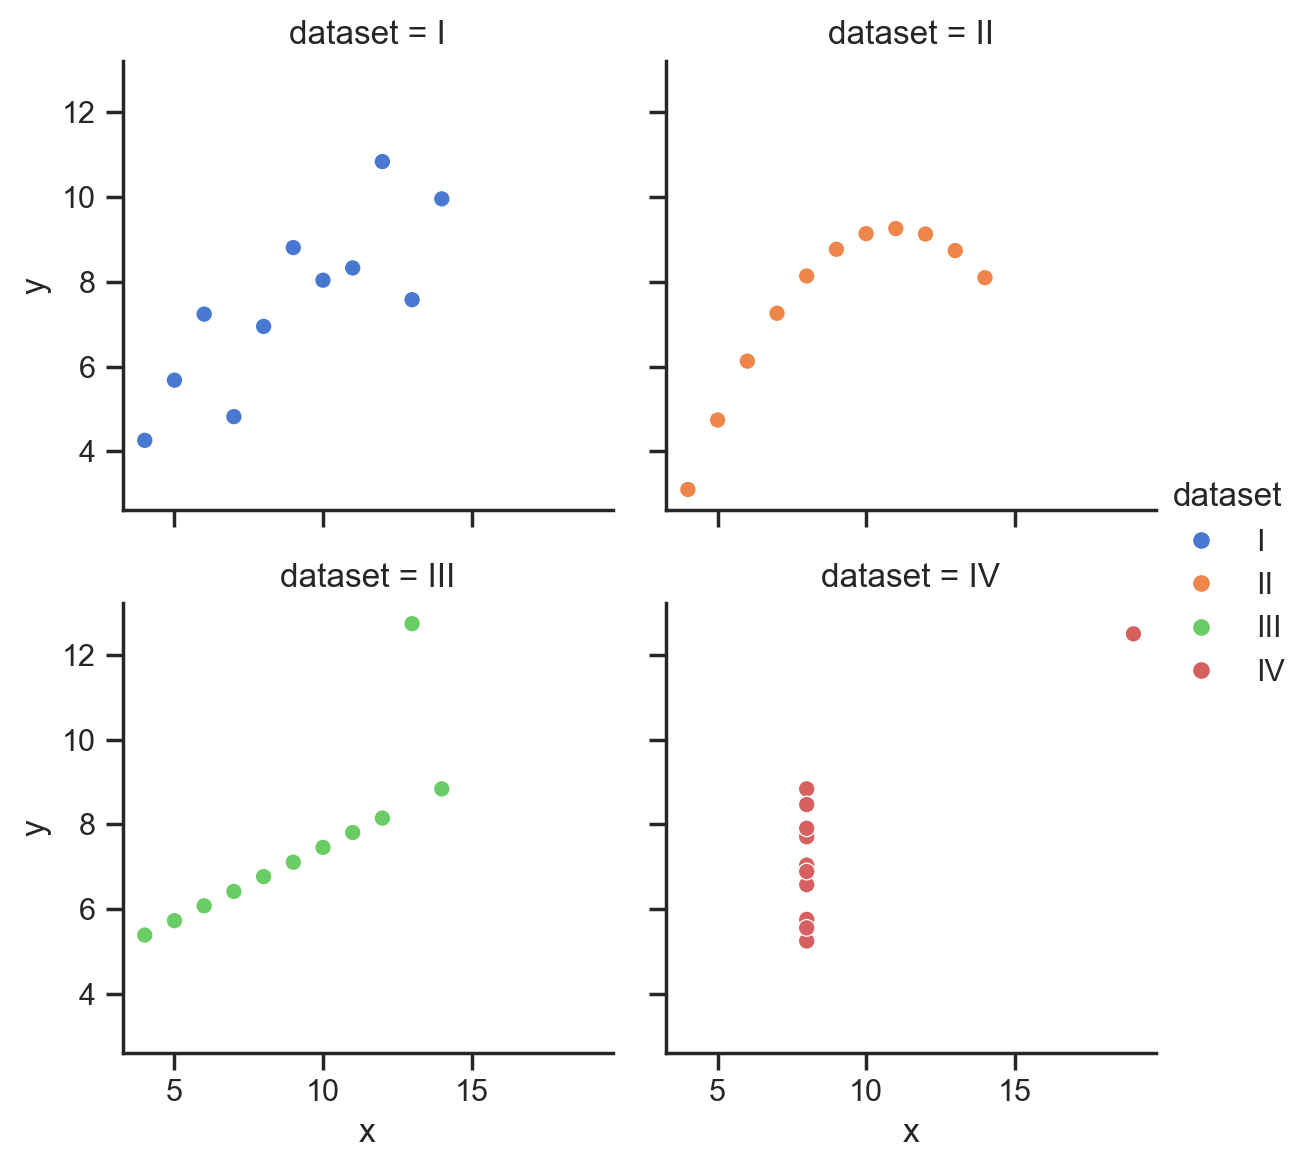

In [47]:
sns.set_theme(style='ticks', context='notebook', palette='muted')

grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,
)

A better practice is to use the special `with` keyword in Python. This will **temporarily** use the styles you specify when you create a plot, but will not affect the styles of other plots you create.

Most often you'll use `with sns.axes_style()` and/or `with sns.plotting_context()` to adjust the theme and font-scales for your plot respectively. You can also specify a color palette by using the `palette` argument of any seaborn plotting function and providing a string name:


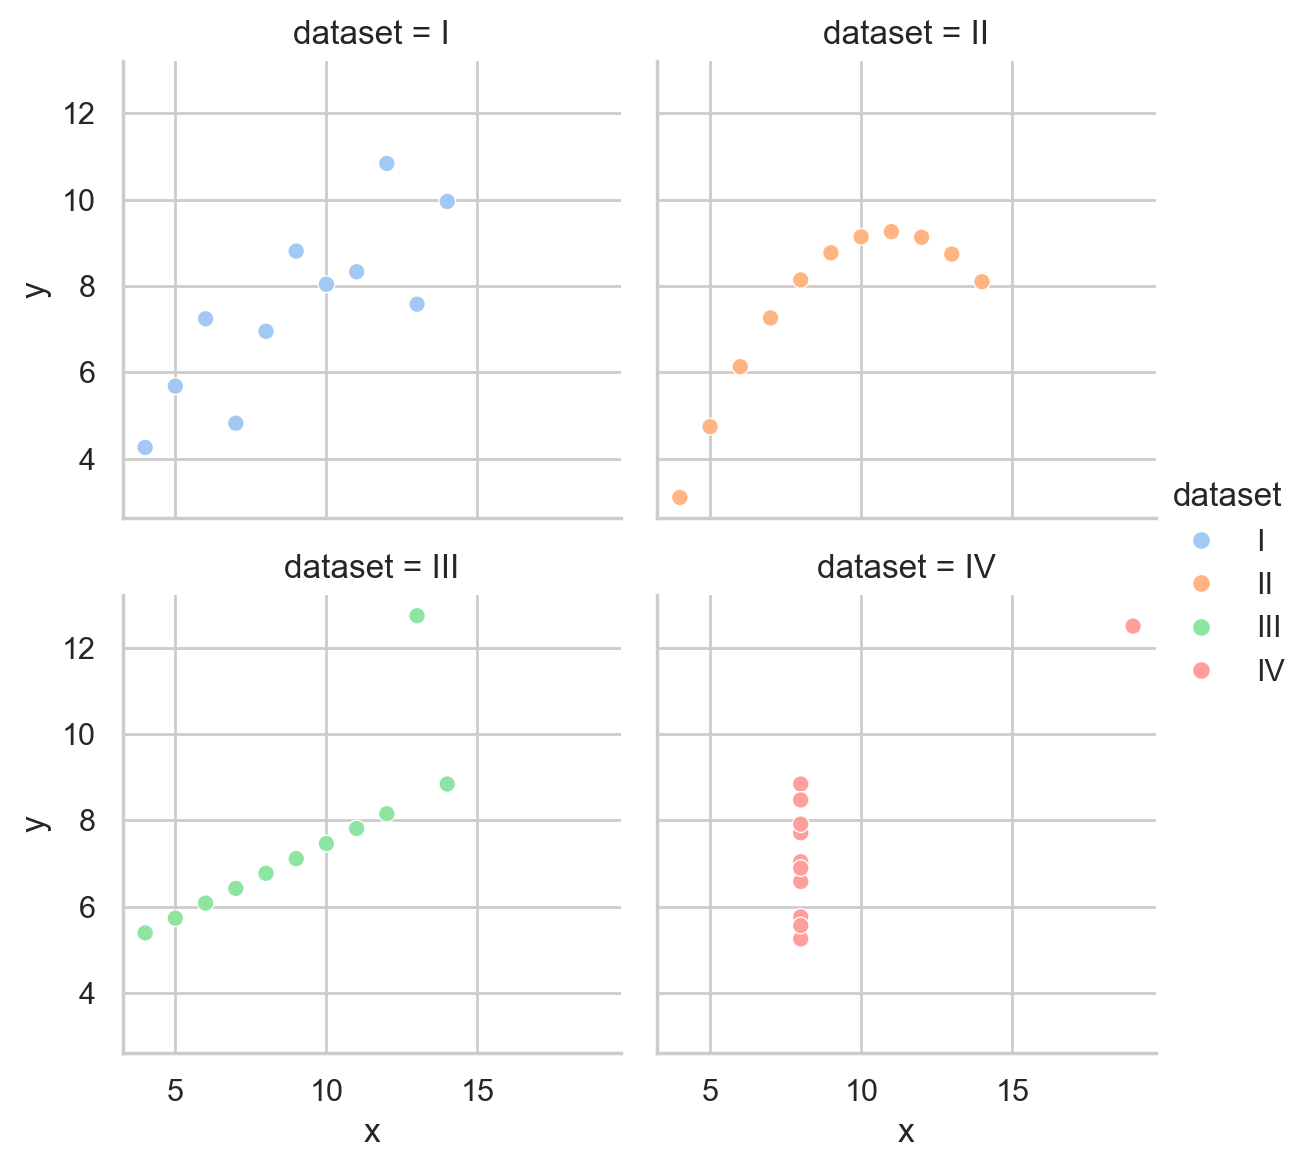

In [48]:
# With makes customization apply only to code indented under it!
with sns.axes_style('whitegrid'):

    # Everything is indented over like an if-else statement
    grid = sns.relplot(
        data=scatter_data,
        kind='scatter',
        x="x",
        y="y",
        hue="dataset",
        col="dataset",
        col_wrap=2,
        height=3,
        aspect=1,
        palette='pastel'         # <-- color palette
    )

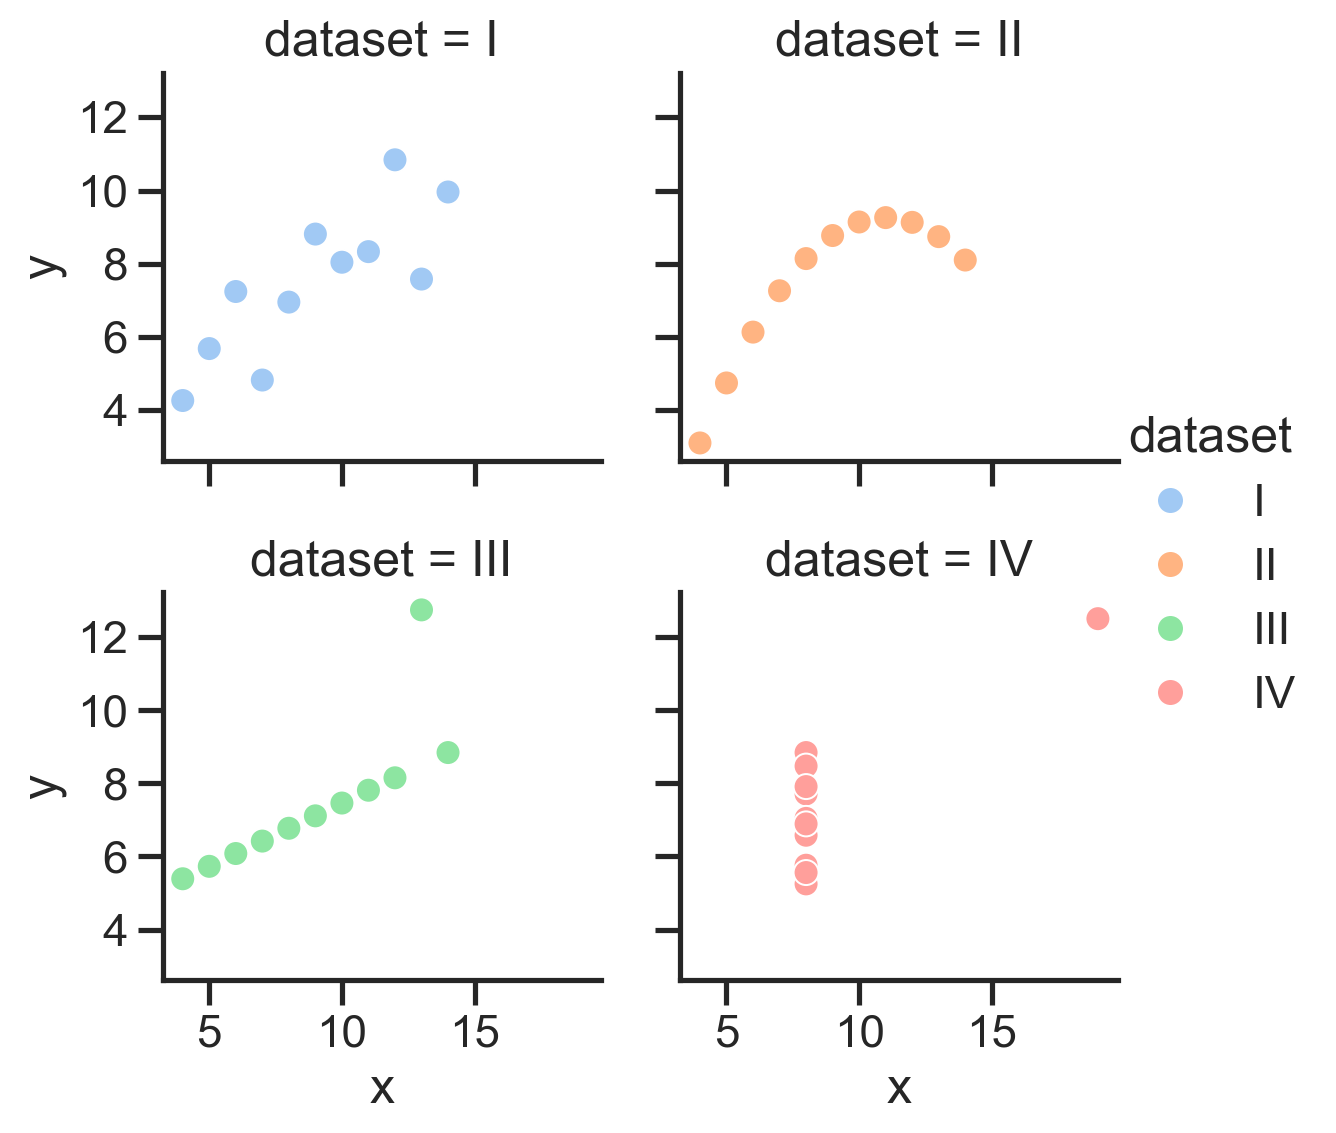

In [49]:
with sns.plotting_context('talk'):

    # Everything is indented over like an if-else statement
    grid = sns.relplot(
        data=scatter_data,
        kind='scatter',
        x="x",
        y="y",
        hue="dataset",
        col="dataset",
        col_wrap=2,
        height=3,
        aspect=1,
        palette='pastel'         # <-- color palette
    )

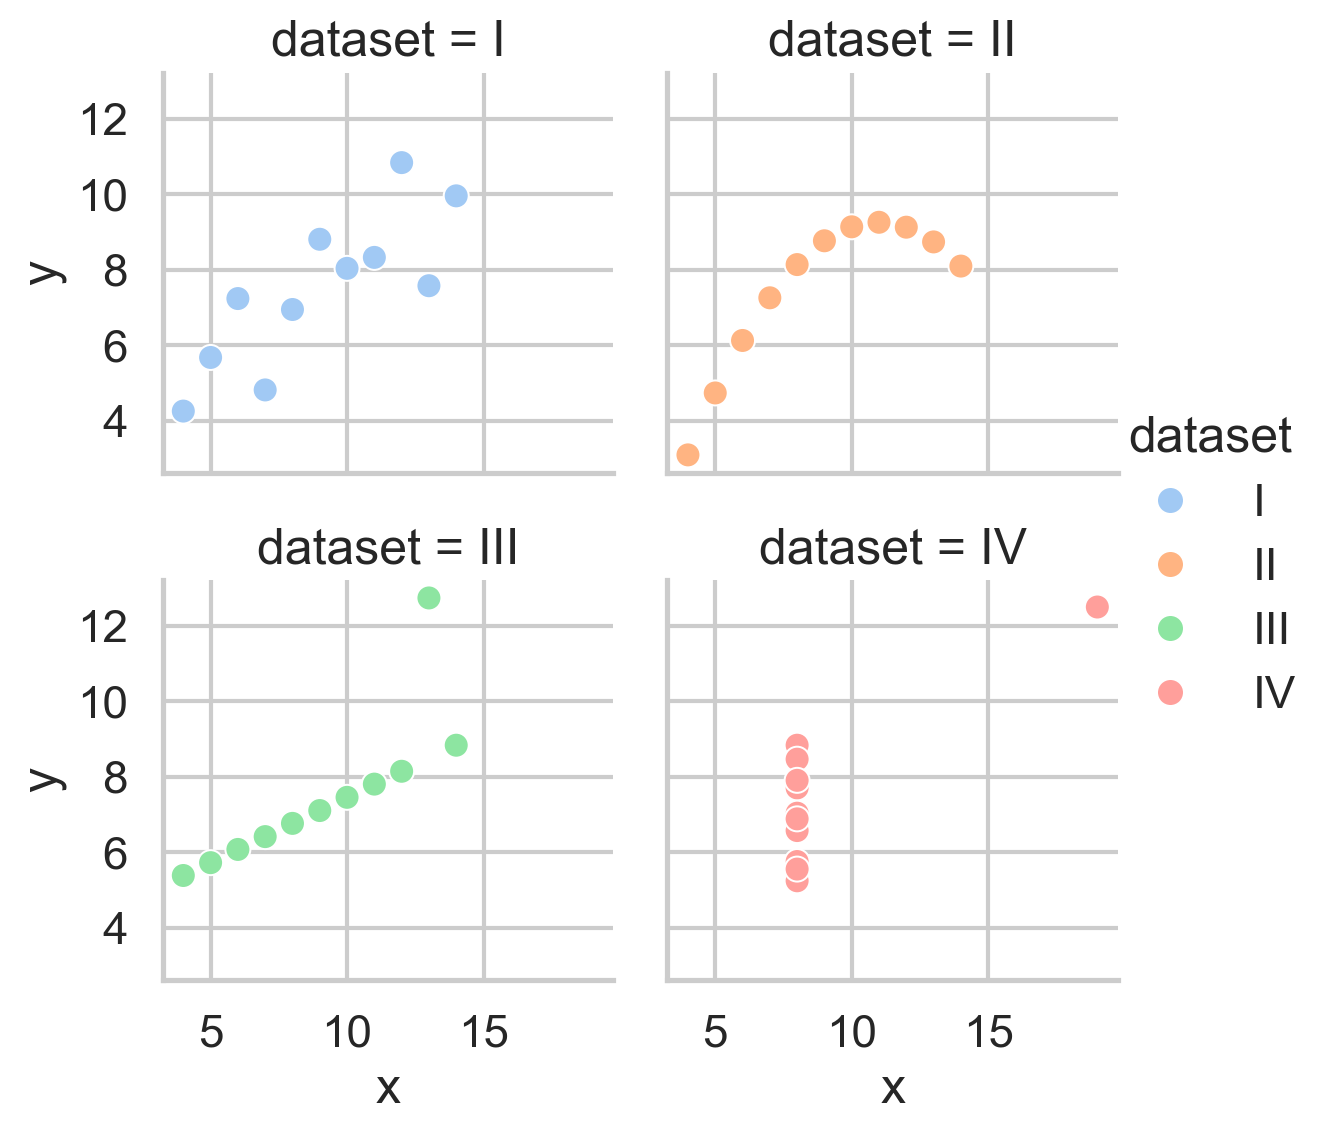

In [50]:
# Combined with statements like nesting for loops
with sns.axes_style('whitegrid'):
    with sns.plotting_context('talk'):

        grid = sns.relplot(
            data=scatter_data,
            kind='scatter',
            x="x",
            y="y",
            hue="dataset",
            col="dataset",
            col_wrap=2,
            height=3,
            aspect=1,
            palette='pastel'         # <-- color palette
        )

### Fine-grained customization

`FacetGrid` includes various methods for easily tweaking a plot, documented at the bottom of [this page](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid).

For example, we can adjust the axis labels and limits of each subplot easily using the `.set()` and `.set_axis_labels()` methods:

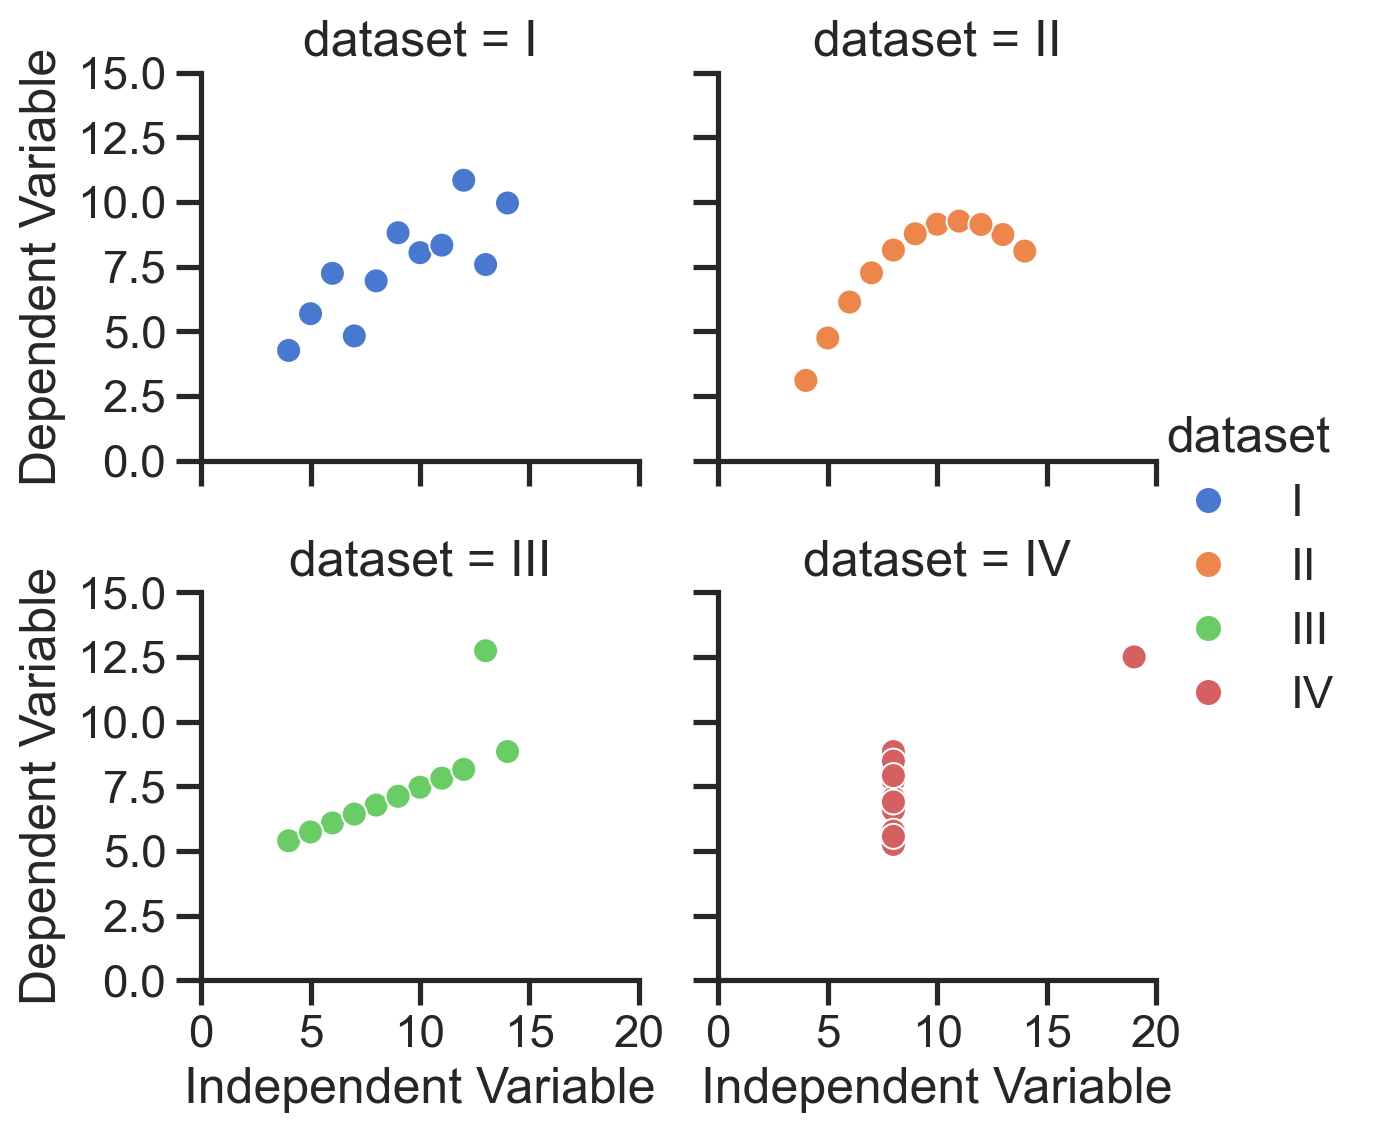

In [51]:
with sns.plotting_context('talk'):

    grid = sns.relplot(
        data=scatter_data,
        kind='scatter',
        x="x",
        y="y",
        hue="dataset",
        col="dataset",
        col_wrap=2,
        height=3,
        aspect=1,
    )

    # Change x and y labels for each subplot
    grid.set_axis_labels('Independent Variable', 'Dependent Variable');

    # Change the x and y limits for each subplot
    grid.set(
        xlim=(0, 20),   # <- this is a tuple!
        ylim=(0, 15),   # <- this is a tuple!
    );

If seaborn doesn't provide some functionality we need, you can always **directly access** the underlying matplotlib `figure` or `axes` inside a `FacetGrid`.  

If we refer to the `grid.figure`, we can use its `.suptitle()` method to add a title to the figure.

This is equivalent to using the `plt.suptitle()` function if you were working with a **single** set of axes. But in this case it works for the entire `figure`:

Text(0.5, 1.05, "Anscombe's Quartet")

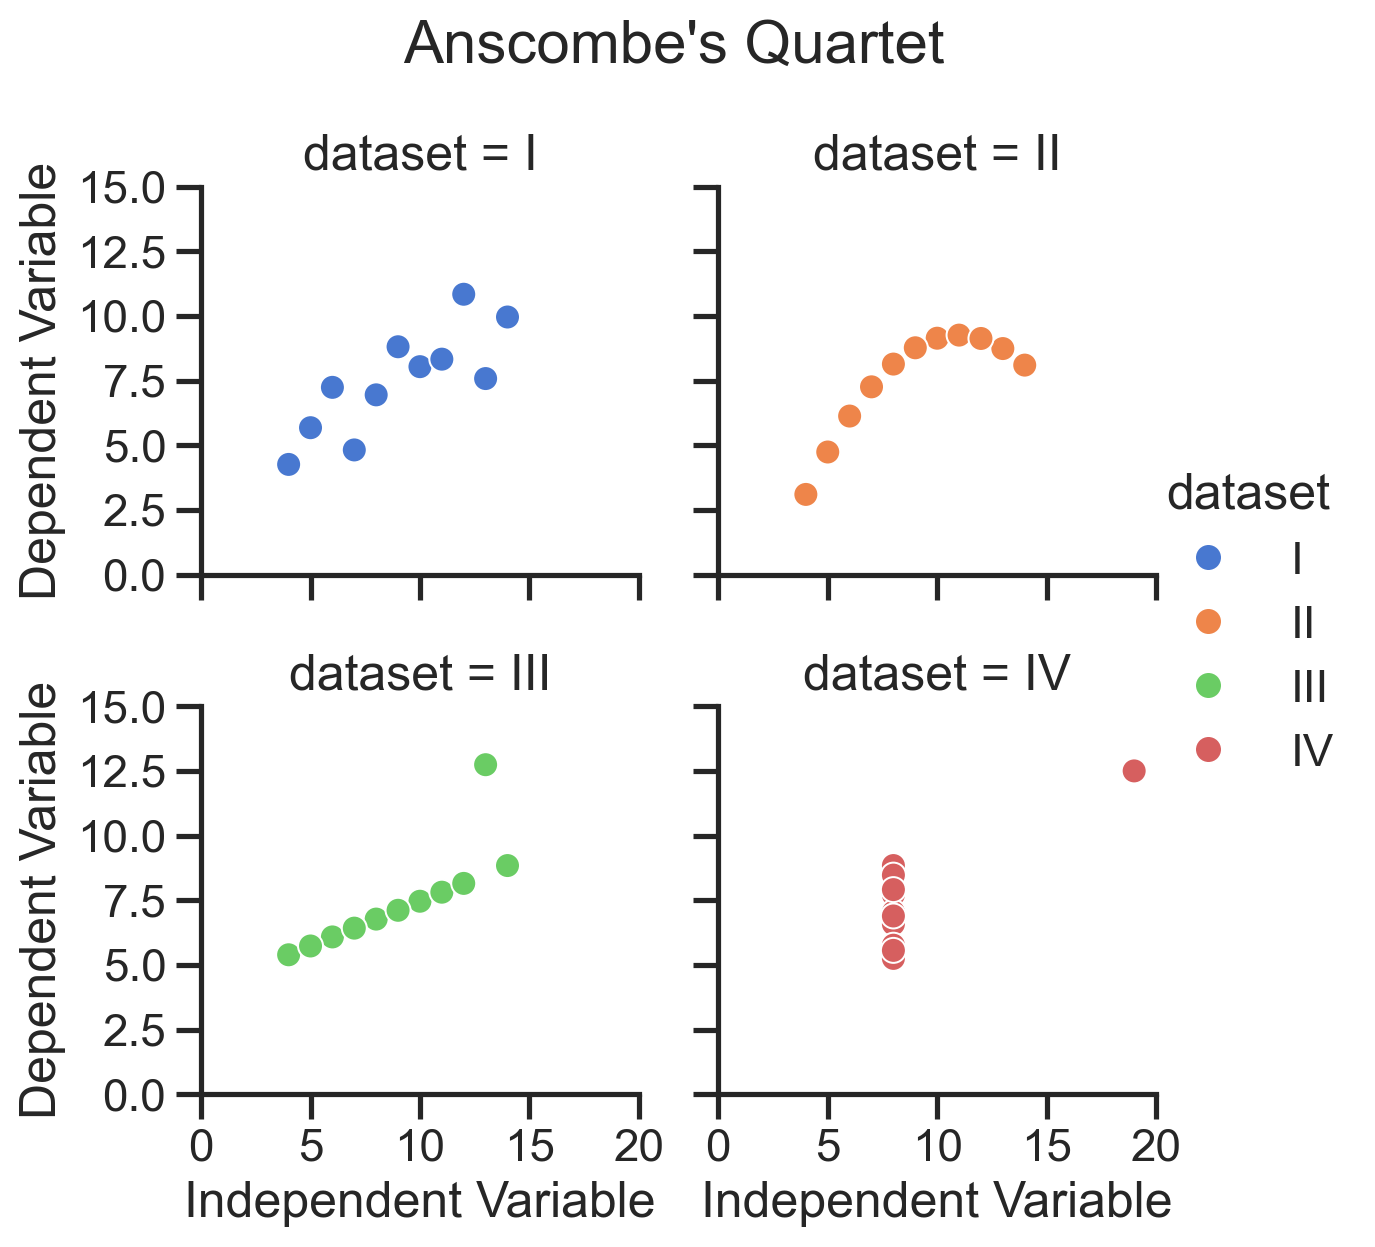

In [52]:
with sns.plotting_context('talk'):
    grid = sns.relplot(
        data=scatter_data,
        kind='scatter',
        x="x",
        y="y",
        hue="dataset",
        col="dataset",
        col_wrap=2,
        height=3,
        aspect=1,
    )

    # Change x and y labels for each subplot
    grid.set_axis_labels('Independent Variable', 'Dependent Variable');

    # Change the x and y limits for each subplot
    grid.set(
        xlim=(0, 20),   # <- this is a tuple!
        ylim=(0, 15),   # <- this is a tuple!
    );

    # Access .figure and call .suptitle() method
    grid.figure.suptitle("Anscombe's Quartet", y=1.05);

### Recreate the figure from Anscombe's Quartet

With a bit more tweakinng we can using seaborn to create a figure that looks just this like picture of Anscombe's Quartet:

<img src="./figs/quartet.png" width="50%" alt="Figure 1">

Text(0.5, 0.98, "Anscombe's Quartet")

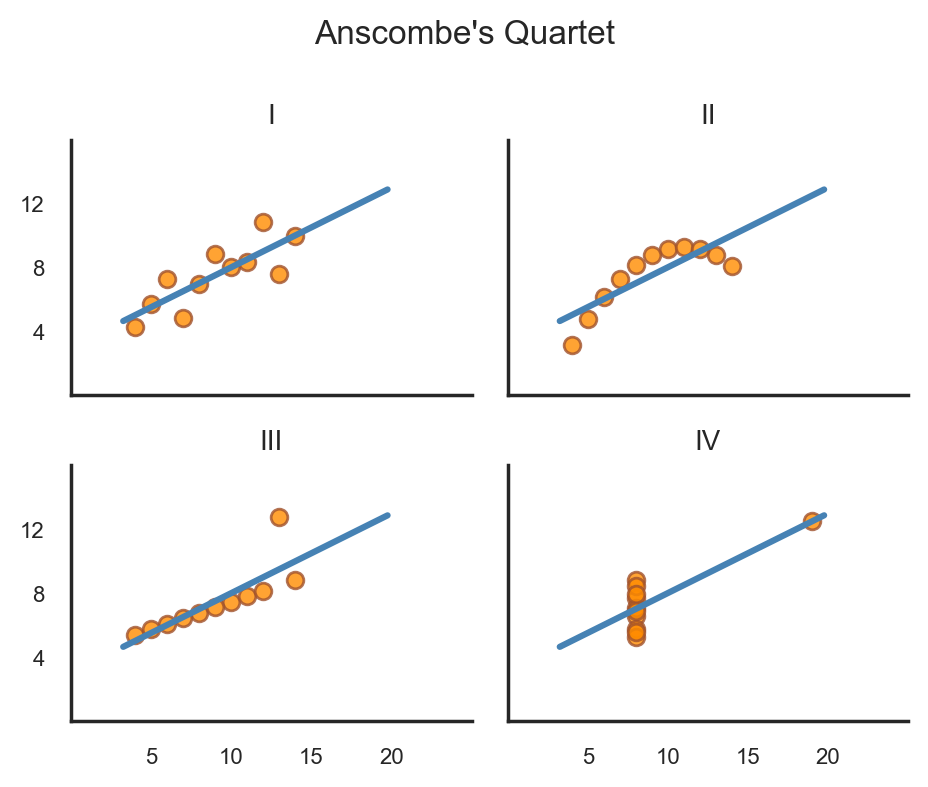

In [53]:
# White theme
with sns.axes_style("white"):

    grid = sns.lmplot(
        data=scatter_data,
        x="x",
        y="y",
        col="dataset",
        ci=None,
        truncate=False,
        col_wrap=2,
        height=2,
        aspect=1.2,
        # Color of the regression line
        line_kws={'color': 'steelblue'},
        # Color of the scatter points
        scatter_kws={'edgecolors': 'sienna', 'color': 'darkorange'}

    );

    # We're going to manually define our ticks and labels
    # We don't want to show the 0 ticks so slice from the 1st to end of each list
    xticks = list(range(0, 25, 5))[1:]
    yticks = list(range(0, 16, 4))[1:]

    grid.set(
        xlim=(0, 25),
        ylim=(0, 16),
        xticks= xticks, 
        yticks= yticks,
    );

    # Adjust the font size of the tick labels
    for ax in grid.axes.flat:
       ax.tick_params(axis='both', which='major', labelsize=8);

    # Remove individual subplot labels
    grid.set_axis_labels('', '');

    # Adjust subplot titles
    grid.set_titles("{col_name}", size=10);

    # Add a overall title
    grid.figure.suptitle("Anscombe's Quartet", fontsize=12);

    # Auto-adjust the spacing
    grid.figure.tight_layout();

### Ordering variable levels

You can control the order of any non-numeric column values that you map using the following arguments:

- `x` -> `order`
- `hue` -> `hue_order`
- `col` -> `col_order`
- `row` -> `row_order`

This allows us to precisely control for example the precise order of subplots levels in a figure, or even barplots within a subplot.

Let's revisit the penguins dataset and create barplot of average bill length split by species and sex.

We'll plot the means of females within each species first and order the subplots by species reverse-alphabetically:

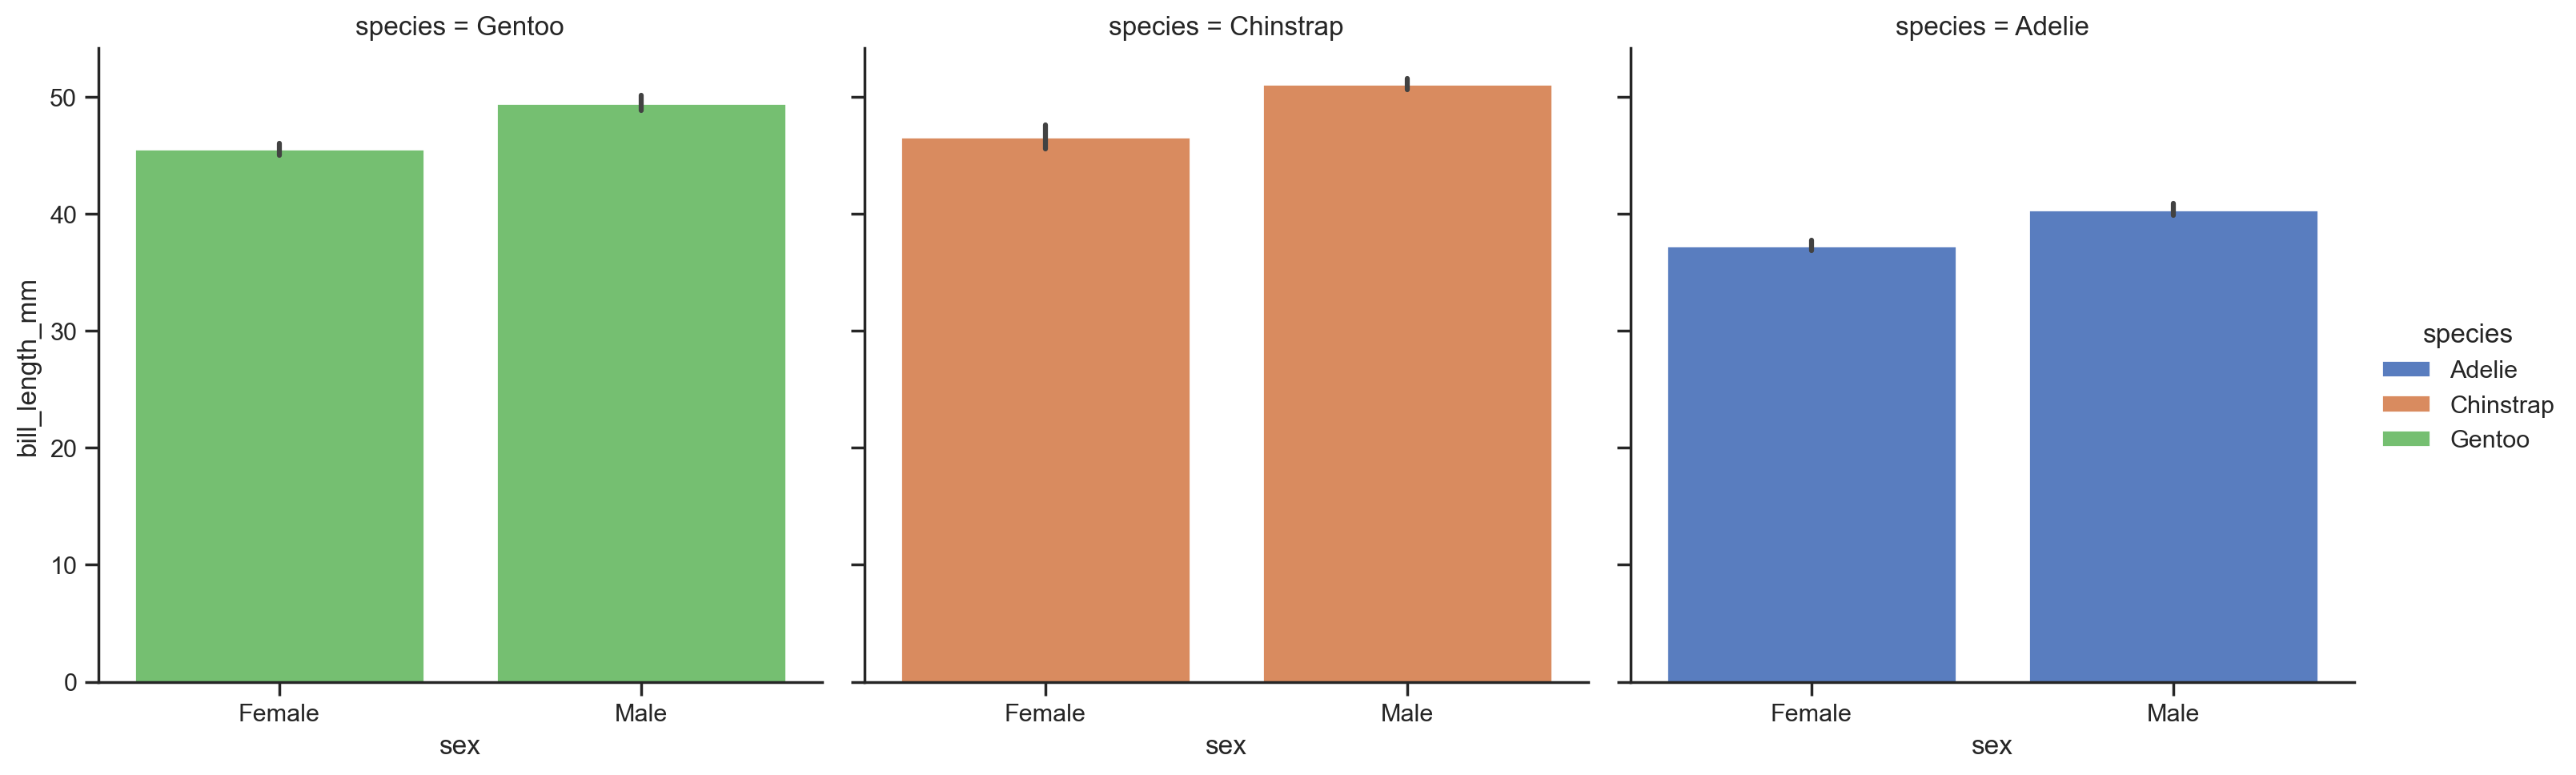

In [54]:
grid = sns.catplot(
    data=penguins,
    kind='bar',
    x='sex',
    y='bill_length_mm',
    hue='species',
    col='species',
    order=['Female', 'Male'], # x-axis order
    col_order=penguins['species'].unique().sort(descending=True), # subplot order
)

### Layering plots on `FacetGrid`

Sometimes it can be helpful to layer multiple plots on top of each other - for example when you want a box/barplot along with individual datapoints from a strip/swarmplot.

In these situations it can be helpful to understand how to create a custom `FacetGrid` from scratch.

The steps are:
1. Setup up the grid and provide `data` and any mapping that should *shared* across layers, e.g `col` 
2. Use `grid.map()` to layer on plots

The `.map()` method takes a seaborn function and what column names to map to `x` and `y` along with any options arguments for that specific plotting functions

Let's do this using the previous barplot of penguin bill lengths to add individual datapoints:

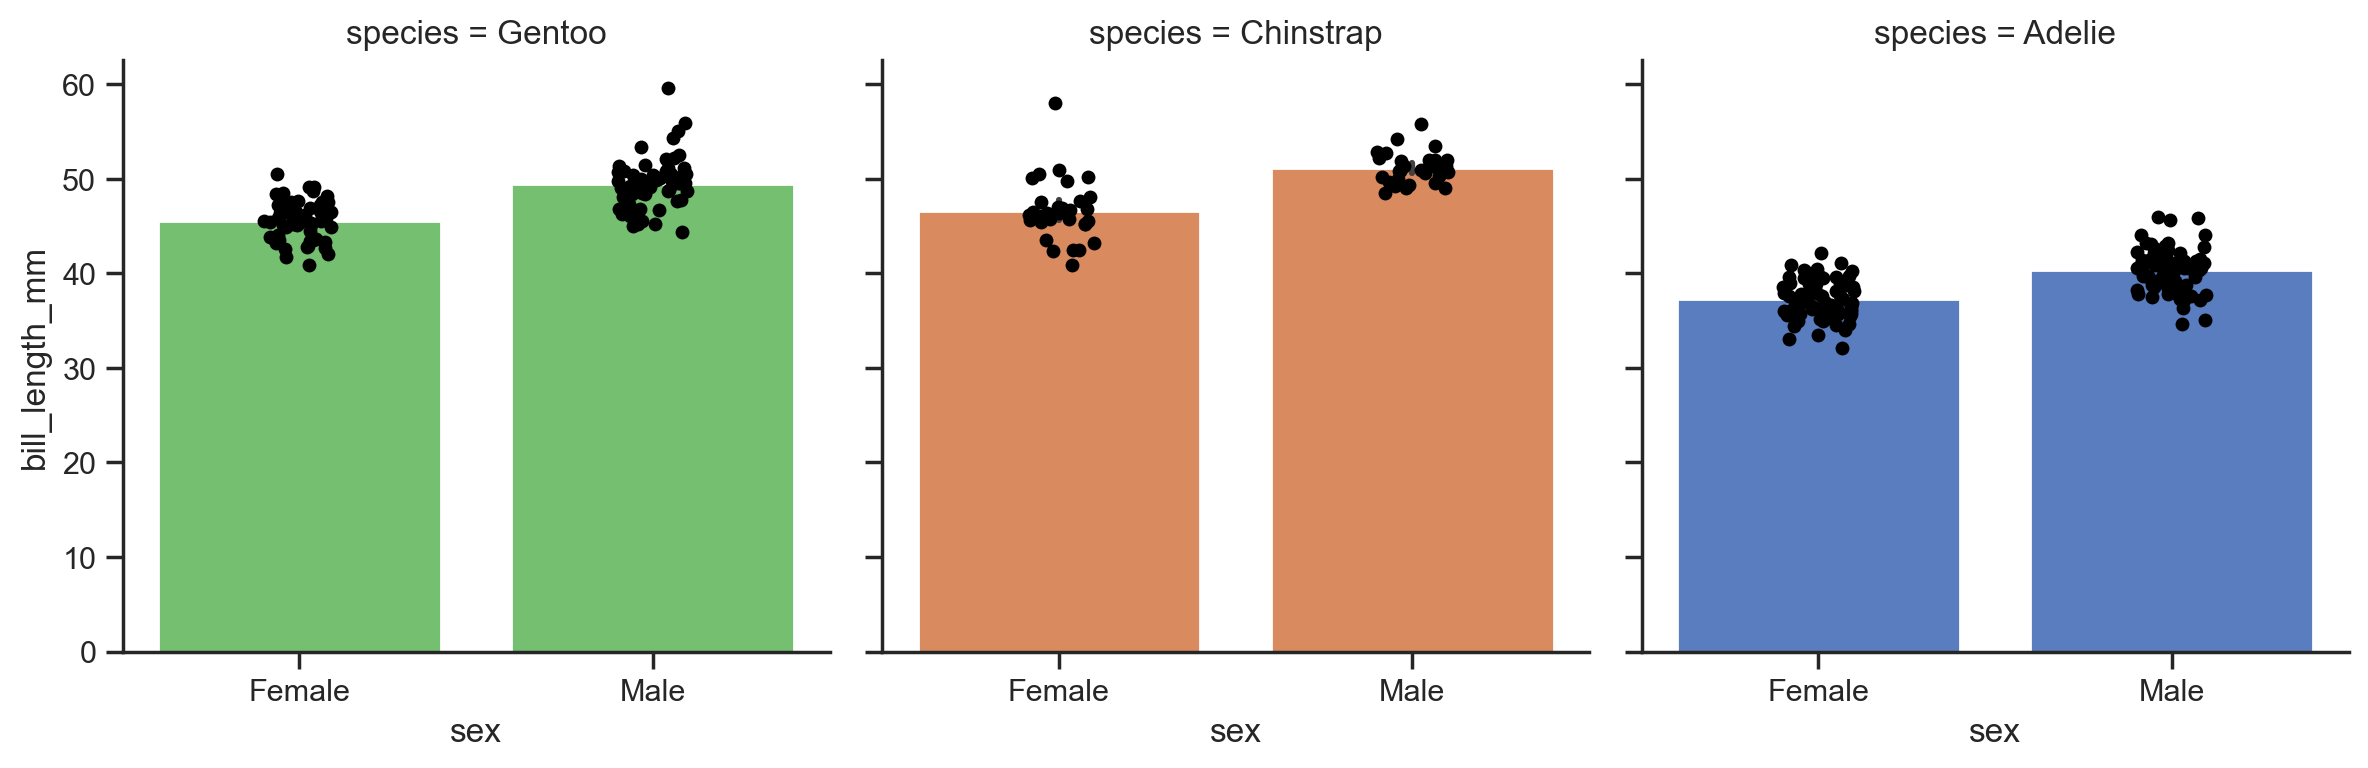

In [55]:
# 1. Setup the grid and col mappings
grid = sns.FacetGrid(
    data=penguins,
    hue='species',
    col='species',
    col_order=penguins['species'].unique().sort(descending=True), # subplot order
    height=4
)

# Layer on barplot
grid.map(sns.barplot, 'sex', 'bill_length_mm', order=['Female', 'Male'])

# Layer on stripplot
grid.map(sns.stripplot, 'sex', 'bill_length_mm', order=['Female', 'Male'], color='black')

## Wrapping Up

This notebook gave you a high-level introduction to how `seaborn` can help you easily make beautiful statistical visualizations in Python. It works well with Polars DataFrames and allows you to refer to columns by name and write less code. At the same time you can easily customize your plots to your liking for publication-ready graphics.

While you can be productive using only seaborn functions, full customization of your graphics will require some knowledge of matplotlib's concepts and API. One aspect of the learning curve for new users of seaborn will be knowing when dropping down to the matplotlib layer is necessary to achieve a particular customization. On the other hand, users coming from matplotlib will find that much of their knowledge transfers.

Matplotlib has a comprehensive and powerful API; just about any attribute of the figure can be changed to your liking. A combination of seaborn's high-level interface and matplotlib's deep customizability will allow you both to quickly explore your data and to create graphics that can be tailored into a [publication quality](https://github.com/wagnerlabpapers/Waskom_PNAS_2017) final product.




## Next steps

Spend a few minutes checking out the  [example gallery](https://seaborn.pydata.org/examples/index.html) to get a broader sense for what kind of graphics seaborn can produce. 

If you have a specific plot in mind and want to know how to make it, you could check out the [API reference](https://seaborn.pydata.org/api.html), which documents each function's parameters and shows many examples to illustrate usage.

You can also check-out other pages in the official [user guide and tutorial](https://seaborn.pydata.org/tutorial.html) for a deeper discussion of the different tools and what they are designed to accomplish, then try some examples out in this notebook.

Or try playing with some of the other types of plots we didn't explore in this notebook, e.g. [lineplots](https://seaborn.pydata.org/tutorial/relational.html#emphasizing-continuity-with-line-plots). 

Otherwise you can move right onto `03_challenge.ipynb`!

# Appendix

### Formatting axis labels and ticks

This section of the notebook is *optional* and may be useful as a reference for future assignments.

Matplotlib provides a few tools that allow us to easy customize the **tick spacing and labels** of our subplots.  

These functions are used for auto-creating ticks in specific ways (e.g. by total number of ticks, or by intervals).

<img src="./figs/locators.png" width="40%" alt="Figure 1">

In [56]:
# Import them
from matplotlib.ticker import MultipleLocator, MaxNLocator, LinearLocator

In order to customize the ticks of a `FacetGrid` subplot we need to loop over the `grid.axes` and use the `.set_major_locator()` and `.set_major_formatter()` methods on each individual subplots.

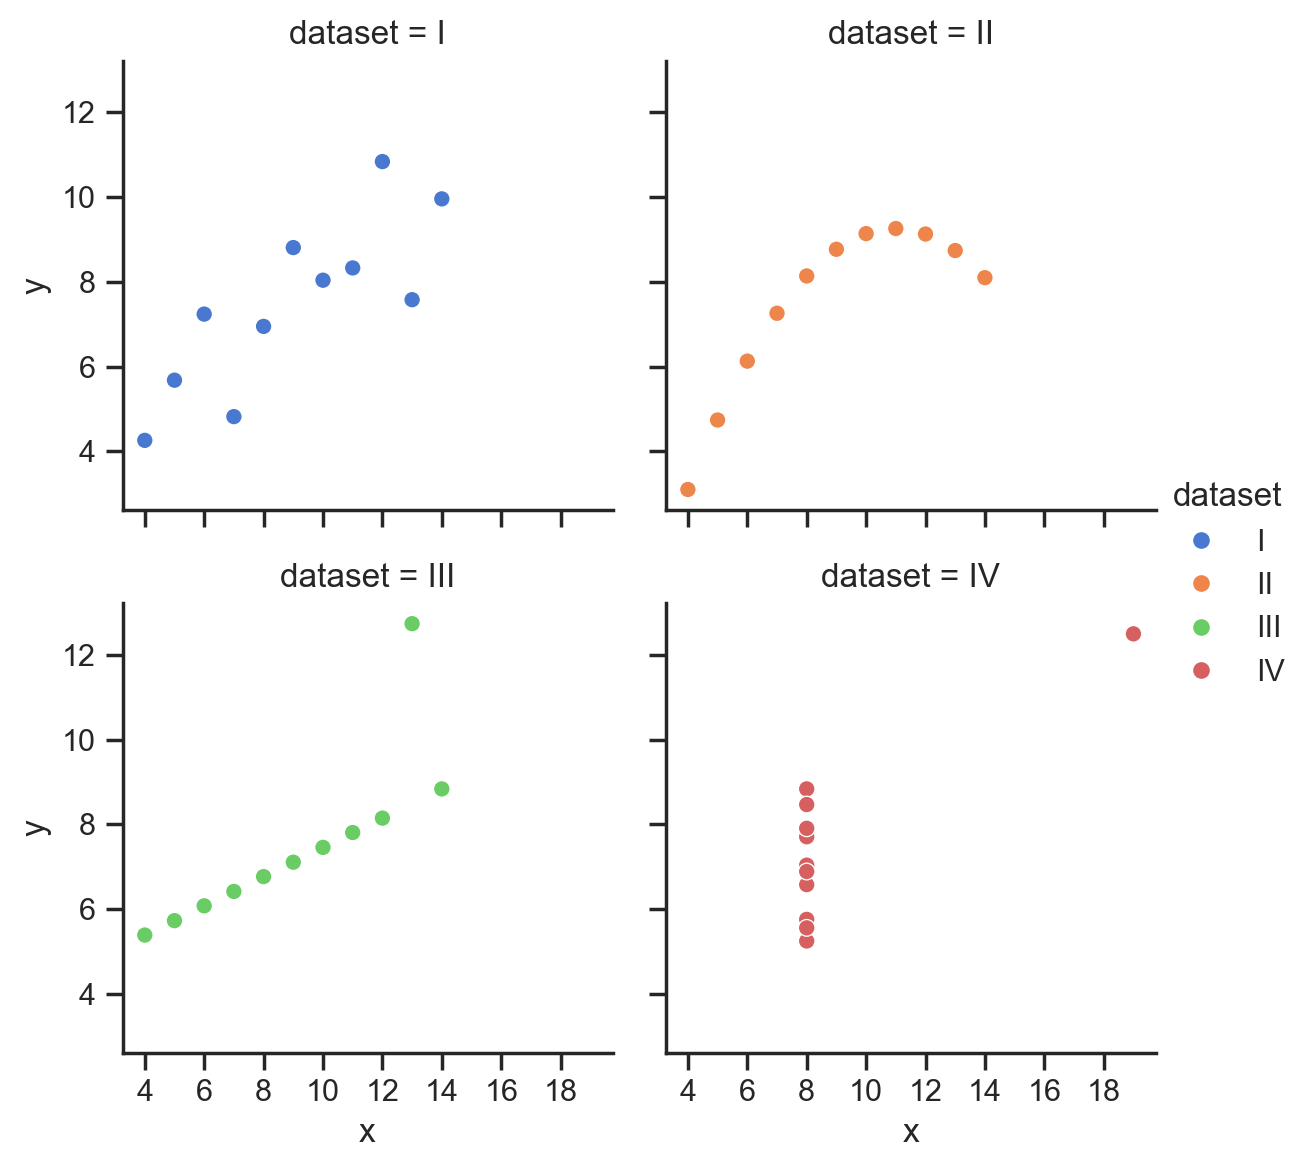

In [57]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);

# Loop over a flattened list of all subplots
for subplot in grid.axes.flat:
    
    # Pass in the MultipleLocator to evenely space the x-ticks by 2
    subplot.xaxis.set_major_locator(MultipleLocator(2));


`.set_major_formatter()` takes a string as input that can be used to set the literaly values of each tick:

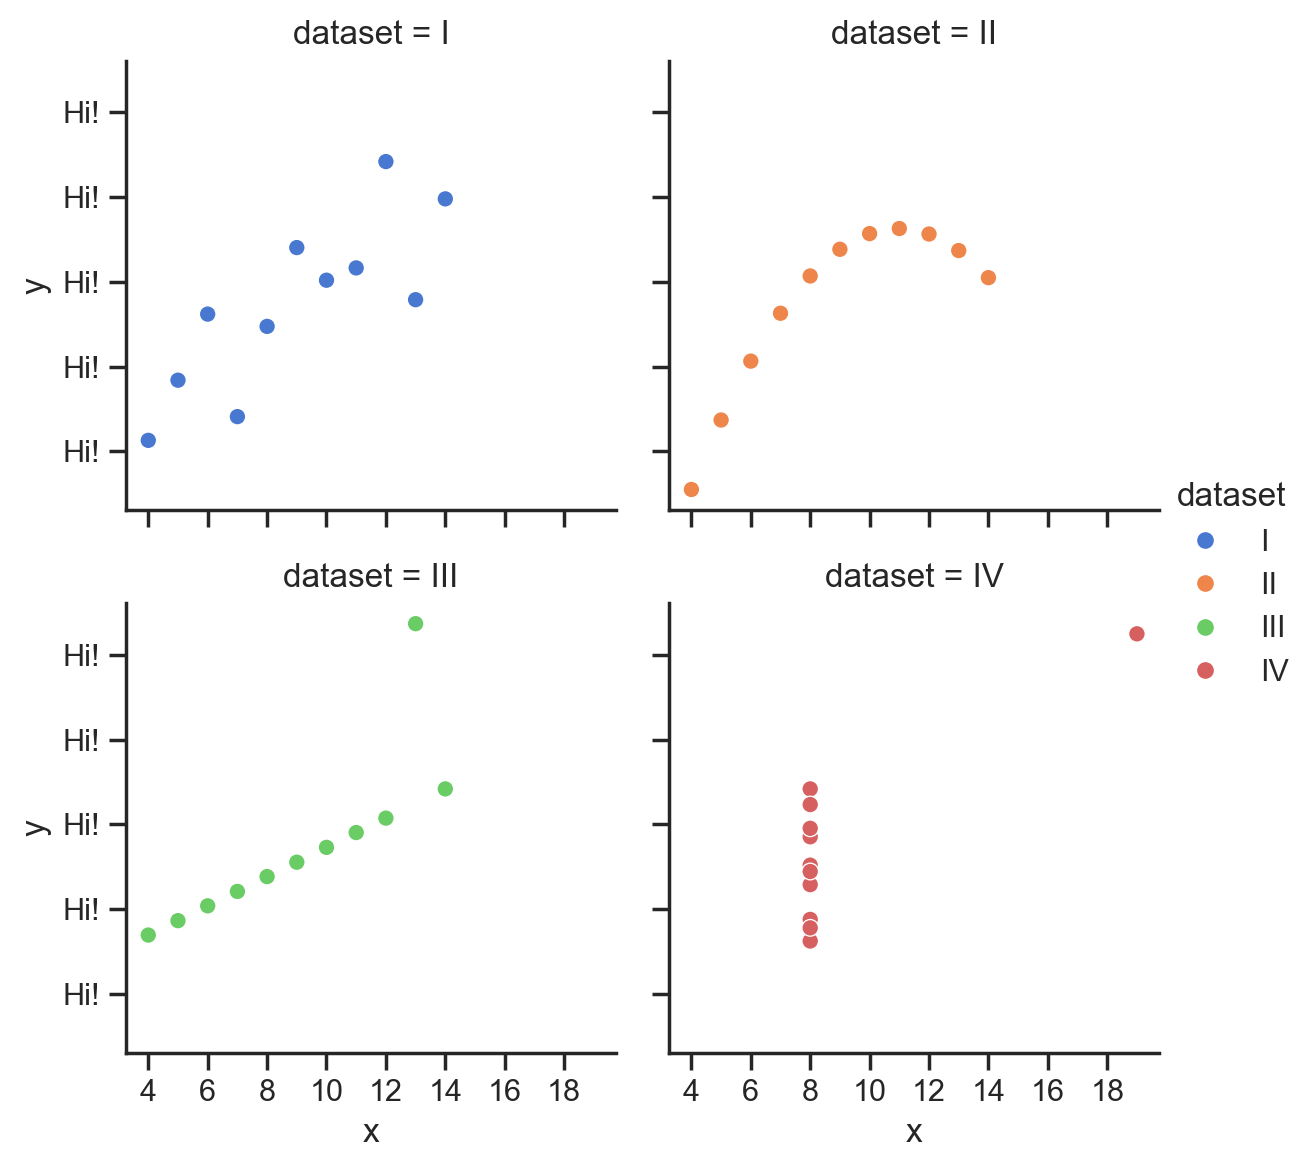

In [58]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);

for subplot in grid.axes.flat:
    subplot.xaxis.set_major_locator(MultipleLocator(2));
    subplot.yaxis.set_major_formatter("Hi!");


Or we can refer to the original tick value use `{x}` inside the string:

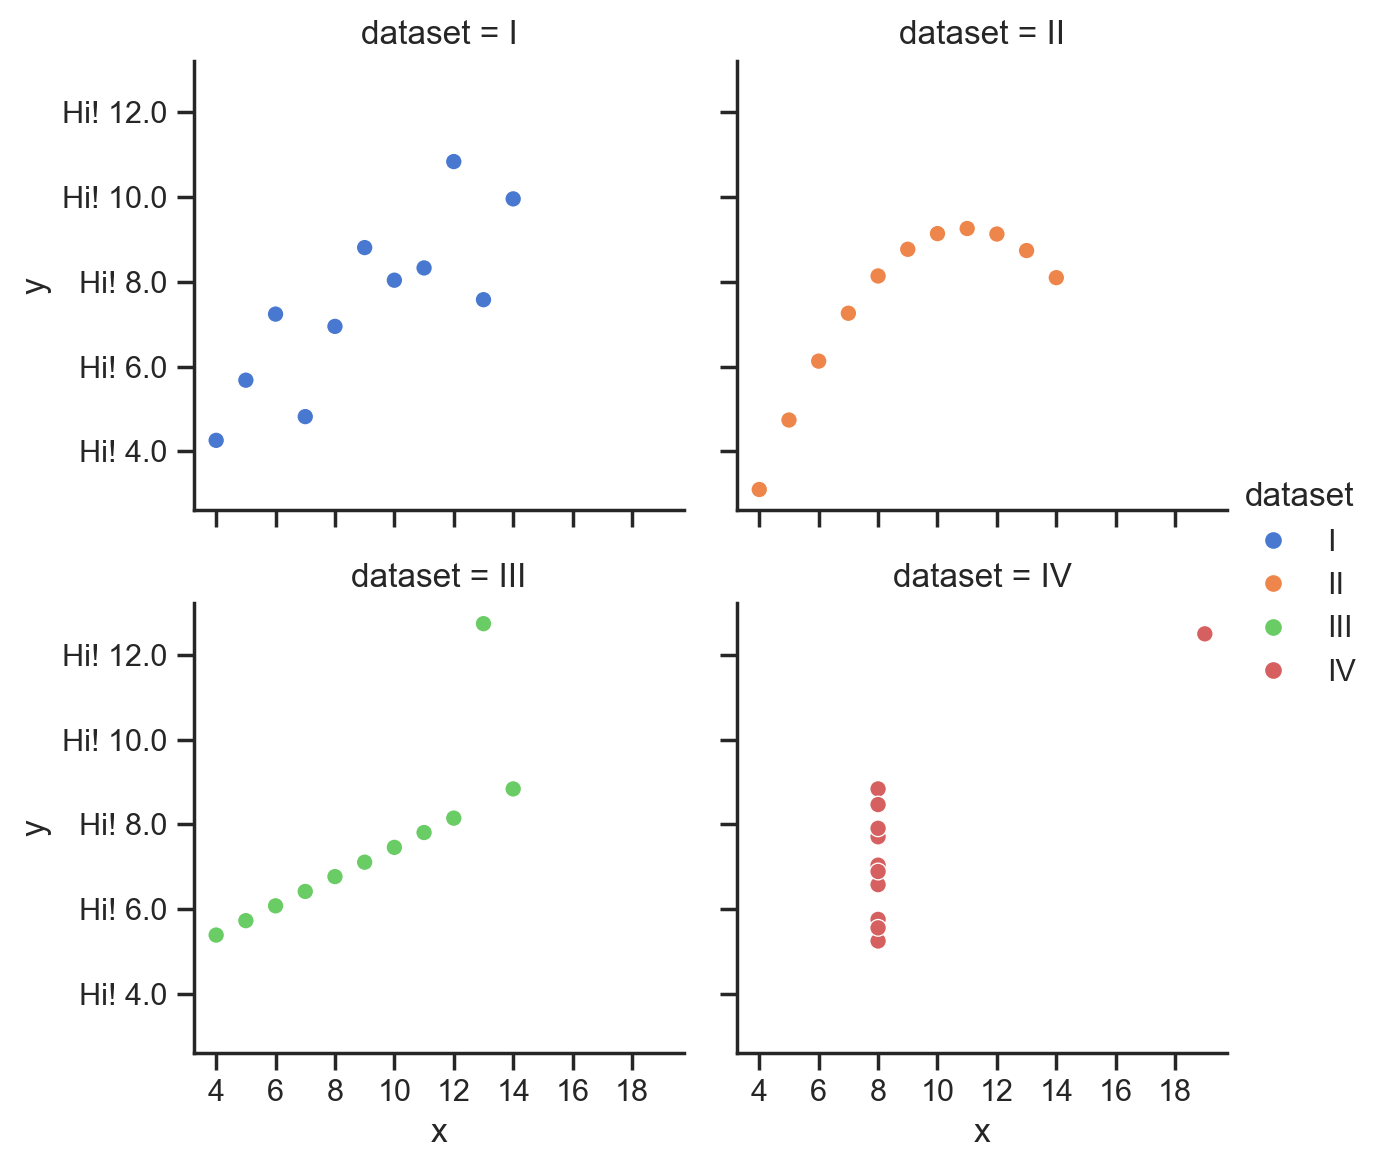

In [59]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);

for subplot in grid.axes.flat:
    subplot.xaxis.set_major_locator(MultipleLocator(2));
    subplot.yaxis.set_major_formatter("Hi! {x}");


Which can be handy for formatting the number of decimal places:

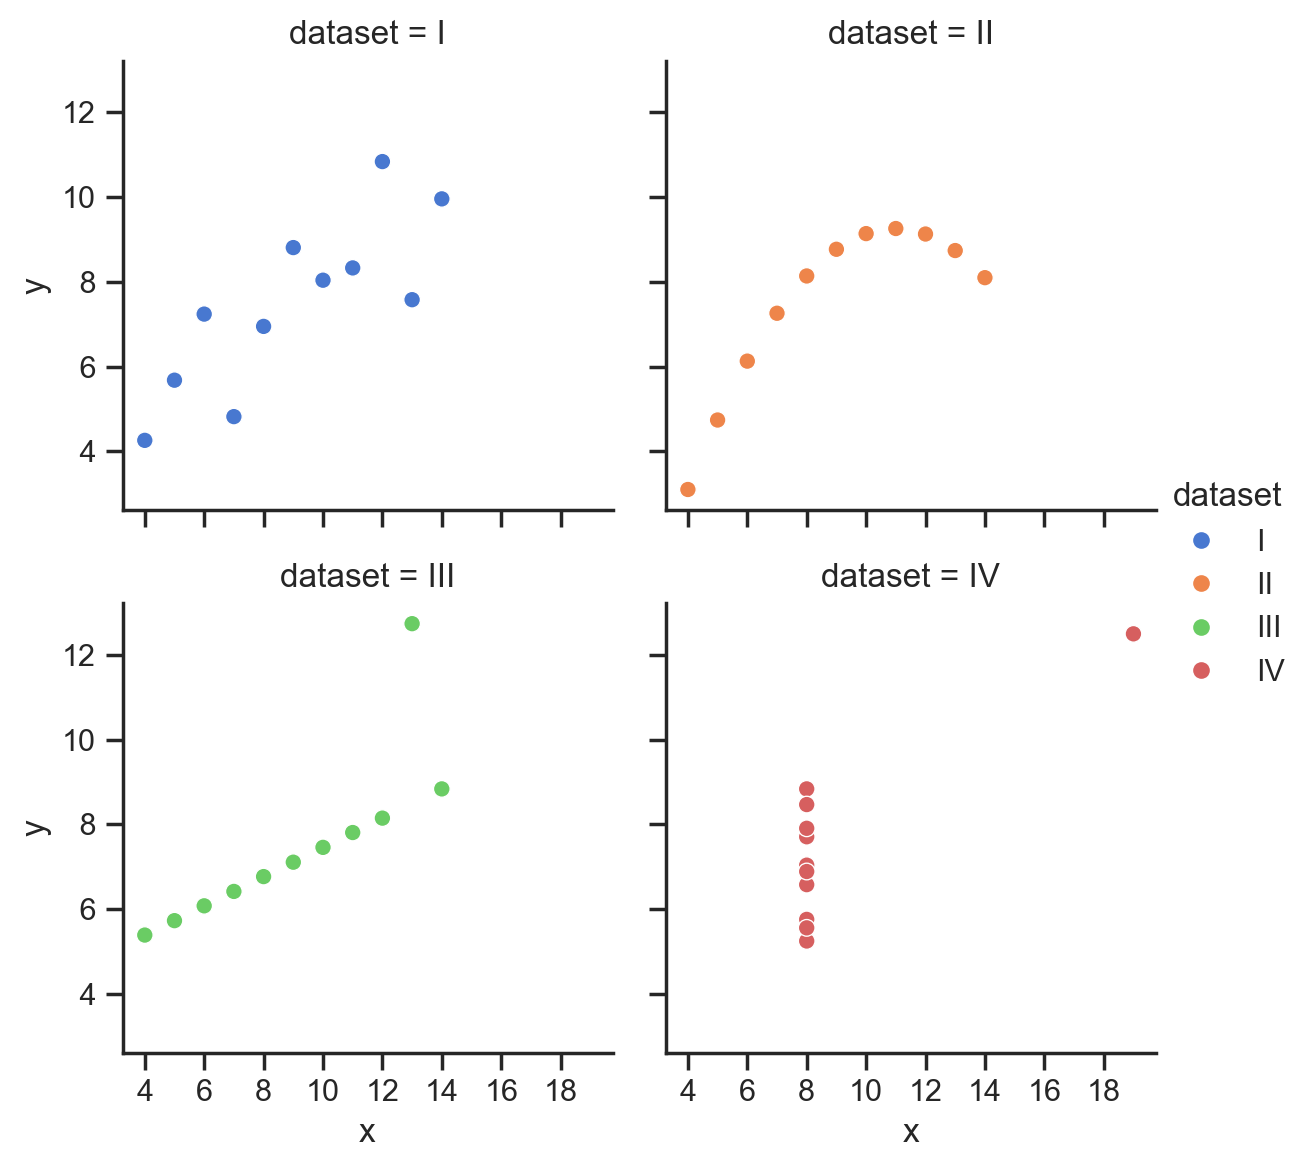

In [60]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);

for subplot in grid.axes.flat:
    subplot.xaxis.set_major_locator(MultipleLocator(2));

    # 2 digits to the left of decimal point and 0 to the right
    subplot.yaxis.set_major_formatter("{x:2.0f}");


Lets write a quick function that makes it easier to adjust spacing and format of ticks in one shot:

In [61]:
def format_axes(grid, locator, formatter=None):
    from copy import copy

    for ax in grid.axes.flat:
        ax.xaxis.set_major_locator(copy(locator));
        ax.yaxis.set_major_locator(copy(locator));

        if formatter is not None:
            ax.xaxis.set_major_formatter(formatter);
            ax.yaxis.set_major_formatter(formatter);

    return grid

Now we can use our function to auto-find matching x and y ticks in intervals of 5:

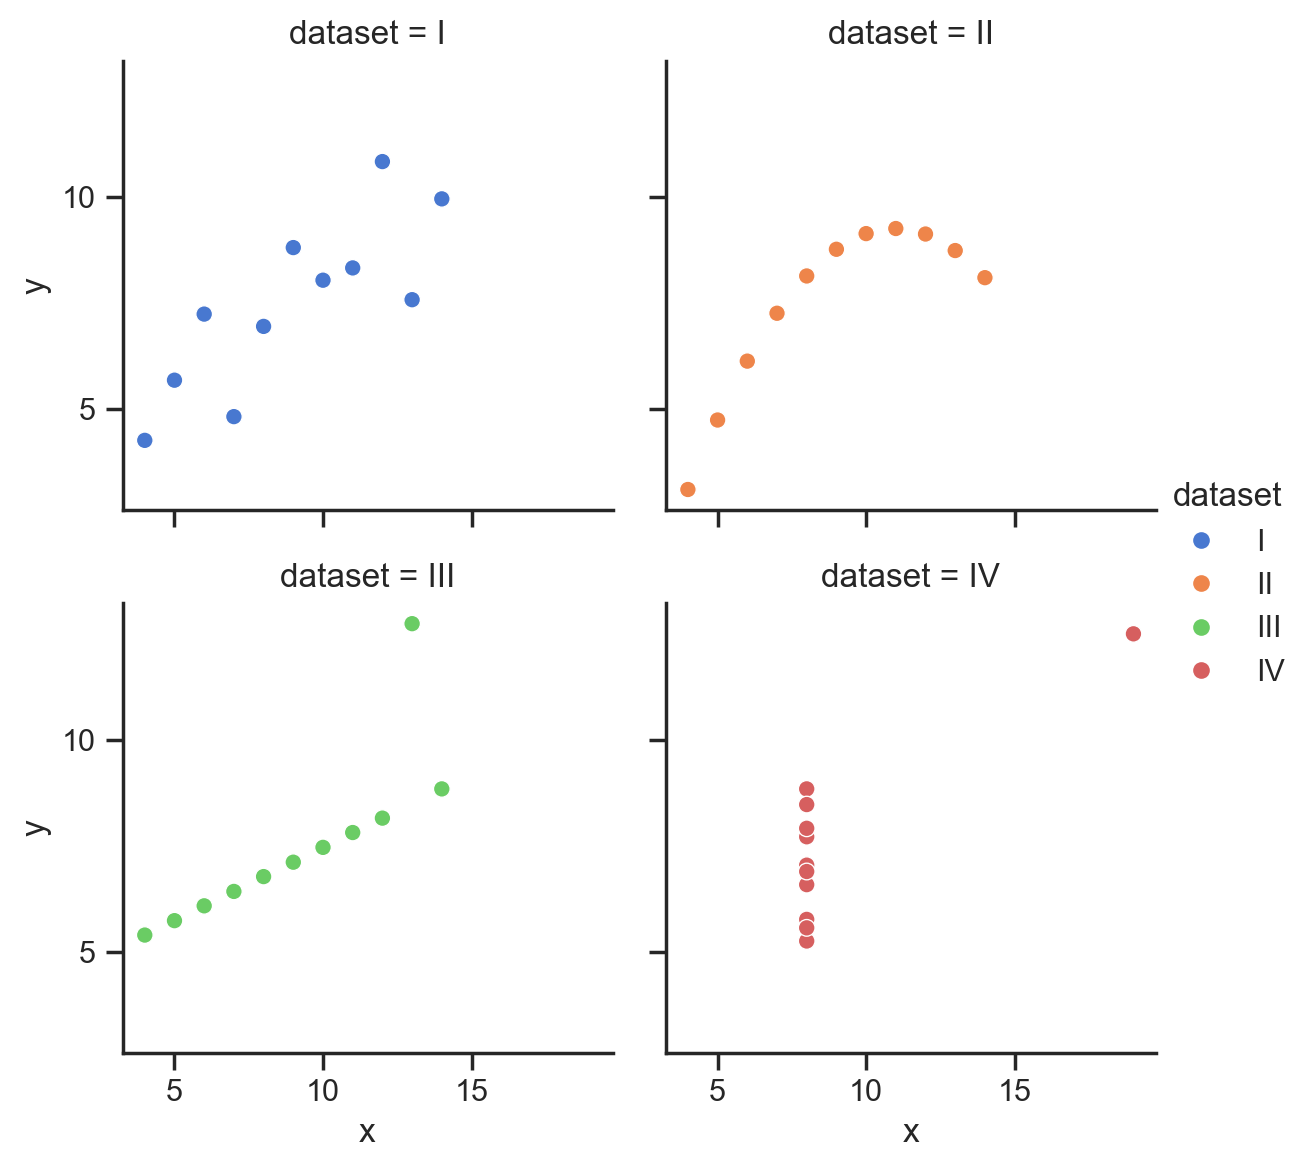

In [62]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);

format_axes(grid, MultipleLocator(5));  

Or auto-find the placement for *at-most* 3 ticks

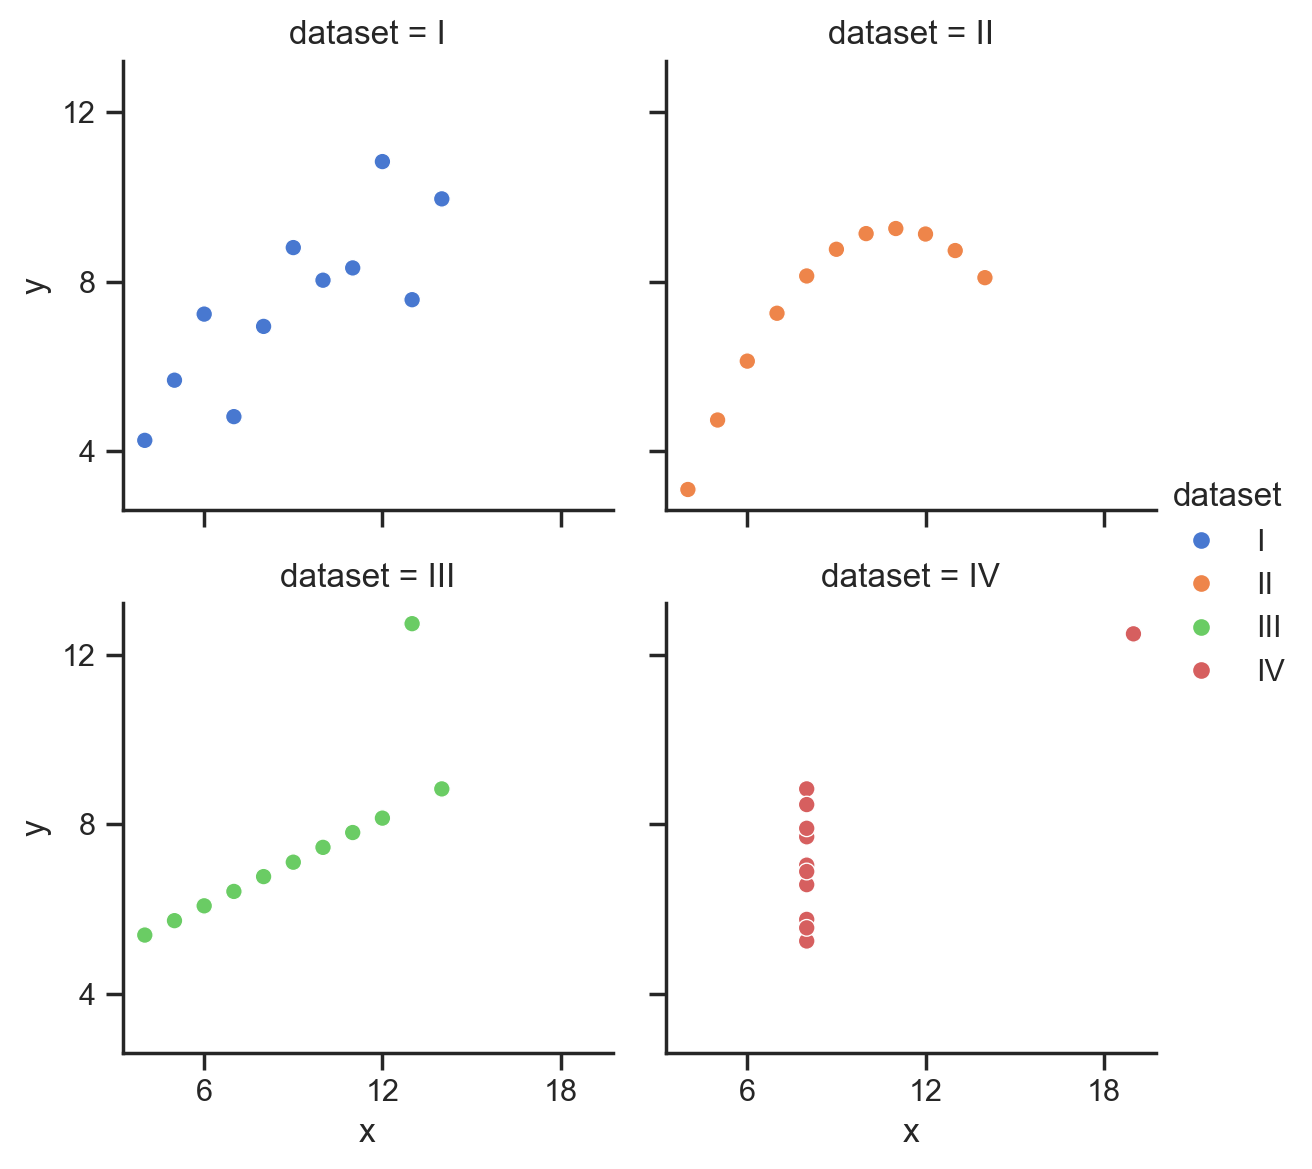

In [63]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);


# Auto-find placement for at most 3 ticks 
format_axes(grid, MaxNLocator(3));  

Or place exactly 5 evenly-spaced ticks from min to max of data and remove decimal places

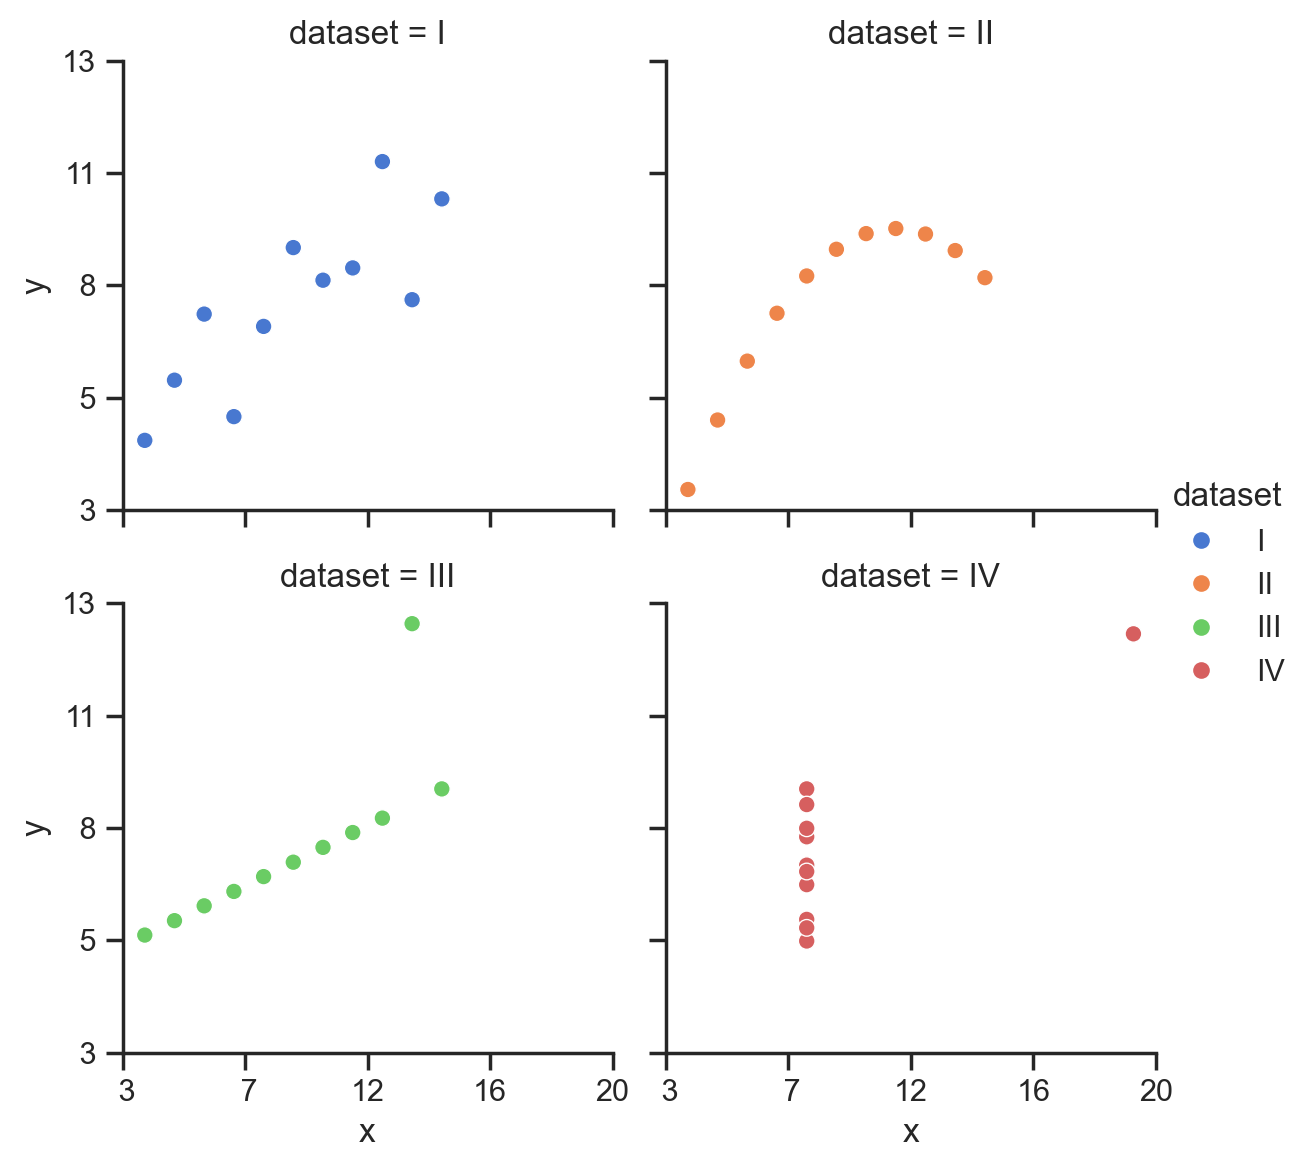

In [64]:
grid = sns.relplot(
    data=scatter_data,
    kind='scatter',
    x="x",
    y="y",
    hue="dataset",
    col="dataset",
    col_wrap=2,
    height=3,
    aspect=1,

);


# Place exactly 5 evenly-spaced ticks from min to max of data
format_axes(grid, LinearLocator(5), formatter="{x:2.0f}");  